# Round 1

In [65]:
PATH = 'NHIS_BDC_2023/Round1/'

In [3]:
!pip install py7zr
!pip install newspaper3k
!pip install yfinance


INFO: pip is looking at multiple versions of py7zr to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.6/138.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00:00:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.4 MB/s eta 0:00:0000:

In [4]:
import torch
import py7zr
import numpy as np
import pandas as pd
from newspaper import Article

import os
import time
import re
import warnings

import yfinance as yf

warnings.filterwarnings("ignore")

# 1. RSS IFO 전처리 및 본문 크롤링
- 제공받은 nasdaq_rss_ifo의 데이터 중 본 분석에 맞도록 전처리 및 본문 크롤링을 실행함
- nasdaq_df_wo_text.csv

## 행 필터링

In [7]:
# 모든 CSV 파일을 불러와서 하나의 데이터프레임으로 합치기
dfs = []
for filename in os.listdir(PATH):
    if filename.startswith('NASDAQ_RSS_IFO'):
        print(filename)
        month_df = pd.read_csv(os.path.join(PATH, filename), encoding='latin1')
        dfs.append(month_df)

# 모든 데이터프레임을 하나로 합치기
df = pd.concat(dfs, ignore_index=True)

# 중복 제거
df = df.drop_duplicates(keep='first')

NASDAQ_RSS_IFO_202305.csv
NASDAQ_RSS_IFO_202306.csv
NASDAQ_RSS_IFO_202307.csv
NASDAQ_RSS_IFO_202308.csv
NASDAQ_RSS_IFO_202301.csv
NASDAQ_RSS_IFO_202302.csv
NASDAQ_RSS_IFO_202303.csv
NASDAQ_RSS_IFO_202304.csv


In [8]:
df.shape # (146914, 8)

(146914, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146914 entries, 0 to 2295463
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   rgs_dt              146914 non-null  int64 
 1   tck_iem_cd          146914 non-null  object
 2   til_ifo             146914 non-null  object
 3   ctgy_cfc_ifo        146914 non-null  object
 4   mdi_ifo             146914 non-null  object
 5   news_smy_ifo        146914 non-null  object
 6   rld_ose_iem_tck_cd  146914 non-null  object
 7   url_ifo             146914 non-null  object
dtypes: int64(1), object(7)
memory usage: 10.1+ MB


In [10]:
#url 기준 중복 행 제거
df['url_base'] = df['url_ifo'].apply(lambda x: re.sub(r'-0$', '', x))
print(df.shape)
df.drop_duplicates(subset=['url_ifo'], inplace=True)
print(df.shape)
df = df[~((df.duplicated(subset='url_base', keep=False)) & (df['url_ifo'].str.endswith('-0')))] #-0 앞까지 중복되면서, -0으로 끝나는 url이 들어간 행 모두 제거
print(df.shape)
df.drop(columns=['url_base'], inplace=True)
print(df.shape)

(146914, 9)
(93241, 9)
(89022, 9)
(89022, 8)


In [11]:
#url이 "_"인 기사를 삭제함
#pre-market, after-hours 관련 기사는 단순히 주가를 나열하는 기사이므로 삭제함

df = df[~(df['url_ifo']=="_")]
print(df.shape)
df = df[~df['ctgy_cfc_ifo'].str.contains("Pre-Market|After-Hours")]
print(df.shape)
df = df[~df['til_ifo'].apply(lambda x: 'Pre-Market' in x)]
print(df.shape)
df = df[~df['til_ifo'].apply(lambda x: 'After-Hours' in x)]
print(df.shape)

(89021, 8)
(88769, 8)
(88676, 8)
(88602, 8)


In [12]:
df.shape

(88602, 8)

### all_tck_iem_cd 열 생성

- 본래 tck_iem_cd 열의 주식을 대상으로 분석을 하려고 했으나, 해당 열이 정확하지 않다고 판단함.
- 예를 들어, 'AAPL'은 해당 열에 7, 8월에만 등장하는데, 이는 상식적이지 않음
- rld_ose_iem_tck_cd 열에는 'AAPL'이 지속적으로 등장하는 것으로 보아, 두 열의 티커코드를 합친 all_tck_iem_cd 열을 생성하여 이를 활용한 분석을 시행하는 게 적절하다고 판단함

In [13]:
print('AAPL이 처음 등장하는 날짜: ', min(df[df['tck_iem_cd']=='AAPL']['rgs_dt']))
print('AAPL이 마지막으로 등장하는 날짜: ', max(df[df['tck_iem_cd']=='AAPL']['rgs_dt']))

AAPL이 처음 등장하는 날짜:  20230717
AAPL이 마지막으로 등장하는 날짜:  20230831


In [14]:
# 'rld_ose_iem_tck_cd' 열에 있는 티커코드를 ','를 기준으로 분리하여 리스트로 만듦
df['rld_ose_iem_tck_cd_lst'] = df['rld_ose_iem_tck_cd'].str.split(',')

In [15]:
print(min(df[df['rld_ose_iem_tck_cd_lst'].apply(lambda x: 'AAPL' in x)]['rgs_dt']))
print(max(df[df['rld_ose_iem_tck_cd_lst'].apply(lambda x: 'AAPL' in x)]['rgs_dt']))
print(len(df[df['rld_ose_iem_tck_cd_lst'].apply(lambda x: 'AAPL' in x)]['rgs_dt']))

20230111
20230831
937


In [16]:
df[['rld_ose_iem_tck_cd', 'rld_ose_iem_tck_cd_lst']].head(10)

,rld_ose_iem_tck_cd,rld_ose_iem_tck_cd_lst
0,"CERT,CTMX","[CERT, CTMX]"
1,"TSLX,OCN","[TSLX, OCN]"
2,"PODD,DKNG,CERT,BITF","[PODD, DKNG, CERT, BITF]"
3,TMCI,[TMCI]
4,"NEO,WING","[NEO, WING]"
5,SLNA,[SLNA]
6,"OBT,SBNY","[OBT, SBNY]"
7,"NCLH,ISPO","[NCLH, ISPO]"
8,"NSA,DRH","[NSA, DRH]"
9,"AVDL,AVDL,RMTI,TGTX","[AVDL, AVDL, RMTI, TGTX]"


In [17]:
#'tck_iem_cd'와 'rld_ose_iem_tck_cd_lst'에 있는 모든 주식코드를 all_tck_iem_cd 열에 합치고, 중복된 티커코드가 여러 번 나타나는 경우 제거함

df['all_tck_iem_cd'] = df.apply(lambda row: list(set([row['tck_iem_cd']] + row['rld_ose_iem_tck_cd_lst'])), axis=1)

In [20]:
df[['tck_iem_cd', 'rld_ose_iem_tck_cd', 'all_tck_iem_cd']]

,tck_iem_cd,rld_ose_iem_tck_cd,all_tck_iem_cd
0,CERT,"CERT,CTMX","[CERT, CTMX]"
1,OCN,"TSLX,OCN","[OCN, TSLX]"
2,CERT,"PODD,DKNG,CERT,BITF","[CERT, DKNG, BITF, PODD]"
3,TMCI,TMCI,[TMCI]
4,NEO,"NEO,WING","[WING, NEO]"
...,...,...,...
2295444,ABEV,"KDP,KDP,ABEV","[ABEV, KDP]"
2295446,FFIV,FFIV,[FFIV]
2295450,EDU,EDU,[EDU]
2295452,TDY,TDY,[TDY]


In [21]:
df.drop('rld_ose_iem_tck_cd_lst', axis=1, inplace=True)

In [22]:
df.columns

Index(['rgs_dt', 'tck_iem_cd', 'til_ifo', 'ctgy_cfc_ifo', 'mdi_ifo',
       'news_smy_ifo', 'rld_ose_iem_tck_cd', 'url_ifo', 'all_tck_iem_cd'],
      dtype='object')

In [23]:
df.shape

(88602, 9)

In [24]:
df.to_csv(os.path.join(PATH, 'nasdaq_df_wo_text.csv'), index=False)

## Text Crawling
- 제공받은 nasdaq_rss_ifo의 url을 newspaper 라이브러리를 이용해 기사본문을 크롤링함.
- nasdaq_final.csv

In [27]:
!pip install newspaper3k

In [28]:
from newspaper import Article
import numpy as np
import pandas as pd
import time
import os
import re

In [29]:
nasdaq_df = pd.read_csv(os.path.join(PATH, 'nasdaq_df_wo_text.csv'))
nasdaq_df.shape

(88602, 9)

In [30]:
def extract_text(url):

    article = Article(url)
    article.download()
    article.parse()
    text = article.text or 'N/A' #text가 없는 경우 'N/A'로 출력

    return text

In [32]:
nasdaq_df['text'] = None  # 'text'열을 None으로 초기화

In [34]:
nasdaq_df['text'].isna().sum()

88602

In [37]:
#크롤링 코드

from IPython.display import display

def crawl_nasdaq_texts(nasdaq_df, start_index, end_index): #start_index, end_index를 조정하여 여러 번에 나눠서 크롤링할 수 있음
    for index, row in nasdaq_df.iterrows():
        if index < start_index:
            continue

        try:
            url = row['url_ifo']
            extracted_text = extract_text(url)
            nasdaq_df.at[index, 'text'] = extracted_text

        #에러 나는 경우 처리(공백은 try 경우에 포함)
        except Exception as e:
            print(f"Error at index {index}: {e}")

        if index % 100 == 0:
            print(f"Processing index {index}")
            display(nasdaq_df.iloc[index-10:index])

        #아래 코드는 ckpt를 사용할 경우 주석 제거하시면 됩니다.

        # if index % 1000 == 0:
        #     folder_path = f'{PATH}'"/nasdaq_text_crawling_ckpt"
        #     if not os.path.exists(folder_path):
        #         os.makedirs(folder_path)
        #     nasdaq_df.to_csv(os.path.join(PATH, "nasdaq_text_crawling_ckpt", f"{start_index}_{index}_ckpt.csv"), index=False)

        #index > end_index인 경우 자동으로 제거
        if index == end_index:
            folder_path = f'{PATH}'"/nasdaq_text_crawling_ckpt"
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            nasdaq_df.to_csv(os.path.join(PATH, "nasdaq_text_crawling_ckpt", f"{start_index}_{index}_ckpt.csv"), index=False)
            print(f"{start_index}_{index} 크롤링 완료")
            break

    return nasdaq_df

In [ ]:
result_df = crawl_nasdaq_texts(nasdaq_df, 0, len(nasdaq_df)-1)

In [ ]:
#중복 행 제거
result_df.drop_duplicates(inplace=True)
result_df.shape

In [ ]:
# 'text'로 시작하는 모든 열을 필터링
text_columns = [col for col in result_df.columns if col.startswith('text')]
print(text_columns)

# 해당 열들에서 'NaN'(에러가 난 행)이 아닌 첫 번째 값을 찾는 새로운 열 생성. 모두 'NaN'일 경우, 'NaN'으로 저장
result_df['text_not_nan'] = result_df[text_columns].apply(lambda row: next((item for item in row if not pd.isna(item)), np.nan), axis=1)

result_df.head()

In [ ]:
result_df = result_df[result_df['text_not_nan']!='N/A'] #text_not_nan이 'N/A'가 아닌 행만 필터링(text가 공백인 행)

In [ ]:
result_df.isna().sum() #text_not_nan에 null값(error난 행) 있는지 확인.

In [ ]:
result_df.drop(text_columns, axis=1, inplace=True) #바로 위에서 정의한 text로 시작하는 열 drop(text_not_nan은 drop 안 됨)

result_df.rename(columns={'text_not_nan': 'text'}, inplace=True)

result_df.head()

In [ ]:
#error난 url 다시 크롤링 시도한 후 최종 결과를 nasdaq_final.csv에 저장

nan_index_range = result_df[result_df['text'].isna()].index
print("NaN indices: ", nan_index_range)

def recrawl_nasdaq_error_texts(nasdaq_df, start_index=0, end_index=len(df)-1, nan_index_range=None): #원하는 index range에서 nan_index_range 찾을 수 있음
    error_url_list = []
    for index in nan_index_range:
        if index < start_index:
            continue

        # #end_index를 작게 설정하는 경우 대비. end_index=len(df)-1이라면 필요 없음.
        # if index > end_index:
        #     nasdaq_df.to_csv(os.path.join(PATH, "nasdaq_final.csv"), index=False)
        #     print(f"{start_index}_{end_index} 크롤링 완료")
        #     break


        try:
            url = nasdaq_df.at[index, 'url_ifo']
            extracted_text = extract_text(url)
            nasdaq_df.at[index, 'text'] = extracted_text
            print(f"Processing index {index}")

        except Exception as e:
            print(f"Error at index {index}: {e}")
            error_url_list.append(url)

    #error가 난 url이 있는 행 포함하여 저장
    print("Number of error urls: ", len(error_url_list))
    nasdaq_df.to_csv(os.path.join(PATH, "nasdaq_final.csv"), index=False)

    return nasdaq_df, error_url_list

In [ ]:
df, error_url_list = recrawl_nasdaq_error_texts(result_df, nan_index_range=nan_index_range)

# 2. Stock Description Crawling(현재 작동하지 않는 코드)
- 야후파이낸스의 라이브러리를 이용해 기업 설명이 기재된 description을 크롤링함.
- 추후 토픽의 키워드와 키워드에 맞는 기업을 연결하기 위함.
- stock_description.csv

In [39]:
import yfinance as yf
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

In [40]:
PATH

'NHIS_BDC_2023/Round1/'

In [41]:
stock = pd.read_csv(os.path.join(PATH, 'NASDAQ_FC_STK_IEM_IFO.csv'), encoding = "cp949")
stock

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm
0,US00211V1061,AACG,ATA ...,ATA CreatGlo ...
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...
2,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...
3,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...
4,US0003602069,AAON,에이에이온 ...,AAON ...
...,...,...,...,...
2738,US4884452065,ZVRA,Zevra ...,Zevra ...
2739,US98987D1028,ZVSA,Zyversa ...,Zyversa ...
2740,US98985Y1082,ZYME,Zymeworks ...,Zymeworks ...
2741,US98986X1090,ZYNE,자이너바 파마수티컬스 ...,Zynerba Pharms ...


In [42]:
# 'tck_iem_cd' 열의 공백 제거
stock['tck_iem_cd'] = stock['tck_iem_cd'].str.strip()

In [43]:
# 종목 티커 코드 리스트
tck_iem_cds = list(stock['tck_iem_cd'])

In [44]:
# 종목 description 추출
def get_stock_descriptions(tck_iem_cds):
    descriptions = []

    for tck_iem_cd in tck_iem_cds:
        try:
            # Ticker 객체 생성
            ticker = yf.Ticker(tck_iem_cd)

            # 종목 정보 가져오기 - 예선 때는 작동했으나 현재 작동하지 않는 코드입니다
            stock_info = ticker.info 

            # 'longBusinessSummary' 키에 해당하는 종목 description 정보 가져오기
            description = stock_info.get('longBusinessSummary', None)

            # 가져온 정보를 리스트에 추가
            descriptions.append(description)
        except Exception as e:
            print(f"Error fetching data for {tck_iem_cd}: {str(e)}")
            descriptions.append(None)

    data = pd.DataFrame({'tck_iem_cd': tck_iem_cds, 'description': descriptions})

    return data

In [ ]:
#데이터프레임 생성
stock_description = get_stock_descriptions(tck_iem_cds)

stock_description

In [ ]:
#결측치 확인
stock_description.isnull().sum()

In [ ]:
#전처리
stock_description = stock_description.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
stock_description.dropna(subset=['description'], inplace=True)
stock_description.reset_index(drop=True, inplace=True)
stock_description.drop_duplicates(subset=['description'], inplace=True)

In [ ]:
stock_description.head()

In [ ]:
stock_description.shape

### 데이터프레임에 영문기업명 추가
- 추후 FinBERT로 감성분석 진행시 영문기업명을 기준으로 기사 문단을 추출하기 위함.

In [ ]:
company_name = stock[['tck_iem_cd', 'fc_sec_eng_nm']]
company_name

In [ ]:
# 두 데이터프레임을 tck_iem_cd 열을 기준으로 inner join
stock_description_new = pd.merge(stock_description, company_name, how='inner', on='tck_iem_cd')
stock_description_new.head()

In [ ]:
stock_description_new.shape

In [ ]:
stock_description_new.to_csv(os.path.join(PATH, 'stock_description.csv'), index=False)

# 3. CNBC 기사 url 크롤링
- 크롤링 목적 : 토픽모델링 시에 사용할 데이터
- 데이터 선정 이유: CNBC는 미국의 경제·금융 뉴스 채널로, CNBC에서 각광받거나 언급량이 많은 토픽은 시장에서 많은 관심을 받고 있는 분야라고 여길 수 있다. 그렇기에 투자 기업을 정하기 전 CNBC를 통해 앞으로 성장 가능성이 있거나 시장의 개입이 이뤄질 것 같은 분야를 먼저 확인하고, 해당 분야에서 투자 가치가 있는 기업을 제공하고자 한다.

- 수집 데이터 일자 : 2023.1.1 ~ 2023.8.31

- 크롤링 방식 : Google에 "CNBC"를 검색하고, 7일 단위(2023.1.1 ~ 2023.1.7, ...)로 필터링을 주어, 해당 주의 모든 기사 url 크롤링

- 7일 단위로 필터링한 이유 : 구글 검색 결과의 제한(33페이지)으로 인해 기간을 길게 할 경우, 해당 기간의 기사가 모두 표시되지 않기 때문, 기간을 너무 짧게 할 경우에는 필요없는 기사가 추출됨을 확인했기에 7일이 적절하다고 판단.

- all_matching_links_final.pkl

- driver 문제로 <CNBC 기사 url 크롤링> 섹션에서는 가상환경에서 실행하셔야 합니다.
- conda create -n NH python=3.8
- selenium==4.12.0, pandas==2.0.3, re==2.2.1, bs4==4.12.2, requests==2.31.0, newspaper==0.2.8

In [48]:
!pip install selenium
!pip install bs4
!pip install requests
!pip install newspaper3k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 36.6 MB/s eta 0:00:00


In [49]:
import selenium
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import re
from datetime import datetime, timedelta
import pickle
import os
from bs4 import BeautifulSoup
import requests
from newspaper import Article

In [50]:
PATH

'NHIS_BDC_2023/Round1/'

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options)


def cnbc_crawling(start_date, end_date):

    global driver

    start_values_iter = iter(range(0, 320, 10)) #페이지 number - 0이면 10페이지
    current_matching_links = []
    retry_count = 0
    terminate_flag = False

    while True:
        if terminate_flag:
            break

        #구글 검색결과의 각 페이지에서 크롤링
        try:
            current_start = next(start_values_iter)
        except StopIteration:
            break

        print(f"page: {current_start // 10 + 1}")

        while True:
            matching_links_count = 0
            date_range_str = f"cd_min:{start_date},cd_max:{end_date}"
            google_search_url = f'https://www.google.com/search?q=cnbc&sca_esv=568517199&tbs=cdr:1,{date_range_str}&tbm=nws&sxsrf=AM9HkKmYdZ0_zRMPireMpaE6VsIgqW5jBg:1695740222154&ei=PvESZZmECbfh2roPnbOa-A0&start={current_start}&sa=N&ved=2ahUKEwiZm8rMxMiBAxW3sFYBHZ2ZBt84ygIQ8tMDegQIAxAW&biw=1137&bih=790&dpr=2'
            driver.get(google_search_url)

            links_with_class = driver.find_elements(By.CSS_SELECTOR, 'a.WlydOe[jsname="YKoRaf"]')
            for link in links_with_class:
                href = link.get_attribute('href')

                if href and re.match(r'https://www\.cnbc\.com/2023/\d{2}/\d{2}/[a-z0-9-]+\.html', href):
                    current_matching_links.append(href)
                    print(href)
                    matching_links_count += 1

            if matching_links_count > 0:
                retry_count = 0
                break

            #해당 페이지에 matching되는 url이 없으면 재시도 - "로봇이 아닙니다"가 뜨거나 페이지가 비었다면, matching되는 url이 없을 것
            else:
                driver.quit()
                driver = webdriver.Chrome(options=chrome_options)
                retry_count += 1

            #재시도 횟수가 2번 이상이면 terminate시키고 다음 기간으로 넘어감. (그 페이지가 비었다는 뜻이므로). 재시도란, 결과가 나오지 않아 드라이버를 껐다 켜는 행위.
            #"로봇이 아닙니다"는 driver를 새로 열면 사라지므로, 재시도 횟수가 2번 이상이라는 것은 정말 페이지가 비었다는 의미.
            if retry_count >= 2:
                terminate_flag = True
                break

    return current_matching_links

#함수 호출 예시 - 7일 단위로 날짜 설정해주기
cnbc_crawling("01/01/2023", "01/07/2023")

In [ ]:
#7일 단위로 크롤링

start_date = datetime.strptime("1/1/2023", "%m/%d/%Y")
end_date = datetime.strptime("8/31/2023", "%m/%d/%Y")
all_matching_links = [] #모든 link 저장
empty_count = 0

# Driver options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options)

# 7일 범위 날짜 생성
while start_date <= end_date:
    next_end_date = start_date + timedelta(days=6)
    if next_end_date > end_date:
        next_end_date = end_date

    #7일 단위로 크롤링
    current_start_date, current_end_date = (start_date.strftime("%m/%d/%Y"), next_end_date.strftime("%m/%d/%Y"))
    current_matching_links = cnbc_crawling(current_start_date, current_end_date)
    all_matching_links += current_matching_links

    # 결과 처리 또는 저장
    print(f'크롤링 결과 (시작 날짜: {current_start_date}, 종료 날짜: {current_end_date}):')
    print(f'누적 크롤링된 기사 수: {len(all_matching_links)}')
    print(f'현재 크롤링된 기사 수: {len(current_matching_links)}')

    start_date += timedelta(days=7)


    # ###4주마다 체크포인트 저장
    # week_counter += 1  # Increment week_counter
    # if week_counter == 4:  # Check if 4 weeks have passed
    #     file_name = f"all_matching_links_{next_end_date.strftime('%Y_%m_%d')}.pkl"
    #     full_path = os.path.join(PATH, file_name)
    #     with open(full_path, 'wb') as f:
    #         pickle.dump(all_matching_links, f)
    #     week_counter = 0  # Reset week_counter

    # Save the remaining data if next_end_date reaches end_date

if next_end_date == end_date:
    file_name = "all_matching_links_final.pkl"
    full_path = os.path.join(PATH, file_name)
    with open(full_path, 'wb') as f:
            pickle.dump(all_matching_links, f)

## url에 접속하여 기사 정보 크롤링하기

- url에 접속하여, 제목, 날짜, 카테고리, Key Points(기사요약), 본문 크롤링
- 카테고리 크롤링 이유 : 분석 시, 주식 정보에 관련 없는 카테고리는 삭제하기 위함.
- Key Points 크롤링 이유 : 기사 요약본으로 토픽모델링을 진행하고자 했으나, 문자열이 짧아 토픽이 잘 추출되지 않았음.
- 본문 크롤링 이유 : 토픽모델링에 실제로 사용한 데이터, 본문 데이터로 토픽모델링을 진행한 결과 토픽이 가장 잘 추출되었음.
- cnbc_newsdata_final.pkl

In [ ]:
all_matching_links = pd.read_pickle(os.path.join(PATH, "all_matching_links_final.pkl"))

CNBC_CKPT_PATH = os.path.join(PATH, "news_info_ckpt")
if not os.path.exists(CNBC_CKPT_PATH):
    os.makedirs(CNBC_CKPT_PATH, exist_ok=True)


#Key Points 크롤링
def extract_key_points(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        target_div = soup.find('div', {'class': 'group'})
        if target_div:
            ul = target_div.find('ul')
            if ul:
                lis = ul.find_all('li')
                return ' '.join([li.text for li in lis])
    except Exception as e:
        print(f"Error in extract_key_points: {e}")
        return ""


chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options)

# 기사의 정보를 저장할 list 생성
articles_data = []


def extract_article_info(url, retry_count=0): #재시도 횟수 0에서 시작
    global driver  # 드라이버를 글로벌 변수로 설정

    #category 크롤링
    try:
        driver.get(url)
        page_html = driver.page_source
        soup = BeautifulSoup(page_html, 'html.parser')

        article_header = soup.find(class_='ArticleHeader-eyebrow') or soup.find(class_='ArticleHeader-styles-makeit-eyebrow--Degp4')

        category = article_header.text if article_header else "N/A"
    except Exception as e:
        print(f"Error in category extraction: {e}")
        category = ""


    #title, date, key_points, text 크롤링
    try:
        article = Article(url)
        article.download()
        article.parse()
        title = article.title or 'N/A'
        date = article.publish_date or 'N/A'
        text = article.text or 'N/A'
        key_points = extract_key_points(url) or 'N/A'


    except Exception as e:
        print(f"Error in newspaper extraction: {e}")

        # 에러가 발생하면 드라이버 재시작
        driver.quit()
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        driver = webdriver.Chrome(options=chrome_options)

        # retry_count < 1이면 크롤링 다시 시도
        if retry_count < 1:
            return extract_article_info(url, retry_count=retry_count + 1) #재귀적 코드

        #retry_count >= 1일 때, url을 제외한 행 전체가 빈칸으로 나타남

        print(f'Error in {url}')
        title, date, text, key_points = "", "", "", ""

    new_data = {
        'title': title,
        'date': date,
        'category': category,
        'key_points': key_points,
        'text': text,
        'url': url
    }

    #새로 크롤링한 데이터를 articles_data list에 추가
    articles_data.append(new_data)
    #print(f"Newly appended data: {new_data}")

#url list 정의 - link를 날짜 순서대로 정렬
url_list = sorted(list(all_matching_links))

for idx, url in enumerate(url_list, 1):
    extract_article_info(url)

    #10개 단위로 체크포인트 파일 저장
    if idx % 10 == 0:
        checkpoint_df = pd.DataFrame(articles_data)
        display(checkpoint_df)

        checkpoint_df.to_csv(os.path.join(CNBC_CKPT_PATH, f"{idx}번째_체크포인트.csv"), index=False)
        print(f"Saved checkpoint at {idx}th URL.")

    #time.sleep(1.5)

driver.quit()

df = pd.DataFrame(articles_data)

df

In [ ]:
df[(df=='').any(axis=1)]

In [ ]:
df_filtered = df[df['title'] != '']

df_filtered

In [ ]:
df_filtered.to_csv(os.path.join(PATH, "cnbc_newsdata_final.pkl", index=False))

In [ ]:
# with open(os.path.join(PATH, "cnbc_newsdata_final.pkl"), 'wb') as f:
#     pickle.dump(df_filtered, f)

# 4. BERTopic을 이용한 8월 CNBC기사 토픽모델링
- CNBC 경제 뉴스 사이트에서 최근 인기 있는 기사 토픽을 파악하고자 함.
- 대회 시작 당시 9월 초였기에 '최근'의 기준을 8월 1달로 한정함.

In [ ]:
!pip install bertopic

In [ ]:
#전처리 패키지
import pandas as pd
import numpy as np
from datetime import datetime
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#토픽 모델링 패키지
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.representation import MaximalMarginalRelevance

#interactive plot 시각화
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [97]:
import bertopic

try:
    version = SentenceTransformer.__version__
except AttributeError:
    try:
        from importlib.metadata import version
        version = version('bertopic')
    except ImportError:
        version = "버전을 확인할 수 없음"

BERTopic = 0.15.0


In [87]:
import sys

print('Python =', sys.version)


Python = 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


In [94]:
#전체 패키지 버전
print('pandas = ',pd.__version__)
print('numpy = ',np.__version__)
print('re = ',re.__version__)
print('spacy = ',spacy.__version__)
print('sklearn = ', sklearn.__version__)
print('BERTopic =', version)
print('Python =', sys.version)

pandas =  1.5.3
numpy =  1.24.3
re =  2.2.1
spacy =  3.7.0
sklearn =  1.3.0
BERTopic = 0.15.0
Python = 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


## 데이터 준비

In [8]:
df = pd.read_csv('NHIS_BDC_2023/Round1/cnbc_newsdata_final.csv')
df

,title,date,category,key_points,text,url
0,‘I work just 5 hours a week': A 39-year-old wh...,2023-01-01,Success,NaN,"Graham Cochrane, Founder of The Recording Revo...",https://www.cnbc.com/2023/01/01/39-year-old-wh...
1,Chinese state media seek to reassure public ov...,2023-01-01,Asia-Pacific News,Chinese state media sought to reassure the pub...,Revelers prepare to release balloons to celebr...,https://www.cnbc.com/2023/01/01/chinese-state-...
2,Should you get creative with your resume? Expe...,2023-01-01,Land the Job,NaN,Mature businessman congratulating young profes...,https://www.cnbc.com/2023/01/01/cv-will-a-crea...
3,Market misery deals sovereign wealth funds his...,2023-01-01,Markets,Heavy falls in stock and bond markets over the...,A trader works on the floor of the New York St...,https://www.cnbc.com/2023/01/01/market-misery-...
4,More social media regulation is coming in 2023...,2023-01-01,Tech,Days after Congress passed a bipartisan spendi...,"The U.K.'s Online Safety Bill, which aims to r...",https://www.cnbc.com/2023/01/01/more-social-me...
...,...,...,...,...,...,...
5628,63% of workers unable to pay a $500 emergency ...,2023-08-31,Personal Finance,Workers are reporting financial stress amid hi...,A shopper makes their way through a grocery st...,https://www.cnbc.com/2023/08/31/63percent-of-w...
5629,"This 22-year-old earns $194,000 at Google and ...",2023-08-31,Millennial Money,NaN,This story is part of CNBC Make It's Millennia...,https://www.cnbc.com/2023/08/31/22-year-old-ea...
5630,China's factory activity shrinks for a fifth s...,2023-08-31,China Economy,The official manufacturing purchasing managers...,People walk through a gate in the Forbidden Ci...,https://www.cnbc.com/2023/08/31/china-economy-...
5631,Southeast Asia's first high-speed train – a bo...,2023-08-31,Access ASEAN,A 142-kilometre rail line linking Jakarta with...,Indonesia is starting trial runs for its first...,https://www.cnbc.com/2023/08/31/indonesias-chi...


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5633 entries, 0 to 5632
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   title       5633 non-null   object        
 1   date        5633 non-null   datetime64[ns]
 2   category    5633 non-null   object        
 3   key_points  5633 non-null   object        
 4   text        5633 non-null   object        
 5   url         5633 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 264.2+ KB


In [97]:
#잘못 크롤링된 9월 데이터 제거
df = df[df['date'].dt.strftime('%Y-%m') != '2023-09']
df.shape

(5632, 6)

## 카테고리 값 중 월별로 5회 미만 언급된 기사 drop
- 월에 5번도 언급되지 않은 카테고리는 주가 분석에 있어 중요하지 않은 기사라고 판단해 삭제함.

In [98]:
# 'date' 컬럼에서 월 정보를 추출하여 'month' 컬럼 생성
df['month'] = df['date'].dt.month

# 월 별로 카테고리 등장 횟수 계산
monthly_counts = df.groupby(['month', 'category']).size().reset_index(name='count')

# 월 별로 5번 이상 등장한 카테고리 찾기
valid_categories = monthly_counts[monthly_counts['count'] >= 5]['category'].unique()

final_df = df[df['category'].isin(valid_categories)]

# 결과 출력
final_df

,title,date,category,key_points,text,url,month
0,‘I work just 5 hours a week': A 39-year-old wh...,2023-01-01,Success,N/A,"Graham Cochrane, Founder of The Recording Revo...",https://www.cnbc.com/2023/01/01/39-year-old-wh...,1
1,Chinese state media seek to reassure public ov...,2023-01-01,Asia-Pacific News,Chinese state media sought to reassure the pub...,Revelers prepare to release balloons to celebr...,https://www.cnbc.com/2023/01/01/chinese-state-...,1
2,Should you get creative with your resume? Expe...,2023-01-01,Land the Job,N/A,Mature businessman congratulating young profes...,https://www.cnbc.com/2023/01/01/cv-will-a-crea...,1
3,Market misery deals sovereign wealth funds his...,2023-01-01,Markets,Heavy falls in stock and bond markets over the...,A trader works on the floor of the New York St...,https://www.cnbc.com/2023/01/01/market-misery-...,1
4,More social media regulation is coming in 2023...,2023-01-01,Tech,Days after Congress passed a bipartisan spendi...,"The U.K.'s Online Safety Bill, which aims to r...",https://www.cnbc.com/2023/01/01/more-social-me...,1
...,...,...,...,...,...,...,...
5625,Biden says he will visit Florida this weekend ...,2023-08-31,Politics,President Joe Biden said he would be traveling...,WASHINGTON — President Joe Biden made a surpri...,https://www.cnbc.com/2023/08/31/biden-says-he-...,8
5626,Baidu's Ernie bot jumps to the top of Apple's ...,2023-08-31,Tech,Chinese tech giant Baidu announced Thursday it...,Pictured here is the Ernie bot mobile interfac...,https://www.cnbc.com/2023/08/31/baidu-gets-chi...,8
5627,Apple reportedly tests 3D printing to manufact...,2023-08-31,Tech,Apple is reportedly testing using 3D printing ...,Apple is testing the use of 3D printers to mak...,https://www.cnbc.com/2023/08/31/apple-is-testi...,8
5628,63% of workers unable to pay a $500 emergency ...,2023-08-31,Personal Finance,Workers are reporting financial stress amid hi...,A shopper makes their way through a grocery st...,https://www.cnbc.com/2023/08/31/63percent-of-w...,8


In [99]:
# 2023년 8월 이후 데이터만 선택
start_date = '2023-08-01'
final_df = final_df[final_df['date'] >= start_date]
final_df.shape

(616, 7)

In [100]:
final_df.date

4946   2023-08-01
4947   2023-08-01
4948   2023-08-01
4949   2023-08-01
4950   2023-08-01
          ...    
5625   2023-08-31
5626   2023-08-31
5627   2023-08-31
5628   2023-08-31
5630   2023-08-31
Name: date, Length: 616, dtype: datetime64[ns]

## 데이터 전처리
- 크롤링 데이터의 특수문자와 문장부호 제거
- 불용어 제거(n차 토픽모델링 후 후처리 진행)
- 불용어 제거 및 토큰화 : 상업용으로 사용하기에 사용성과 성능 면에서 nltk보다 spacy가 우수해 spacy 모델을 사용했다. 긴 텍스트(기사 본문)를 처리해야 하므로 en_core_web_lg 모델을 사용했다. 또한 tokenizer 함수를 생성할 때는 명사만 추출하도록 했으며, 개체명은 'TIME','CARDINAL','DATE'을 제외한 모든 entity를 사용했다.

In [101]:
# 특수 문자와 문장 부호 제거 함수 정의
def remove_special_characters(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

# 데이터 전처리 함수 적용
final_df['text'] = final_df['text'].apply(remove_special_characters)

In [102]:
#spacy 모델 다운로드
!python -m spacy download en_core_web_lg

2023-10-15 21:54:51.886837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [103]:
#spacy 모델 정의
nlp = spacy.load("en_core_web_lg")

#불용어 리스트
spacy_stopwords_list = list(nlp.Defaults.stop_words)

#처리할 문자열 최대 길이
nlp.max_length = 10000000

#토픽모델링 후 추가 불용어 삭제
new_stopwords_list = ['cnbc', 'share', 'earning', 'revenue', 'premarket', 'stock', 'chart icon', 'stock chart', 'chart', 'icon', 'company', 'store', 'wedding', 'food', 'economy', 'bank']
spacy_stopwords_list_new = spacy_stopwords_list + new_stopwords_list

In [104]:
#tokenizer 함수 생성
#1. 명사 추출
#2. 소문자 변환
#3. 불용어 제거
#4. 개체명 time, cardinal, date 제거
def tokenizer(text):
    words=[]
    doc=nlp(text)
    for token in doc:
        if token.tag_[0] in ['N'] and token.lemma_.lower() not in spacy_stopwords_list_new and token.ent_type_ not in ['TIME','CARDINAL','DATE']:
                if len(token.lemma_.lower())>1:
                    words.append(token.lemma_.lower())

    return words

## 토픽모델링
- 임베딩 모델 선정 기준 : sbert.net의 sentencetransformer 중 가장 Performance가 높은 모델(all-mpnet-base-v2) 선정
- 5배나 빠른 속도에 정확도가 높은 all-MiniLM-L6-v2로도 시도해봤지만 성능이 좋지 않았음.

In [105]:
#topic_modeling data 생성
all_texts = final_df['text'].values #전체 뉴스 데이터
timestamps = final_df['date'].to_list() #뉴스 발행일자

In [106]:
embedding_model = SentenceTransformer("all-mpnet-base-v2") #임베딩 모델
embeddings = embedding_model.encode(all_texts, show_progress_bar=True) #임베딩 미리 계산(파라미터 수정 용이 위함)

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

**파라미터 튜닝 결과 아래의 파라미터로 하는 것이 가장 토픽을 잘 찾는다고 판단함.**
- UMAP(n_neighbors=8, min_dist=0.1, n_components=2)
- HDBSCAN(min_cluster_size=5)


- TfidfVectorizer 사용 이유 : 단어의 빈도 뿐만 아니라, 그 단어가 전체 문서 집합에서 얼마나 중요한지를 고려하기에 토픽모델링 시에 해당 모델을 사용하는 것이 적합함.(문서 집합에서 단어의 출현 빈도만을 고려하는 CountVectorizer는 불용어까지 토픽 키워드로 선정할 수 있다고 판단.)
- MaximalMarginalRelevance 사용 이유 : 토픽의 키워드를 통해 관련주를 찾아내야 하므로, 토픽 키워드를 추출하는 것이 정교해야 한다고 판단함. 또한 diversity를 0.2로 설정해 토픽과 관련된 키워드를 다소 다양하게 뽑고자 했음.(여러 번의 시행착오 결과 최적의 파라미터가 0.2라고 판단.)

In [108]:
from umap.umap_ import UMAP

In [109]:
def pipeline_models():
    # UMAP 모델 정의
    umap_model = UMAP(n_neighbors=8, min_dist=0.1, n_components=2, random_state=42, metric='cosine')

    # HDBSCAN 모델 정의
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # TfidfVectorizer 모델 정의
    vectorizer_model = TfidfVectorizer(tokenizer=tokenizer, stop_words="english", ngram_range=(1, 2), min_df=2)

    # MaximalMarginalRelevance 모델 정의
    representation_model = MaximalMarginalRelevance(diversity=0.2)

    return umap_model, hdbscan_model, vectorizer_model, representation_model

# 모델 생성
umap_model, hdbscan_model, vectorizer_model, representation_model = pipeline_models()

In [110]:
def create_topic_model(embedding_model, umap_model, hdbscan_model, vectorizer_model, representation_model):
    # BERTopic 모델 정의
    topic_model = BERTopic(
        # Pipeline models
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        # Hyperparameters
        top_n_words=10,
        min_topic_size=5,
        verbose=True
    )

    return topic_model

# 모델 생성
topic_model = create_topic_model(embedding_model, umap_model, hdbscan_model, vectorizer_model, representation_model)

In [111]:
topics, probs = topic_model.fit_transform(all_texts, embeddings)

2023-10-15 22:16:06,996 - BERTopic - Reduced dimensionality
2023-10-15 22:16:07,047 - BERTopic - Clustered reduced embeddings


In [112]:
#share값과 토픽과 연관된 문장의 단어
def get_topic_stats(topic_model):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Name', 'Representation']]

In [113]:
#상위 20개 토픽 추출
topic_stat = get_topic_stats(topic_model).head(20).set_index('Topic')
topic_stat

,Count,Share,CumulativeShare,Name,Representation
Topic,,,,,
-1,128,20.779221,20.779221,-1_bitcoin_resume_oracle_market,"[bitcoin, resume, oracle, market, sec, etf, ap..."
0,34,5.519481,26.298701,0_analyst refinitiv_analyst_cramer_price target,"[analyst refinitiv, analyst, cramer, price tar..."
1,29,4.707792,31.006494,1_ai_chatgpt_google_ai model,"[ai, chatgpt, google, ai model, openai, chatbo..."
2,28,4.545455,35.551948,2_retailer_walmart_foot locker_merchandise,"[retailer, walmart, foot locker, merchandise, ..."
3,24,3.896104,39.448052,3_pfizer_vaccine_pharmacy_medication,"[pfizer, vaccine, pharmacy, medication, obesit..."
4,24,3.896104,43.344156,4_cnn_disney_microsoft_activision,"[cnn, disney, microsoft, activision, espn, sal..."
5,23,3.733766,47.077922,5_election_president donald_indictment_case,"[election, president donald, indictment, case,..."
6,21,3.409091,50.487013,6_iphone_apple_ipad_smartphone,"[iphone, apple, ipad, smartphone, apple iphone..."
7,20,3.246753,53.733766,7_playlist_schwartz_taylor_feedback,"[playlist, schwartz, taylor, feedback, billion..."


### 기술 관련 토픽의 키워드 확인
- 토픽을 확인해본 결과, 토픽 0, 3, 6, 11, 15이 기술과 관련이 있다고 판단함

In [114]:
topic_model.get_topic(0)

[('analyst refinitiv', 0.03372675178059123),
 ('analyst', 0.03358069195842215),
 ('cramer', 0.029788355301943913),
 ('price target', 0.02431798295350915),
 ('cent analyst', 0.02416615560766607),
 ('analyst factset', 0.01646362837866513),
 ('wall street', 0.01471902800971651),
 ('nvidia', 0.0134541032796249),
 ('refinitiv cent', 0.01326958911577641),
 ('trade alert', 0.013018680675714253)]

In [115]:
topic_model.get_topic(3)

[('pfizer', 0.03984946568083507),
 ('vaccine', 0.036666046213431495),
 ('pharmacy', 0.031354301864470226),
 ('medication', 0.031088154769561154),
 ('obesity', 0.02947804525251283),
 ('novo', 0.023910544694010386),
 ('cvs', 0.02173974013150382),
 ('telegram', 0.020354560583392255),
 ('marketplace', 0.020174584958086234),
 ('covid', 0.017711835197507627)]

In [116]:
topic_model.get_topic(6)

[('iphone', 0.12257195997513622),
 ('apple', 0.106950452167445),
 ('ipad', 0.04105567881255938),
 ('smartphone', 0.040866859685472635),
 ('apple iphone', 0.035399444958679),
 ('huawei', 0.03232852302698514),
 ('device', 0.03137481122840396),
 ('tablet', 0.02255925250547163),
 ('android', 0.02098821779092229),
 ('iphone model', 0.019903119080530076)]

In [117]:
topic_model.get_topic(11)

[('oil', 0.0765774770724255),
 ('vessel', 0.07464874138775855),
 ('port', 0.02821272545509403),
 ('sailing', 0.02493859355202305),
 ('coast', 0.02378349325924912),
 ('gulf', 0.021537729715534585),
 ('ocean', 0.01934077079955524),
 ('el niño', 0.019109865744352927),
 ('waterway', 0.018559762799953514),
 ('supply', 0.01829513187074302)]

In [118]:
topic_model.get_topic(15)

[('rent', 0.06075332393046261),
 ('city', 0.048954732448530394),
 ('new york', 0.034744671447512525),
 ('housing', 0.034673745873007096),
 ('cost living', 0.034558645706768726),
 ('median', 0.0341092208218325),
 ('apartment', 0.028312383664619207),
 ('home price', 0.026276175593222588),
 ('california', 0.025645654719534255),
 ('angeles', 0.022325803145221985)]

In [171]:
import plotly

In [170]:
topic_model.visualize_hierarchy()

### 상위 토픽 + 관련된 토픽 확인

- 위의 계층적 군집분석 결과를 보면 topic3과 topic21, topic0과 topic6이 묶임

In [126]:
topic_model.get_topic(0)

[('analyst refinitiv', 0.03372675178059123),
 ('analyst', 0.03358069195842215),
 ('cramer', 0.029788355301943913),
 ('price target', 0.02431798295350915),
 ('cent analyst', 0.02416615560766607),
 ('analyst factset', 0.01646362837866513),
 ('wall street', 0.01471902800971651),
 ('nvidia', 0.0134541032796249),
 ('refinitiv cent', 0.01326958911577641),
 ('trade alert', 0.013018680675714253)]

In [127]:
topic_model.get_topic(6)

[('iphone', 0.12257195997513622),
 ('apple', 0.106950452167445),
 ('ipad', 0.04105567881255938),
 ('smartphone', 0.040866859685472635),
 ('apple iphone', 0.035399444958679),
 ('huawei', 0.03232852302698514),
 ('device', 0.03137481122840396),
 ('tablet', 0.02255925250547163),
 ('android', 0.02098821779092229),
 ('iphone model', 0.019903119080530076)]

토픽 0, 6은 관련도가 낮은 토픽이므로, merge하지 않기로 함.

In [128]:
topic_model.get_topic(3)

[('pfizer', 0.03984946568083507),
 ('vaccine', 0.036666046213431495),
 ('pharmacy', 0.031354301864470226),
 ('medication', 0.031088154769561154),
 ('obesity', 0.02947804525251283),
 ('novo', 0.023910544694010386),
 ('cvs', 0.02173974013150382),
 ('telegram', 0.020354560583392255),
 ('marketplace', 0.020174584958086234),
 ('covid', 0.017711835197507627)]

In [129]:
topic_model.get_topic(21)

[('bric', 0.0945983815734802),
 ('russia', 0.08458820400459105),
 ('ukraine', 0.0673767073142626),
 ('ukraines', 0.03782669575290358),
 ('arabia', 0.03613214881783308),
 ('saudi arabia', 0.03613214881783308),
 ('moscow', 0.031989020757038834),
 ('president vladimir', 0.03146708884101227),
 ('china russia', 0.025810295868082356),
 ('war ukraine', 0.0210772127345319)]

토픽 3과 21이 ai 테마로 묶인다고 판단되어 두 토픽의 keyword를 추출하고 merge 후 토픽 share값을 확인함.

In [134]:
# 키워드 추출
topic_0_keyword = [tu[0] for tu in topic_model.get_topic(3)]
topic_21_keyword = [tu[0] for tu in topic_model.get_topic(21)]
keyword = topic_0_keyword + topic_21_keyword
print(keyword)

['pfizer', 'vaccine', 'pharmacy', 'medication', 'obesity', 'novo', 'cvs', 'telegram', 'marketplace', 'covid', 'bric', 'russia', 'ukraine', 'ukraines', 'arabia', 'saudi arabia', 'moscow', 'president vladimir', 'china russia', 'war ukraine']


In [135]:
# topic merge(ai, gpu)
topics_to_merge = [3, 21]
topic_model.merge_topics(all_texts, topics_to_merge)

In [136]:
#merge 후 share 값 확인
#토픽 3, 21을 합친 토픽이 가장 높은 share를 차지함
topic_stat = get_topic_stats(topic_model).head(20).set_index('Topic')
topic_stat

,Count,Share,CumulativeShare,Name,Representation
Topic,,,,,
-1,128,20.779221,20.779221,-1_bitcoin_resume_oracle_market,"[bitcoin, resume, oracle, market, sec, etf, ap..."
0,34,5.519481,26.298701,0_analyst refinitiv_price target_cent analyst_...,"[analyst refinitiv, price target, cent analyst..."
1,34,5.519481,31.818182,1_bric_russia_ukraine_pfizer,"[bric, russia, ukraine, pfizer, pharmacy, saud..."
2,29,4.707792,36.525974,2_ai_chatgpt_google_ai model,"[ai, chatgpt, google, ai model, openai, chatbo..."
3,28,4.545455,41.071429,3_retailer_walmart_foot locker_merchandise,"[retailer, walmart, foot locker, merchandise, ..."
4,24,3.896104,44.967532,4_cnn_disney_microsoft_activision,"[cnn, disney, microsoft, activision, espn, sal..."
5,23,3.733766,48.701299,5_election_president donald_indictment_case,"[election, president donald, indictment, case,..."
6,21,3.409091,52.110390,6_iphone_apple_smartphone_apple watch,"[iphone, apple, smartphone, apple watch, apple..."
7,20,3.246753,55.357143,7_playlist_schwartz_taylor_mindset,"[playlist, schwartz, taylor, mindset, billiona..."


In [137]:
# 8월 간 토픽 언급량 추이 시각화
topics_over_time = topic_model.topics_over_time(all_texts, timestamps,
                                                global_tuning=True, evolution_tuning=True, nr_bins=8)


8it [04:40, 35.06s/it]


In [138]:
#상위 5개 토픽
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

등락이 크지 않고, 꾸준히 상승하고 있는 ai로 테마를 선정

In [139]:
#모델 저장
topic_model.save(os.path.join(PATH, "NH_topics_model"))

In [140]:
print(keyword)

['pfizer', 'vaccine', 'pharmacy', 'medication', 'obesity', 'novo', 'cvs', 'telegram', 'marketplace', 'covid', 'bric', 'russia', 'ukraine', 'ukraines', 'arabia', 'saudi arabia', 'moscow', 'president vladimir', 'china russia', 'war ukraine']


In [73]:
# 유의미한 키워드만 추출
best_keywords = ['ai', 'google', 'chatgpt', 'chatbot', 'openai', 'czech', 'ai model', 'language model', 'generative ai', 'aws', 'gpu', 'amd', 'processing unit', 'vmware', 'graphic processing', 'computing', 'ai model', 'micro device', 'advanced micro']

# 5. 언급량이 많은 토픽 기반 기업 찾기

## 데이터 전처리(복수형, 동의어)

In [70]:
!pip install inflect
!pip install nltk

In [71]:
import pandas as pd
from nltk.corpus import wordnet as wn
import nltk
import inflect


nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/notebook/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/notebook/nltk_data...


True

In [74]:
print(best_keywords)

['ai', 'google', 'chatgpt', 'chatbot', 'openai', 'czech', 'ai model', 'language model', 'generative ai', 'aws', 'gpu', 'amd', 'processing unit', 'vmware', 'graphic processing', 'computing', 'ai model', 'micro device', 'advanced micro']


In [75]:
combined_list = []

for word in best_keywords:
    lower_word = word.lower()
    synsets = wn.synsets(lower_word)
    if synsets:
        first_synset = synsets[0]
        combined_list.extend(first_synset.lemma_names())
    combined_list.append(word)

# 결과 리스트 출력
combined_list = list(set([word for word in combined_list if "_" not in word]))
print(combined_list)

['ai', 'advanced micro', 'graphic processing', 'ai model', 'Google', 'processing unit', 'openai', 'vmware', 'AMD', 'language model', 'micro device', 'aws', 'chatbot', 'czech', 'generative ai', 'google', 'gpu', 'amd', 'Czech', 'computing', 'chatgpt', 'AI']


In [76]:
#복수형 생성
def singular_to_plural(word):
    p = inflect.engine()
    return p.plural(word)

new_list = []

for word in combined_list:
    new_word = singular_to_plural(word)
    new_list.append(new_word)

all_list = list(set(combined_list + new_list))

In [77]:
# 최종 키워드
print(all_list)

['ai', 'advanced micro', 'AMDS', 'computings', 'graphic processing', 'ai model', 'advanced micros', 'AIS', 'vmwares', 'processing unit', 'openai', 'amds', 'vmware', 'AMD', 'openais', 'language model', 'micro devices', 'processing units', 'chatbots', 'AI', 'chatgpts', 'micro device', 'aws', 'chatbot', 'aw', 'czech', 'language models', 'generative ai', 'Czechs', 'Googles', 'google', 'gpu', 'amd', 'graphic processings', 'googles', 'generative ais', 'Czech', 'computing', 'czechs', 'chatgpt', 'ais', 'ai models', 'gpus', 'Google']


## 토픽 키워드와 연관된 기업 찾기

In [78]:
# 기업 description 불러오기(yfinance crawling)
stock_info_df = pd.read_csv(os.path.join(PATH, 'stock_description.csv'))

In [79]:
# 토픽 관련 기업 찾기
def retrieve_companies_by_keywords(keywords):
    keywords_set = set([word.lower() for word in keywords])

    # 기업 리스트
    cp = []

    for i, row in stock_info_df.iterrows():
        description = row['description']

        #단어 추출
        if isinstance(description, str):
            description_words = set(description.replace(",", '').lower().replace('.', '').split(" "))

            # 토픽 키워드와 description이 겹치는 기업 찾기
            if description_words & keywords_set:
                cp.append(row['tck_iem_cd'])

    return list(set(cp))

In [80]:
len(retrieve_companies_by_keywords(all_list))

100

In [81]:
# 키워드 언급횟수 count
def count_companies_by_keywords(keywords):
    keywords_set = set([word.lower() for word in keywords])

    # 키워드 언급횟수 딕셔너리 생성
    keyword_counts = {word: 0 for word in keywords_set}

    for i, row in stock_info_df.iterrows():
        description = row['description']

        if isinstance(description, str):
            description_words = set(description.replace(",", '').lower().replace('.', '').split(" "))

            # 키워드 횟수 카운트
            for word in keywords_set:
                if word in description_words:
                    keyword_counts[word] += 1

    for keyword, count in keyword_counts.items():
        print(f"{keyword}: {count} companies")

In [82]:
count_companies_by_keywords(all_list)

ai: 40 companies
advanced micro: 0 companies
computings: 0 companies
graphic processing: 0 companies
ai model: 0 companies
advanced micros: 0 companies
vmwares: 0 companies
processing unit: 0 companies
openai: 0 companies
amds: 0 companies
vmware: 0 companies
openais: 0 companies
language model: 0 companies
micro devices: 0 companies
processing units: 0 companies
chatbots: 0 companies
chatgpts: 0 companies
micro device: 0 companies
aws: 2 companies
chatbot: 0 companies
aw: 0 companies
czech: 4 companies
language models: 0 companies
generative ai: 0 companies
google: 9 companies
gpu: 1 companies
amd: 3 companies
googles: 0 companies
graphic processings: 0 companies
generative ais: 0 companies
computing: 52 companies
czechs: 0 companies
chatgpt: 1 companies
ais: 0 companies
ai models: 0 companies
gpus: 1 companies


In [83]:
cp_list = retrieve_companies_by_keywords(all_list)

In [84]:
#토픽과 관련있는 기업 추출
print(cp_list)

['QMCO', 'NEWT', 'KTOS', 'NTGR', 'CDNS', 'ZBRA', 'NUWE', 'RGTI', 'KC', 'OCGN', 'QUBT', 'VUZI', 'CTSH', 'GOOG', 'TTMI', 'EXAI', 'CNXA', 'GRRR', 'WETG', 'LNTH', 'NICE', 'BRQS', 'MCLD', 'HUT', 'NTAP', 'PRST', 'NNOX', 'ECX', 'KOD', 'AUUD', 'MSFT', 'CRNC', 'INTA', 'RBBN', 'NSIT', 'THRM', 'LVOX', 'AMD', 'VERI', 'SOUN', 'ALTR', 'AOSL', 'FWRG', 'AMPG', 'APLD', 'PERI', 'SMCI', 'XRX', 'MCHP', 'GFAI', 'CCCS', 'CSCO', 'MPWR', 'LIZI', 'STCN', 'MLGO', 'VOD', 'XNET', 'DRS', 'FFIV', 'LWLG', 'BELFB', 'KOSS', 'ABSI', 'RTC', 'TROO', 'CD', 'AIMD', 'LKCO', 'DIOD', 'RIOT', 'INTC', 'MARK', 'SANM', 'PALT', 'OTEX', 'REKR', 'VRNT', 'AMKR', 'POAI', 'RNLX', 'GLMD', 'API', 'PLTK', 'CEVA', 'AKAM', 'LSCC', 'SCSC', 'AEHR', 'AVPT', 'EGIO', 'ANSS', 'TASK', 'SASI', 'NVDA', 'WDC', 'SGH', 'LKQ', 'RDFN', 'TXN']


In [155]:
len(cp_list)

100

# Round 2

In [3]:
import pandas as pd
import numpy as np

# 1. 데이터 전처리, 수집

## a. 블룸버그 공급망

- BB_WO_COMP.csv
- bb_us_ks_stock_info.csv
- BB_WO_COMP_KS_US.csv
- all_scores_test.csv
- all_scores_train.csv

### 데이터 전처리

In [56]:
import pandas as pd

import requests
import xmltodict 
import json 
import openpyxl

In [57]:
df = pd.read_csv("NHIS_BDC_2023/Round2/BigConDataset/NHIS_BDC_BLOOMBERG_SLY_CPE_LNK", header = None)
df.columns = ['ID_BB_COMPANY', 'ID_BB_GLOBAL', 'LONG_COMP_NAME', 'RELATED_ID_BB_COMPANY', 'RELATED_FIGI', 'RELATED_COMPANY_NAME', 'RELATIONSHIP', 'RELATIONSHIP_YEAR', 'RELATIONSHIP_AMOUNT', 'EQY_FUND_CRNCY', 'SOURCE_OF_RELATIONSHIP', 'RELTNSHP_START_DT', 'RELTNSHP_END_DT', 'RCV_DT']
df.head()

,ID_BB_COMPANY,ID_BB_GLOBAL,LONG_COMP_NAME,RELATED_ID_BB_COMPANY,RELATED_FIGI,RELATED_COMPANY_NAME,RELATIONSHIP,RELATIONSHIP_YEAR,RELATIONSHIP_AMOUNT,EQY_FUND_CRNCY,SOURCE_OF_RELATIONSHIP,RELTNSHP_START_DT,RELTNSHP_END_DT,RCV_DT
0,129082,BBG000BDV5F6,HanChang Paper Co Ltd,930843,BBG000C2X255,KT&G Corp,CUSTOMER,2022,\N,KRW,News,20230102,20270102,20230104
1,11013750,BBG000BJWP31,UniTest Inc,129195,BBG000BFZLV4,Korea Electric Power Corp,CUSTOMER,2022,\N,KRW,News,20230102,20270102,20230104
2,129071,BBG000BJZR61,DB Inc,117414,BBG000BCRXT7,Mirae Asset Securities Co Ltd,CUSTOMER,2022,\N,KRW,News,20230102,20270102,20230104
3,7423829,BBG000BZG270,Ferrovial SA,101743,BBG000BPH459,Microsoft Corp,CUSTOMER,2022,\N,EUR,News,20230103,20270103,20230104
4,865501,BBG000CS4G86,Woori Technology Inc,129195,BBG000BFZLV4,Korea Electric Power Corp,CUSTOMER,2022,\N,KRW,News,20230101,20270101,20230104


In [58]:
#특정 열만 선택
df = df[['ID_BB_GLOBAL', 'RELATED_FIGI', 'RELATIONSHIP', 'RELATIONSHIP_AMOUNT']]
df = df.drop_duplicates()
#competition이 아닌 행만 선택
df = df[df['RELATIONSHIP'] != 'COMPETITION']
df.shape

(55870, 4)

In [59]:
df.head()

,ID_BB_GLOBAL,RELATED_FIGI,RELATIONSHIP,RELATIONSHIP_AMOUNT
0,BBG000BDV5F6,BBG000C2X255,CUSTOMER,\N
1,BBG000BJWP31,BBG000BFZLV4,CUSTOMER,\N
2,BBG000BJZR61,BBG000BCRXT7,CUSTOMER,\N
3,BBG000BZG270,BBG000BPH459,CUSTOMER,\N
4,BBG000CS4G86,BBG000BFZLV4,CUSTOMER,\N


In [ ]:
df.to_csv("NHIS_BDC_2023/Round2/BB_WO_COMP.csv", index=False)

In [61]:
figi_set = set(df['ID_BB_GLOBAL']).union(set(df['RELATED_FIGI'])) #두 열의 합집합

# set을 리스트로 변환
figi_list = list(figi_set)

# 결과 리스트의 길이 출력
len(figi_list) #16595개 기업

16595

In [62]:
# OPEN FIGI API 이용하여 종목 정보 수집
def MAP_FIGI(stock):
    if openfigi_apikey:
        openfigi_headers['X-OPENFIGI-APIKEY'] = openfigi_apikey
    response = requests.post(url=openfigi_url, headers=openfigi_headers,
                             json=stock)
    if response.status_code != 200:
        raise Exception('Bad response code {}'.format(str(response.status_code)))
    return response.json()

openfigi_apikey = '76216d1e-26ec-41b6-ab8e-756ee3eb67ff'
openfigi_url = 'https://api.openfigi.com/v3/mapping'
openfigi_headers = {'Content-Type': 'text/json'}

In [63]:
# API 호출 정보로 데이터프레임 구성
def get_openfigi_info(i,x):
    item=[]
    try:
        item.append(stock_id_bb_global)
        item.append(x['data'][0]['name'])
        item.append(x['data'][0]['ticker'])
        item.append(x['data'][0]['exchCode'])
        item.append(x['data'][0]['securityType'])
        item.append(x['data'][0]['marketSector'])
        return item
    except:
        return ''
    
    

In [ ]:
bb_df = pd.DataFrame()  # Initialize an empty DataFrame

count = 0
for stock_id_bb_global in figi_list:
    try:
        count += 1
        stock = [{'idType': 'ID_BB_GLOBAL', 'idValue': stock_id_bb_global}]
        stock_figi = [get_openfigi_info(i, x) for i, x in enumerate(MAP_FIGI(stock))]
        stock_figi = [x for x in stock_figi if x]
        stock_df = pd.DataFrame (stock_figi,columns=['FIGI','NAME','TICKER', 'EXCHCODE', 'SECURITYTYPE','MARKETSECTOR'])

        bb_df = pd.concat([bb_df, stock_df], ignore_index=True)
        #if count % 100 == 0:
            #print(bb_df.head())
        #if count % 1000 == 0:
            #bb_df.to_csv(f"NHIS_BDC_2023/Round2/ckpt/{count}.csv", index=False)
            
    except Exception as e:
        print(f"Error processing stock {stock_id_bb_global}: {e}")
        continue 

    print(stock_id_bb_global)
        
#bb_df.to_csv(f"NHIS_BDC_2023/Round2/ckpt/bb_df.csv", index=False)
    
bb_df

In [ ]:
bb_df['EXCHCODE'].value_counts()

In [ ]:
bb_df = bb_df[bb_df['EXCHCODE'].isin(['US', 'KS'])]
bb_df.to_csv("bb_us_ks_stock_info.csv", index=False)

### us, ks 기업만 뽑기

In [ ]:
#EXCODE 기반 BB 데이터프레임 필터링하기 - US, KS 기업
bb_wo_comp = pd.read_csv("NHIS_BDC_2023/Round2/BB_WO_COMP.csv")
display(bb_wo_comp.head())
bb_us_ks = bb_wo_comp[bb_wo_comp['ID_BB_GLOBAL'].isin(list(bb_df['FIGI']))]
print(bb_us_ks.shape)
bb_us_ks.to_csv("NHIS_BDC_2023/Round2/BB_WO_COMP_KS_US.csv", index=False)

In [ ]:
bb_df.shape

In [ ]:
bb_df_us = bb_df[bb_df['EXCHCODE']=='US']

In [ ]:
bb_df_us.head()

In [ ]:
bb_df_us.shape #2888개 미국 기업

In [ ]:
stock_description_df = pd.read_csv("stock_description.csv")
stock_description_df.head()

In [ ]:
nasdaq_stock_set = set(stock_description_df['tck_iem_cd'])
len(nasdaq_stock_set)
bb_stock_set = set(bb_df_us['TICKER'])
len(bb_stock_set)

In [ ]:
stock_list = list(nasdaq_stock_set.intersection(bb_stock_set))
print(len(stock_list)) #1173
print(stock_list) #nasdaq과 bb_us의 교집합

### 테스트 기업 추출

In [87]:
#bertopic 결과 100개 기업
cp_list = ['QMCO', 'NEWT', 'KTOS', 'NTGR', 'CDNS', 'ZBRA', 'NUWE', 'RGTI', 'KC', 'OCGN', 'QUBT', 'VUZI', 'CTSH', 'GOOG', 'TTMI', 'EXAI', 'CNXA', 'GRRR', 'WETG', 'LNTH', 'NICE', 'BRQS', 'MCLD', 'HUT', 'NTAP', 'PRST', 'NNOX', 'ECX', 'KOD', 'AUUD', 'MSFT', 'CRNC', 'INTA', 'RBBN', 'NSIT', 'THRM', 'LVOX', 'AMD', 'VERI', 'SOUN', 'ALTR', 'AOSL', 'FWRG', 'AMPG', 'APLD', 'PERI', 'SMCI', 'XRX', 'MCHP', 'GFAI', 'CCCS', 'CSCO', 'MPWR', 'LIZI', 'STCN', 'MLGO', 'VOD', 'XNET', 'DRS', 'FFIV', 'LWLG', 'BELFB', 'KOSS', 'ABSI', 'RTC', 'TROO', 'CD', 'AIMD', 'LKCO', 'DIOD', 'RIOT', 'INTC', 'MARK', 'SANM', 'PALT', 'OTEX', 'REKR', 'VRNT', 'AMKR', 'POAI', 'RNLX', 'GLMD', 'API', 'PLTK', 'CEVA', 'AKAM', 'LSCC', 'SCSC', 'AEHR', 'AVPT', 'EGIO', 'ANSS', 'TASK', 'SASI', 'NVDA', 'WDC', 'SGH', 'LKQ', 'RDFN', 'TXN']
len(cp_list)

100

In [ ]:
bertopic_stock_list = list(set(cp_list).intersection(set(stock_list)))
print(len(bertopic_stock_list)) #65
print(bertopic_stock_list)

In [ ]:
nasdaq_df = pd.read_csv("nasdaq_final.csv")
nasdaq_3months_df = nasdaq_df[nasdaq_df['rgs_dt']>=20230601]

In [ ]:
#주식코드를 입력하면 NASDAQ 데이터프레임에서 관련 기사를 찾아주는 함수
def find_rows_by_tck(nasdaq_df, stock_code):
    rows_to_append = []

    for i in range(len(nasdaq_df)):
        lst = nasdaq_df['all_tck_iem_cd'].iloc[i]
        lst = lst.replace('[', '')
        lst = lst.replace(']', '')
        lst = lst.replace("'", '')
        lst = lst.replace(" ", '')
        lst = lst.split(',')

        if stock_code in lst:
            a = nasdaq_df.iloc[i]
            rows_to_append.append(a)

    if rows_to_append:
        nasdaq_rows = pd.concat(rows_to_append, axis=1).T.reset_index(drop=True)
        return nasdaq_rows
    else:
        return pd.DataFrame()

In [ ]:
#6, 7, 8월에 10개 이상의 기사가 등장한 기업 리스트

test_cp_list = []
for company in bertopic_stock_list:
    company_rows = find_rows_by_tck(nasdaq_3months_df, company)

    row_count = len(company_rows)
    
    if row_count >= 10:
        test_cp_list.append(company)

In [ ]:
print(len(test_cp_list))
print(test_cp_list)

### 훈련 기업 추출

In [ ]:
#stock list에서 test_cp_list를 제외한 기업 중 500개 랜덤 추출하기

train_cp_list_raw = list(set(stock_list) - set(test_cp_list)) #1173 - 42 = 1131
print("전체 훈련 기업 개수: ", len(train_cp_list_raw)) #1249개

train_company_articles_df = pd.DataFrame(columns=['Company', 'Article_Count'])

train_cp_list = []

for company in train_cp_list_raw:
    company_rows = find_rows_by_tck(nasdaq_3months_df, company)
    row_count = len(company_rows)
    
    if row_count >= 10:
        train_company_articles_df = pd.concat([train_company_articles_df, pd.DataFrame({'Company': [company], 'Article_Count': [row_count]})], ignore_index=True)
        print(company, row_count)

print(train_company_articles_df)
 
train_cp_list = train_company_articles_df['Company'].tolist()
        
print("10번 이상 등장하는 훈련 기업 개수: ", len(train_cp_list))
print(train_cp_list)

In [ ]:
import random

random.seed(131)

train_cp_list = random.sample(train_cp_list, 500)
print("랜덤 추출한 훈련 기업 개수: ", len(train_cp_list))

In [ ]:
print(train_cp_list)

### 나스닥 기업에 대한 관계 기업 추출

- train, test 기업에 대한 관계 기업 추출

In [27]:
relation = pd.read_csv("NHIS_BDC_2023/Round2/BB_WO_COMP_KS_US.csv")
relation.head()

,ID_BB_GLOBAL,RELATED_FIGI,RELATIONSHIP,RELATIONSHIP_AMOUNT
0,BBG000BDV5F6,BBG000C2X255,CUSTOMER,\N
1,BBG000BJWP31,BBG000BFZLV4,CUSTOMER,\N
2,BBG000BJZR61,BBG000BCRXT7,CUSTOMER,\N
3,BBG000CS4G86,BBG000BFZLV4,CUSTOMER,\N
4,BBG000QN3SP8,BBG000F5DG01,CUSTOMER,\N


In [28]:
relation.shape

(19299, 4)

In [29]:
relation.drop_duplicates().shape

(19299, 4)

In [30]:
#모든 관계된 기업 리스트 찾는 함수(공급, 고객 모두)

def find_all_related_figis_v2(company_code, relation):
    ######company code가 ID_BB_GLOBAL에 있는 경우#######
    df_N = relation[relation["ID_BB_GLOBAL"] == company_code].copy()
    combined_figis = list(set(df_N['RELATED_FIGI']))
        
    ######company code가 RELATED_FIGI에 있는 경우######
    df_N_2 = relation[relation["RELATED_FIGI"] == company_code].copy()
    combined_figis_2 = list(set(df_N_2['ID_BB_GLOBAL']))
    
    return list(set(combined_figis + combined_figis_2))

In [31]:
train_cp_list = ['BKR', 'NSSC', 'GEVO', 'AAOI', 'LAZR', 'FGEN', 'TSLA', 'UFPI', 'VRSN', 'ALKS', 'AVAV', 'JBLU', 'EVRG', 'ODFL', 'HAIN', 'FFIE', 'SLAB', 'DHC', 'AHCO', 'INSE', 'CINF', 'PTVE', 'ADI', 'ACAD', 'CHX', 'BOOM', 'CRSP', 'SWKS', 'SITM', 'WIX', 'ASRT', 'BASE', 'FSTR', 'POWI', 'DDOG', 'UCTT', 'ZS', 'AVTA', 'FTAI', 'GAMB', 'CENX', 'ABCM', 'PARA', 'SPLK', 'KLIC', 'UAL', 'SEDG', 'RPD', 'PRFT', 'RMTI', 'SGEN', 'WBD', 'NDSN', 'BRZE', 'VKTX', 'FOLD', 'MRTX', 'ASUR', 'AMEH', 'SWBI', 'AVID', 'EZPW', 'QRVO', 'RGEN', 'NDAQ', 'BLFS', 'MCFT', 'LANC', 'JACK', 'SYNH', 'SSB', 'JBHT', 'QFIN', 'HDSN', 'ISRG', 'RIVN', 'DAWN', 'AMBA', 'TTGT', 'FCNCA', 'GERN', 'QDEL', 'MRNA', 'VLY', 'JD', 'BBIO', 'IONS', 'COST', 'EDIT', 'EBIX', 'HIMX', 'OLLI', 'RMBL', 'HZNP', 'GILD', 'REYN', 'CHTR', 'NCNO', 'OLED', 'KDP', 'GLPI', 'IQ', 'SHOO', 'HRMY', 'MKSI', 'CSIQ', 'PETS', 'ATVI', 'CDW', 'KROS', 'BAND', 'AMTX', 'STAA', 'EVLV', 'TIO', 'LGND', 'AFRM', 'BRKR', 'CLSK', 'SCPL', 'DNLI', 'COLM', 'MRNS', 'HALO', 'PI', 'MMYT', 'CMBM', 'ASO', 'PTLO', 'HST', 'RGLD', 'ICFI', 'NTES', 'CHRD', 'MULN', 'OPK', 'LI', 'ALEC', 'NXST', 'TW', 'RMBS', 'GO', 'RKDA', 'NKTR', 'TXRH', 'TVTX', 'IRDM', 'TARS', 'ROIV', 'MLCO', 'VRDN', 'ROST', 'ADAP', 'ALNY', 'GFS', 'TECH', 'FELE', 'DBX', 'TRUE', 'EXLS', 'URBN', 'DLTR', 'CGNX', 'URGN', 'AGEN', 'EXEL', 'CAKE', 'WDAY', 'SAVA', 'SBUX', 'ADSK', 'NBIX', 'ZYME', 'BKNG', 'EOLS', 'BPMC', 'AUR', 'CMCSA', 'VRNS', 'SIMO', 'NWL', 'PLUG', 'MBLY', 'ALHC', 'SATS', 'CG', 'SNPS', 'POOL', 'FLYW', 'SPTN', 'ADMA', 'ALGT', 'BRY', 'GNTX', 'VREX', 'ABNB', 'HBAN', 'NVAX', 'ONB', 'FWONA', 'GOEV', 'GEN', 'BZ', 'MGNI', 'RUSHA', 'TCOM', 'MYGN', 'CHK', 'ETSY', 'AAL', 'VERX', 'ATSG', 'VRA', 'ANIP', 'ODP', 'FATE', 'GSM', 'TGTX', 'BECN', 'STLD', 'OSIS', 'MNDY', 'IMMR', 'JAKK', 'CVLT', 'CHDN', 'ULTA', 'PRGS', 'NXPI', 'PANW', 'VIAV', 'CRSR', 'SP', 'KRT', 'SYNA', 'PECO', 'OTLY', 'SND', 'COMM', 'AMSC', 'LFUS', 'KYMR', 'MRVL', 'IEP', 'LULU', 'HOLX', 'CROX', 'HA', 'BNTX', 'FIVN', 'AEIS', 'IMGN', 'MAR', 'SYM', 'GPRO', 'HEES', 'EXPE', 'AMAT', 'SAGE', 'NATI', 'COIN', 'WOOF', 'HELE', 'INCY', 'SSNC', 'CFLT', 'VRTX', 'TWST', 'NSTG', 'VRSK', 'PAA', 'GRAB', 'MQ', 'DTIL', 'MU', 'UTHR', 'ARCT', 'NTRS', 'CEG', 'WWD', 'RKLB', 'HAS', 'PAGP', 'JAZZ', 'PBYI', 'COHU', 'FLNC', 'SMTC', 'HIBB', 'GDRX', 'ADPT', 'KPTI', 'LQDA', 'IOVA', 'BYND', 'CPRX', 'CSX', 'CONN', 'ADUS', 'EXTR', 'APPS', 'QCOM', 'PSNY', 'CSGP', 'GIII', 'ACHC', 'STGW', 'MIDD', 'NTLA', 'QURE', 'VIR', 'MXL', 'KFRC', 'SEAT', 'IAS', 'HON', 'ADTN', 'CDLX', 'OMGA', 'ITCI', 'INFN', 'ANDE', 'TMUS', 'MGRC', 'HURN', 'LWAY', 'STOK', 'FLEX', 'RUN', 'PDD', 'NTRA', 'ZNTL', 'LNT', 'MRSN', 'SIRI', 'CMLS', 'UPWK', 'NEXT', 'ORGO', 'HEAR', 'HPK', 'INDI', 'VERV', 'LINC', 'SCVL', 'CERT', 'CTAS', 'WW', 'CRDO', 'DOMO', 'MEDP', 'FAT', 'ARVN', 'GT', 'SNEX', 'GOOD', 'BL', 'AMSWA', 'SGRY', 'CCOI', 'AMZN', 'HUBG', 'CABA', 'DKNG', 'EYE', 'ONEW', 'FSLR', 'PLXS', 'VC', 'CRWD', 'TPG', 'DENN', 'FTNT', 'DXCM', 'RRGB', 'TTWO', 'LBTYA', 'BEAM', 'AVGO', 'WERN', 'AMRN', 'BANR', 'SAIA', 'HCCI', 'ASND', 'EEFT', 'ENSG', 'ICLR', 'FITB', 'SONO', 'WSBC', 'RNW', 'ADEA', 'PTON', 'GDS', 'CALM', 'PAYO', 'DNUT', 'LOCO', 'CCEP', 'PIRS', 'FRPT', 'ZION', 'TWNK', 'FIVE', 'AMPH', 'DUOL', 'BJRI', 'WB', 'APLS', 'SPWR', 'SCHL', 'TEAM', 'EXAS', 'RPRX', 'HTHT', 'BLUE', 'META', 'HCP', 'GH', 'PENN', 'MNKD', 'ATEC', 'RTL', 'LPLA', 'ROKU', 'MAT', 'ACLX', 'CNXC', 'ORLY', 'TER', 'NFLX', 'ILMN', 'EGHT', 'CRUS', 'REAL', 'BILI', 'ANGI', 'RXRX', 'VTNR', 'ITRI', 'ALGN', 'HSIC', 'CSWC', 'PATK', 'TROW', 'WDFC', 'TSCO', 'PEP', 'CHKP', 'BCRX', 'MATW', 'NKLA', 'ROP', 'CWST', 'TTEK', 'CAR', 'LRCX', 'VSAT', 'ICUI', 'SDGR', 'DISH', 'LITE', 'AMED', 'IPAR', 'EBAY', 'ZM', 'KLAC', 'SSYS', 'IDXX', 'PUBM', 'ZLAB', 'SNCY', 'HTZ', 'AMGN', 'TRMB', 'BSY', 'RILY', 'SDIG', 'RMR', 'AKBA', 'WYNN', 'EVER', 'BWEN', 'CRBU', 'NTNX', 'FAST', 'PTC', 'AAPL', 'RXT', 'ALDX', 'ARAY', 'VSTM', 'SNBR', 'EXC', 'MVIS', 'HCSG', 'IRBT', 'ON', 'UPBD']
test_cp_list = ['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']

In [32]:
print(len(train_cp_list))
print(len(test_cp_list))

500
42


In [33]:
len(set(train_cp_list + test_cp_list))
nasdaq_cp_list = train_cp_list + test_cp_list

In [34]:
import pandas as pd
bb_us_ks = pd.read_csv("NHIS_BDC_2023/Round2/bb_us_ks_stock_info.csv")
bb_us_ks.head()

,FIGI,NAME,TICKER,EXCHCODE,SECURITYTYPE,MARKETSECTOR
0,BBG004TVZZ41,TONGYANG PILE INC,228340,KS,Common Stock,Equity
1,BBG0021TY4Z6,PEOPLE & TECHNOLOGY INC,137400,KS,Common Stock,Equity
2,BBG000BK5DP1,TEGNA INC,TGNA,US,Common Stock,Equity
3,BBG00HFZPB88,FOGHORN THERAPEUTICS INC,FHTX,US,Common Stock,Equity
4,BBG005XNT8X6,RUMBLEON INC-B,RMBL,US,Common Stock,Equity


In [35]:
#TICKER로 FIGI 코드 찾기

nasdaq_figi_list = []

for ticker in nasdaq_cp_list:
    figi = bb_us_ks[bb_us_ks['TICKER'] == ticker]['FIGI'].iloc[0]
    nasdaq_figi_list.append(figi)

len(nasdaq_figi_list)

542

In [36]:
#나스닥 542개 기업의 관련 기업 딕셔너리 구축

nasdaq_relation_dic = {}
for figi in nasdaq_figi_list:
    nasdaq_relation_dic[figi] = find_all_related_figis_v2(figi, relation)

len(nasdaq_relation_dic)

542

In [37]:
#나스닥 542개 관련 기업 리스트 구축

nasdaq_relation_list = []

for figi in nasdaq_figi_list:
    for related_figi in find_all_related_figis_v2(figi, relation):
        nasdaq_relation_list.append(related_figi)
    
print(len(nasdaq_relation_list))    

4737


In [38]:
#관련 기업 리스트 중 국내 기업 추출

nasdaq_korean_relation_list = []
for figi in nasdaq_relation_list:
    exchcode_series = bb_us_ks[bb_us_ks['FIGI'] == figi]['EXCHCODE']
    
    # exchcode_series가 비어 있지 않은 경우에만 첫 번째 값을 추출
    if not exchcode_series.empty:
        exchcode = exchcode_series.iloc[0]
        if str(exchcode) == 'KS':
            nasdaq_korean_relation_list.append(figi)

nasdaq_korean_relation_list = list(set(nasdaq_korean_relation_list))
print(len(nasdaq_korean_relation_list))
print(nasdaq_korean_relation_list)

128
['BBG00R0JTH27', 'BBG000BCY0Q4', 'BBG00FZFD2R6', 'BBG00D3DYP33', 'BBG000FWKPG7', 'BBG000BDGQY6', 'BBG0032LF4K7', 'BBG000BCV8Q0', 'BBG00PPV69G5', 'BBG000BDSVK7', 'BBG000BDT3P3', 'BBG000BD2J59', 'BBG000BDSQJ0', 'BBG004LMQ1L5', 'BBG00GKLVSX3', 'BBG000BGW8M4', 'BBG000DCMZ33', 'BBG0085YRGR8', 'BBG001J399N6', 'BBG000QMT0X4', 'BBG000CC0SY0', 'BBG00H1W1Z56', 'BBG007KB3NY6', 'BBG0035VPH04', 'BBG000BC3D26', 'BBG000C4SV53', 'BBG000CF6M34', 'BBG000DH0P92', 'BBG000HPD1L5', 'BBG000BL5SP6', 'BBG00FRSN2X9', 'BBG000HMRZ69', 'BBG000F8XL84', 'BBG001V4CDH4', 'BBG00WF74RD9', 'BBG001V4PTW8', 'BBG000BDRCT1', 'BBG00X01KYX1', 'BBG000PV00G5', 'BBG00P9LJB03', 'BBG005J6C698', 'BBG00N9MHSP4', 'BBG002PBZQB5', 'BBG000JZFZ70', 'BBG00B0H5F17', 'BBG000CY7G17', 'BBG0025DG5K0', 'BBG000C1NP48', 'BBG000BD4343', 'BBG00DLBFRW2', 'BBG000BCY2S8', 'BBG000BGVRL4', 'BBG000C2VJ78', 'BBG000BK3C57', 'BBG007BSZJR1', 'BBG000BCL1T3', 'BBG000BG66L8', 'BBG000BZZ983', 'BBG000GG26R1', 'BBG000C1PW50', 'BBG000K3F1B9', 'BBG000JGFMN3', 'BB

#### key: 국내 기업, value: 나스닥 기업인 딕셔너리 구축

- korea_related_nasdaq_dict.pkl

In [39]:
#국내 기업 관련 나스닥 기업 딕셔너리 구축
korean_relation_dic = {}

#nasdaq_relation_dic, nasdaq_korean_relation_list 활용
for nasdaq_figi in nasdaq_relation_dic.keys(): 
    for related_figi in nasdaq_relation_dic[nasdaq_figi]:
        if related_figi in nasdaq_korean_relation_list:
            # 키가 존재하지 않는 경우 초기화
            if related_figi not in korean_relation_dic:
                korean_relation_dic[related_figi] = []
            # 관련된 nasdaq_figi 추가
            korean_relation_dic[related_figi].append(nasdaq_figi)

print(len(korean_relation_dic)) #128개의 국내 기업이 nasdaq 기업과 관련됨

128


In [40]:
#위 딕셔너리를 기업명으로 변환
updated_korean_relation_dic = {}

for key_figi, value_figis in korean_relation_dic.items():
    # Key FIGI에 대한 NAME 찾기
    key_name = bb_us_ks[bb_us_ks['FIGI'] == key_figi]['NAME'].iloc[0] if not bb_us_ks[bb_us_ks['FIGI'] == key_figi].empty else None

    value_names = []
    for value_figi in value_figis:
        # Value FIGI에 대한 NAME 찾기
        value_name = bb_us_ks[bb_us_ks['FIGI'] == value_figi]['NAME'].iloc[0] if not bb_us_ks[bb_us_ks['FIGI'] == value_figi].empty else None
        if value_name:
            value_names.append(value_name)
    
    if key_name:
        updated_korean_relation_dic[key_name] = value_names

updated_korean_relation_dic.keys()

dict_keys(['SAMSUNG BIOLOGICS CO LTD', 'AMO GREENTECH CO LTD', 'MYOUNG SHIN INDUSTRIAL CO LT', 'L&F CO LTD', 'ENCHEM CO LTD', 'LG CORP', 'SAMSUNG ELECTRONICS CO LTD', 'WON IK CORP', 'HYUNDAI MOTOR CO', 'SEOJIN SYSTEM CO LTD', 'SAMSUNG SDI CO LTD', 'JEIL PHARMACEUTICAL CO LTD/N', 'KT SKYLIFE CO LTD', 'VIDENTE CO LTD', 'WOOSHIN SYSTEMS CO LTD', 'SIGNETICS CORP', 'HANWHA AEROSPACE CO LTD', 'HLB INC', 'NONGSHIM CO LTD', 'SINGSONG HOLDINGS CO LTD', 'BORATR CO LTD', 'SEOUL FOOD INDUSTRIAL CO LTD', 'ITX-AI CO LTD', 'SPC SAMLIP', 'ZINUS INC', 'HANSUNG ENTERPRISE CO.', 'PULMUONE CO LTD', 'LB LUSEM CO LTD', 'YUHAN CORP', 'ICD CO LTD', 'SAMSUNG ELECTRO-MECHANICS CO', 'SK HYNIX INC', 'PHARMICELL CO LTD', 'HD HYUNDAI INFRACORE CO LTD', 'INTELLIAN TECHNOLOGIES INC', 'DAEWOONG CO LTD', 'SK INC', 'ST PHARM CO LTD', 'HANSOL CHEMICAL CO LTD', 'E-MART INC', 'INHWA PRECISION CO LTD', 'MELFAS INC', 'KIA CORP', 'SIMMTECH CO LTD', 'DB HITEK CO LTD', 'HYOSUNG CORPORATION', 'SK BIOSCIENCE CO LTD', 'TWAY AIR CO

In [41]:
#위 딕셔너리를 TICKER CODE로 변환
updated_korean_relation_dic_v2 = {}

for key_figi, value_figis in korean_relation_dic.items():
    # Key FIGI에 대한 TICKER 찾기
    key_name = bb_us_ks[bb_us_ks['FIGI'] == key_figi]['TICKER'].iloc[0] if not bb_us_ks[bb_us_ks['FIGI'] == key_figi].empty else None

    value_names = []
    for value_figi in value_figis:
        # Value FIGI에 대한 TICKER 찾기
        value_name = bb_us_ks[bb_us_ks['FIGI'] == value_figi]['TICKER'].iloc[0] if not bb_us_ks[bb_us_ks['FIGI'] == value_figi].empty else None
        if value_name:
            value_names.append(value_name)
    
    if key_name:
        updated_korean_relation_dic_v2[key_name] = value_names

updated_korean_relation_dic_v2.keys()

dict_keys(['207940', '125210', '009900', '066970', '348370', '003550', '005930', '032940', '005380', '178320', '006400', '271980', '053210', '121800', '017370', '033170', '012450', '028300', '004370', '006880', '250000', '004410', '099520', '005610', '013890', '003680', '017810', '376190', '000100', '040910', '009150', '000660', '005690', '042670', '189300', '003090', '034730', '237690', '014680', '139480', '101930', '096640', '000270', '222800', '000990', '004800', '302440', '091810', '000230', '094170', '118990', '012860', '353200', '066570', '011070', '077360', '067310', '355150', '034020', '208850', '161390', '073240', '111770', '111110', '095610', '047040', '004170', '036530', '064960', '052900', '064520', '001250', '081660', '032640', '012330', '030200', '051910', '020000', '037460', '361670', '229640', '025560', '120110', '214320', '036570', '241840', '215360', '010140', '046110', '003300', '007810', '000670', '069540', '192080', '123570', '123420', '330860', '408900', '068050',

In [42]:
updated_korean_relation_dic_v2

{'207940': ['FGEN', 'MRNA'],
 '125210': ['TSLA', 'RIVN', 'ITRI'],
 '009900': ['TSLA'],
 '066970': ['TSLA'],
 '348370': ['TSLA', 'RIVN'],
 '003550': ['ADI', 'CDW'],
 '005930': ['ADI',
  'QRVO',
  'AMBA',
  'CDW',
  'RMBS',
  'SNPS',
  'IMMR',
  'NXPI',
  'CRSR',
  'AMAT',
  'EXTR',
  'IAS',
  'FTNT',
  'ADEA',
  'UPBD',
  'CEVA',
  'AMD',
  'MCHP',
  'LSCC',
  'CSCO'],
 '032940': ['ADI', 'NDSN', 'HON'],
 '005380': ['ADI',
  'AMBA',
  'MBLY',
  'NXPI',
  'VRSK',
  'QCOM',
  'CAR',
  'ON',
  'NVDA'],
 '178320': ['UCTT', 'LRCX'],
 '006400': ['SEDG', 'AAPL'],
 '271980': ['RMTI'],
 '053210': ['WBD'],
 '121800': ['WBD', 'CMCSA'],
 '017370': ['RIVN'],
 '033170': ['AMBA'],
 '012450': ['AMBA'],
 '028300': ['GERN'],
 '004370': ['JD', 'COST'],
 '006880': ['COST', 'EBAY'],
 '250000': ['COST'],
 '004410': ['COST'],
 '099520': ['COST', 'HON'],
 '005610': ['COST'],
 '013890': ['COST', 'AMZN'],
 '003680': ['COST'],
 '017810': ['COST'],
 '376190': ['HIMX'],
 '000100': ['GILD'],
 '040910': ['MKSI'],
 '00

In [43]:
korean_cp_list = list(updated_korean_relation_dic_v2.keys())
len(korean_cp_list)

128

In [44]:
import pickle

with open('NHIS_BDC_2023/Round2/korea_related_nasdaq_dict.pkl', 'wb') as file:
    pickle.dump(updated_korean_relation_dic_v2, file)

In [45]:
#관련된 나스닥 기업

related_nasdaq_figi_list = []
for figi, related_nasdaq_figis in updated_korean_relation_dic_v2.items():
    for related_figi in related_nasdaq_figis:
        related_nasdaq_figi_list.append(related_figi)

print(len(set(related_nasdaq_figi_list)))
print(set(related_nasdaq_figi_list))

93
{'IRDM', 'TTMI', 'MRNA', 'AAPL', 'SNPS', 'MSFT', 'GILD', 'ADEA', 'LRCX', 'QCOM', 'WBD', 'CDW', 'INFN', 'FGEN', 'COST', 'AMZN', 'NTAP', 'ITRI', 'TTWO', 'SIMO', 'RMTI', 'ADSK', 'MAR', 'NDSN', 'TXN', 'CSCO', 'HIMX', 'NXPI', 'WDC', 'LULU', 'ON', 'VSAT', 'CRSR', 'IEP', 'RMBS', 'AEIS', 'NVAX', 'AMD', 'SEDG', 'SBUX', 'GIII', 'MCHP', 'AVGO', 'LSCC', 'TECH', 'CAR', 'EOLS', 'CEVA', 'HON', 'EXTR', 'NKTR', 'GERN', 'VRSK', 'PAGP', 'IAS', 'CG', 'PSNY', 'VC', 'TCOM', 'AMSC', 'FLEX', 'NVDA', 'AMBA', 'LFUS', 'EBAY', 'RIVN', 'FTNT', 'MU', 'MBLY', 'JD', 'ILMN', 'GT', 'QRVO', 'IMMR', 'ROIV', 'HBAN', 'CMCSA', 'TER', 'NFLX', 'MXL', 'AMAT', 'INTC', 'UCTT', 'MKSI', 'AMKR', 'ADI', 'UPBD', 'GFS', 'NTNX', 'TGTX', 'TSLA', 'HIBB', 'META'}


### 나스닥, 국내 기업 DTW 계산

- nested_reciprocal_dtw_distances.pkl

In [68]:
nasdaq_stock = pd.read_csv("NHIS_BDC_2023/Round2/NASDAQ_close_volume.csv")
korea_stock = pd.read_csv("NHIS_BDC_2023/Round2/KS_close_volume.csv")

In [69]:
nasdaq_stock

,Date,Ticker,Close,Volume
0,20230601,TRMB,48.03,1530587.0
1,20230601,SATS,15.66,155290.0
2,20230601,ILMN,199.09,1233012.0
3,20230601,MNKD,4.48,1944576.0
4,20230601,IAS,19.35,852600.0
...,...,...,...,...
34141,20230830,DDOG,94.16,3966353.0
34142,20230830,CHKP,134.17,538127.0
34143,20230830,GRAB,3.74,28816393.0
34144,20230830,NKLA,1.27,33740321.0


In [70]:
nasdaq_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34146 entries, 0 to 34145
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    34146 non-null  int64  
 1   Ticker  34146 non-null  object 
 2   Close   34146 non-null  float64
 3   Volume  34146 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.0+ MB


In [71]:
nasdaq_stock['Date'] = pd.to_datetime(nasdaq_stock['Date'])
nasdaq_stock['Ticker'] = nasdaq_stock['Ticker'].astype(str)

In [72]:
korea_stock

,Date,Ticker,Close,Volume
0,2023-06-01,207940,788000,53996
1,2023-06-02,207940,785000,40298
2,2023-06-05,207940,785000,32742
3,2023-06-07,207940,786000,55002
4,2023-06-08,207940,785000,56800
...,...,...,...,...
7838,2023-08-24,38540,4485,93787
7839,2023-08-25,38540,4485,136994
7840,2023-08-28,38540,4515,38994
7841,2023-08-29,38540,4630,112085


In [73]:
korea_stock['Date'] = korea_stock['Date'].astype(str)
korea_stock['Date'] = pd.to_datetime(korea_stock['Date'])

In [74]:
korea_stock['Ticker'] = korea_stock['Ticker'].astype(str).str.zfill(6)

In [75]:
#KS_close_volume에 없는 ticker
set(updated_korean_relation_dic_v2.keys()) - set(korea_stock['Ticker'])

{'046110', '056000', '194510'}

In [76]:
#한국 기업과 관련된 나스닥 기업

related_nasdaq_figi_list = []
for figi, related_nasdaq_figis in updated_korean_relation_dic_v2.items():
    for related_figi in related_nasdaq_figis:
        related_nasdaq_figi_list.append(related_figi)

print(len(set(related_nasdaq_figi_list)))

93


In [77]:
set(related_nasdaq_figi_list) - set(nasdaq_stock['Ticker'])

set()

In [79]:
import numpy as np
from fastdtw import fastdtw
from sklearn.preprocessing import MinMaxScaler

def scale_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

nested_reciprocal_dtw_distances = {}

# Iterate over each key and its list of values in the original dictionary
for korea_ticker, nasdaq_tickers in updated_korean_relation_dic_v2.items():
    # Initialize the inner dictionary for this Korean ticker
    inner_dict = {}
    
    if korea_ticker in set(korea_stock['Ticker']):
        
        # Retrieve closing price data for the Korean company
        data_korea = scale_data(korea_stock[korea_stock['Ticker'] == korea_ticker]['Close'])

        for nasdaq_ticker in nasdaq_tickers:
            # Retrieve closing price data for the NASDAQ company
            data_nasdaq = scale_data(nasdaq_stock[nasdaq_stock['Ticker'] == nasdaq_ticker]['Close'])

            # Compute the DTW distance
            distance, path = fastdtw(data_korea, data_nasdaq)

            # Store the distance in the inner dictionary
            inner_dict[nasdaq_ticker] = 1 / distance

        # Assign the inner dictionary to the corresponding key in the outer dictionary
        nested_reciprocal_dtw_distances[korea_ticker] = inner_dict

# Print the nested DTW distances
for korea_ticker, nasdaq_distances in nested_reciprocal_dtw_distances.items():
    for nasdaq_ticker, distance in nasdaq_distances.items():
        print(f'{korea_ticker} - {nasdaq_ticker}: DTW 거리 - {distance}')

207940 - FGEN: DTW 거리 - 0.04001510777322576
207940 - MRNA: DTW 거리 - 0.12056286239570059
125210 - TSLA: DTW 거리 - 0.1134144695295605
125210 - RIVN: DTW 거리 - 0.04882702793091598
125210 - ITRI: DTW 거리 - 0.09493743854323994
009900 - TSLA: DTW 거리 - 0.17907835877372477
066970 - TSLA: DTW 거리 - 0.10102006884164952
348370 - TSLA: DTW 거리 - 0.08772718909083468
348370 - RIVN: DTW 거리 - 0.048792428732827915
003550 - ADI: DTW 거리 - 0.090881419315563
003550 - CDW: DTW 거리 - 0.03478810879190388
005930 - ADI: DTW 거리 - 0.11469883615666628
005930 - QRVO: DTW 거리 - 0.06587833894849886
005930 - AMBA: DTW 거리 - 0.13830111720444344
005930 - CDW: DTW 거리 - 0.03204181436260998
005930 - RMBS: DTW 거리 - 0.17565038781620557
005930 - SNPS: DTW 거리 - 0.07939445257274001
005930 - IMMR: DTW 거리 - 0.10552053119831205
005930 - NXPI: DTW 거리 - 0.06703138614716767
005930 - CRSR: DTW 거리 - 0.17403870172497865
005930 - AMAT: DTW 거리 - 0.04946361886141901
005930 - EXTR: DTW 거리 - 0.05278679815732524
005930 - IAS: DTW 거리 - 0.1917933605697

In [80]:
nested_reciprocal_dtw_distances

{'207940': {'FGEN': 0.04001510777322576, 'MRNA': 0.12056286239570059},
 '125210': {'TSLA': 0.1134144695295605,
  'RIVN': 0.04882702793091598,
  'ITRI': 0.09493743854323994},
 '009900': {'TSLA': 0.17907835877372477},
 '066970': {'TSLA': 0.10102006884164952},
 '348370': {'TSLA': 0.08772718909083468, 'RIVN': 0.048792428732827915},
 '003550': {'ADI': 0.090881419315563, 'CDW': 0.03478810879190388},
 '005930': {'ADI': 0.11469883615666628,
  'QRVO': 0.06587833894849886,
  'AMBA': 0.13830111720444344,
  'CDW': 0.03204181436260998,
  'RMBS': 0.17565038781620557,
  'SNPS': 0.07939445257274001,
  'IMMR': 0.10552053119831205,
  'NXPI': 0.06703138614716767,
  'CRSR': 0.17403870172497865,
  'AMAT': 0.04946361886141901,
  'EXTR': 0.05278679815732524,
  'IAS': 0.1917933605697321,
  'FTNT': 0.1332190459316436,
  'ADEA': 0.07988295131228361,
  'UPBD': 0.12901384662424845,
  'CEVA': 0.1689835727955387,
  'AMD': 0.1455556170970165,
  'MCHP': 0.09785368122275587,
  'LSCC': 0.061932912532429,
  'CSCO': 0.03

In [81]:
# Assuming nested_dtw_distances contains your DTW distances
distances = []

# Compute reciprocals
for inner_dict in nested_reciprocal_dtw_distances.values():
    for distance in inner_dict.values():
        distances.append(distance)

print(distances[:10])

[0.04001510777322576, 0.12056286239570059, 0.1134144695295605, 0.04882702793091598, 0.09493743854323994, 0.17907835877372477, 0.10102006884164952, 0.08772718909083468, 0.048792428732827915, 0.090881419315563]


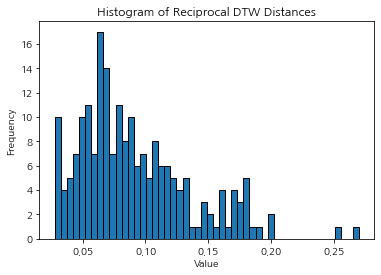

In [82]:
# Plotting the histogram
plt.hist(distances, bins=50, edgecolor='black')
plt.title('Histogram of Reciprocal DTW Distances')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [133]:
import pickle

# Save the dictionary to a pickle file
with open('NHIS_BDC_2023/Round2/nested_reciprocal_dtw_distances.pkl', 'wb') as file:
    pickle.dump(nested_reciprocal_dtw_distances, file)

## b. 주가, 거래량, 재무제표

### 나스닥 기업

#### 주가, 거래량

- NASDAQ_close_volume.csv로 저장

In [85]:
import pandas as pd

df = pd.read_csv('NHIS_BDC_2023/Round1/NASDAQ_DT_FC_STK_QUT.csv')
df.head()

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,20230103,NVDA,148.5100,149.9600,140.9600,143.1500,40127658.0,0.0,0.0
1,20230103,APLT,0.7535,0.7900,0.7308,0.7522,63714.0,19658.0,44056.0
2,20230103,ANY,1.8900,2.0293,1.8354,1.9600,24896.4,0.0,0.0
3,20230103,CLRB,1.6600,1.7200,1.6300,1.6300,21212.0,16444.0,4768.0
4,20230103,NYMTM,18.4300,18.7400,18.4300,18.7000,8061.0,0.0,0.0


In [86]:
df = df[['trd_dt', 'tck_iem_cd', 'gts_iem_end_pr', 'gts_acl_trd_qty']]
df.shape

(455338, 4)

In [87]:
df = df[(df['trd_dt'] >= 20230601) & (df['trd_dt'] <= 20230831)]
df.reset_index(inplace=True, drop=True)
df.rename(columns={'trd_dt': 'Date', 'tck_iem_cd': 'Ticker', 'gts_iem_end_pr' : 'Close', 'gts_acl_trd_qty' : 'Volume'}, inplace=True)
df

,Date,Ticker,Close,Volume
0,20230601,CPSI,24.5400,58110.0
1,20230601,IKNA,6.6700,63316.0
2,20230601,MOTS,0.6600,46838.0
3,20230601,ICU,0.5496,180951.0
4,20230601,TRKA,3.8000,7733558.0
...,...,...,...,...
172804,20230830,BLZE,5.8600,443470.0
172805,20230830,ELDN,1.4900,13462.0
172806,20230830,BMBL,16.3200,1030250.0
172807,20230830,PLRX,16.7100,319531.0


In [88]:
len(nasdaq_cp_list) #train + test

542

In [89]:
us_stock = df[df['Ticker'].isin(nasdaq_cp_list)]
us_stock['Ticker'].nunique()

542

In [14]:
us_stock.to_csv('NHIS_BDC_2023/Round2/NASDAQ_close_volume.csv', index=False)

#### 재무제표

- NASDAQ_financials.csv로 저장

In [90]:
import yfinance as yf
import pandas as pd

def financial(tickers):
    data_list = []
    error_tickers = []

    for symbol in tickers:
        try:
            stock_data = yf.Ticker(symbol)

            # 분기별 손익계산서 데이터 가져오기
            income_stmt = stock_data.quarterly_income_stmt.T

            first_index_date = income_stmt.index[0]

            # Check if the month is either 6 (June) or 7 (July)
            if first_index_date.month in [6, 7]:
                selected_index = income_stmt.index[1] #3, 4월
                next_quarter = income_stmt.index[0] 
            else:
                selected_index = income_stmt.index[2]
                next_quarter = income_stmt.index[1] 

            # 1분기 매출액
            try:
                total_revenue_3 = income_stmt.loc[selected_index, 'Total Revenue'] or None
            except:
                total_revenue_3 = None
            # 2분기 매출액
            try:
                total_revenue_6 = income_stmt.loc[next_quarter, 'Total Revenue']
            except:
                total_revenue_6 = None
            # EBITDA
            try:
                ebitda = income_stmt.loc[next_quarter, 'EBITDA']
            except:
                ebitda = None
            # 순이익
            try:
                net_income = income_stmt.loc[next_quarter, 'Net Income']
            except:
                net_income = None

            # 분기별 재무상태표 데이터 가져오기
            balance_sheet = stock_data.quarterly_balance_sheet.T

            first_index_date_balance = balance_sheet.index[0]

            # Check if the month is either 6 (June) or 7 (July) for balance sheet
            if first_index_date_balance.month in [6, 7]:
                selected_index_balance = balance_sheet.index[1]
                next_quarter_balance = balance_sheet.index[0]
            else:
                selected_index_balance = balance_sheet.index[2]
                next_quarter_balance = balance_sheet.index[1]

            # 총부채
            try:
                total_debt = balance_sheet.loc[next_quarter_balance, 'Total Debt'] 
            except:
                total_debt = None
            # 1분기 총자산
            try:
                total_assets_3 = balance_sheet.loc[selected_index_balance, 'Total Assets']
            except:
                total_assets_3 = None
            # 2분기 총자산
            try:
                total_assets_6 = balance_sheet.loc[next_quarter_balance, 'Total Assets']
            except:
                total_assets_6 = None
            # 총자본
            try:
                total_capitalization = balance_sheet.loc[next_quarter_balance, 'Total Capitalization']
            except:
                total_capitalization = None
            
            data = {
                'Ticker': symbol,
                'Total Revenue_3': total_revenue_3,
                'Total Revenue_6': total_revenue_6,
                'EBITDA': ebitda,
                'Net Income': net_income,
                'Total Debt': total_debt,
                'Total Assets_3': total_assets_3,
                'Total Assets_6': total_assets_6,
                'Total Capitalization': total_capitalization
            }

            # 데이터 리스트에 추가
            data_list.append(data)
            
        except Exception as e:
            print(f"Error for {symbol}: {e}")
            error_tickers.append(symbol)
            # 예외가 발생하면 결측치로 처리
            data = {'Ticker': symbol}
            for col in ['Total Revenue_3', 'Total Revenue_6', 'EBITDA', 'Net Income',
                        'Total Debt', 'Total Assets_3', 'Total Assets_6', 'Total Capitalization']:
                data[col] = float('nan')

            pass

    # 데이터 리스트를 DataFrame으로 변환
    df = pd.DataFrame(data_list)

    return df, error_tickers

In [ ]:
#나스닥 기업

train_cp_list = ['BKR', 'NSSC', 'GEVO', 'AAOI', 'LAZR', 'FGEN', 'TSLA', 'UFPI', 'VRSN', 'ALKS', 'AVAV', 'JBLU', 'EVRG', 'ODFL', 'HAIN', 'FFIE', 'SLAB', 'DHC', 'AHCO', 'INSE', 'CINF', 'PTVE', 'ADI', 'ACAD', 'CHX', 'BOOM', 'CRSP', 'SWKS', 'SITM', 'WIX', 'ASRT', 'BASE', 'FSTR', 'POWI', 'DDOG', 'UCTT', 'ZS', 'AVTA', 'FTAI', 'GAMB', 'CENX', 'ABCM', 'PARA', 'SPLK', 'KLIC', 'UAL', 'SEDG', 'RPD', 'PRFT', 'RMTI', 'SGEN', 'WBD', 'NDSN', 'BRZE', 'VKTX', 'FOLD', 'MRTX', 'ASUR', 'AMEH', 'SWBI', 'AVID', 'EZPW', 'QRVO', 'RGEN', 'NDAQ', 'BLFS', 'MCFT', 'LANC', 'JACK', 'SYNH', 'SSB', 'JBHT', 'QFIN', 'HDSN', 'ISRG', 'RIVN', 'DAWN', 'AMBA', 'TTGT', 'FCNCA', 'GERN', 'QDEL', 'MRNA', 'VLY', 'JD', 'BBIO', 'IONS', 'COST', 'EDIT', 'EBIX', 'HIMX', 'OLLI', 'RMBL', 'HZNP', 'GILD', 'REYN', 'CHTR', 'NCNO', 'OLED', 'KDP', 'GLPI', 'IQ', 'SHOO', 'HRMY', 'MKSI', 'CSIQ', 'PETS', 'ATVI', 'CDW', 'KROS', 'BAND', 'AMTX', 'STAA', 'EVLV', 'TIO', 'LGND', 'AFRM', 'BRKR', 'CLSK', 'SCPL', 'DNLI', 'COLM', 'MRNS', 'HALO', 'PI', 'MMYT', 'CMBM', 'ASO', 'PTLO', 'HST', 'RGLD', 'ICFI', 'NTES', 'CHRD', 'MULN', 'OPK', 'LI', 'ALEC', 'NXST', 'TW', 'RMBS', 'GO', 'RKDA', 'NKTR', 'TXRH', 'TVTX', 'IRDM', 'TARS', 'ROIV', 'MLCO', 'VRDN', 'ROST', 'ADAP', 'ALNY', 'GFS', 'TECH', 'FELE', 'DBX', 'TRUE', 'EXLS', 'URBN', 'DLTR', 'CGNX', 'URGN', 'AGEN', 'EXEL', 'CAKE', 'WDAY', 'SAVA', 'SBUX', 'ADSK', 'NBIX', 'ZYME', 'BKNG', 'EOLS', 'BPMC', 'AUR', 'CMCSA', 'VRNS', 'SIMO', 'NWL', 'PLUG', 'MBLY', 'ALHC', 'SATS', 'CG', 'SNPS', 'POOL', 'FLYW', 'SPTN', 'ADMA', 'ALGT', 'BRY', 'GNTX', 'VREX', 'ABNB', 'HBAN', 'NVAX', 'ONB', 'FWONA', 'GOEV', 'GEN', 'BZ', 'MGNI', 'RUSHA', 'TCOM', 'MYGN', 'CHK', 'ETSY', 'AAL', 'VERX', 'ATSG', 'VRA', 'ANIP', 'ODP', 'FATE', 'GSM', 'TGTX', 'BECN', 'STLD', 'OSIS', 'MNDY', 'IMMR', 'JAKK', 'CVLT', 'CHDN', 'ULTA', 'PRGS', 'NXPI', 'PANW', 'VIAV', 'CRSR', 'SP', 'KRT', 'SYNA', 'PECO', 'OTLY', 'SND', 'COMM', 'AMSC', 'LFUS', 'KYMR', 'MRVL', 'IEP', 'LULU', 'HOLX', 'CROX', 'HA', 'BNTX', 'FIVN', 'AEIS', 'IMGN', 'MAR', 'SYM', 'GPRO', 'HEES', 'EXPE', 'AMAT', 'SAGE', 'NATI', 'COIN', 'WOOF', 'HELE', 'INCY', 'SSNC', 'CFLT', 'VRTX', 'TWST', 'NSTG', 'VRSK', 'PAA', 'GRAB', 'MQ', 'DTIL', 'MU', 'UTHR', 'ARCT', 'NTRS', 'CEG', 'WWD', 'RKLB', 'HAS', 'PAGP', 'JAZZ', 'PBYI', 'COHU', 'FLNC', 'SMTC', 'HIBB', 'GDRX', 'ADPT', 'KPTI', 'LQDA', 'IOVA', 'BYND', 'CPRX', 'CSX', 'CONN', 'ADUS', 'EXTR', 'APPS', 'QCOM', 'PSNY', 'CSGP', 'GIII', 'ACHC', 'STGW', 'MIDD', 'NTLA', 'QURE', 'VIR', 'MXL', 'KFRC', 'SEAT', 'IAS', 'HON', 'ADTN', 'CDLX', 'OMGA', 'ITCI', 'INFN', 'ANDE', 'TMUS', 'MGRC', 'HURN', 'LWAY', 'STOK', 'FLEX', 'RUN', 'PDD', 'NTRA', 'ZNTL', 'LNT', 'MRSN', 'SIRI', 'CMLS', 'UPWK', 'NEXT', 'ORGO', 'HEAR', 'HPK', 'INDI', 'VERV', 'LINC', 'SCVL', 'CERT', 'CTAS', 'WW', 'CRDO', 'DOMO', 'MEDP', 'FAT', 'ARVN', 'GT', 'SNEX', 'GOOD', 'BL', 'AMSWA', 'SGRY', 'CCOI', 'AMZN', 'HUBG', 'CABA', 'DKNG', 'EYE', 'ONEW', 'FSLR', 'PLXS', 'VC', 'CRWD', 'TPG', 'DENN', 'FTNT', 'DXCM', 'RRGB', 'TTWO', 'LBTYA', 'BEAM', 'AVGO', 'WERN', 'AMRN', 'BANR', 'SAIA', 'HCCI', 'ASND', 'EEFT', 'ENSG', 'ICLR', 'FITB', 'SONO', 'WSBC', 'RNW', 'ADEA', 'PTON', 'GDS', 'CALM', 'PAYO', 'DNUT', 'LOCO', 'CCEP', 'PIRS', 'FRPT', 'ZION', 'TWNK', 'FIVE', 'AMPH', 'DUOL', 'BJRI', 'WB', 'APLS', 'SPWR', 'SCHL', 'TEAM', 'EXAS', 'RPRX', 'HTHT', 'BLUE', 'META', 'HCP', 'GH', 'PENN', 'MNKD', 'ATEC', 'RTL', 'LPLA', 'ROKU', 'MAT', 'ACLX', 'CNXC', 'ORLY', 'TER', 'NFLX', 'ILMN', 'EGHT', 'CRUS', 'REAL', 'BILI', 'ANGI', 'RXRX', 'VTNR', 'ITRI', 'ALGN', 'HSIC', 'CSWC', 'PATK', 'TROW', 'WDFC', 'TSCO', 'PEP', 'CHKP', 'BCRX', 'MATW', 'NKLA', 'ROP', 'CWST', 'TTEK', 'CAR', 'LRCX', 'VSAT', 'ICUI', 'SDGR', 'DISH', 'LITE', 'AMED', 'IPAR', 'EBAY', 'ZM', 'KLAC', 'SSYS', 'IDXX', 'PUBM', 'ZLAB', 'SNCY', 'HTZ', 'AMGN', 'TRMB', 'BSY', 'RILY', 'SDIG', 'RMR', 'AKBA', 'WYNN', 'EVER', 'BWEN', 'CRBU', 'NTNX', 'FAST', 'PTC', 'AAPL', 'RXT', 'ALDX', 'ARAY', 'VSTM', 'SNBR', 'EXC', 'MVIS', 'HCSG', 'IRBT', 'ON', 'UPBD']
test_cp_list = ['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']
nasdaq_cp_list = train_cp_list + test_cp_list

financial_df, error_tickers = financial(nasdaq_cp_list)

# 결과 출력
financial_df

In [ ]:
financial_df.to_csv("NHIS_BDC_2023/Round2/NASDAQ_financials.csv", index=False)

### 국내 기업

#### 주가, 거래량

- FinanceDataReader 활용
- KS_close_volume.csv

In [17]:
#!pip install -U finance-datareader

  Attempting uninstall: finance-datareader
    Found existing installation: finance-datareader 0.9.50
    Uninstalling finance-datareader-0.9.50:
      Successfully uninstalled finance-datareader-0.9.50


In [92]:
import FinanceDataReader as fdr

In [93]:
def get_stock_data(ticker_list, start_date, end_date):
    # 두 개의 티커에 대한 데이터를 각각 가져와서 리스트에 저장
    data_list = [fdr.DataReader(ticker, start=start_date, end=end_date).reset_index() for ticker in ticker_list]

    # 데이터프레임 초기화
    ks_stock = pd.DataFrame(columns=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change'])

    # 가져온 데이터를 데이터프레임에 추가
    for ticker, data in zip(ticker_list, data_list):
        data['Ticker'] = ticker  # 티커 정보 추가
        ks_stock = ks_stock.append(data, ignore_index=True)

    ks_stock = ks_stock[['Date', 'Ticker', 'Close', 'Volume']]

    return ks_stock

In [95]:
korea_related_dict = pd.read_pickle("NHIS_BDC_2023/Round2/korea_related_nasdaq_dict.pkl")
ks_ticker = list(korea_related_dict.keys())
len(ks_ticker)

128

In [97]:
print(ks_ticker[:10])

['207940', '125210', '009900', '066970', '348370', '003550', '005930', '032940', '005380', '178320']


In [27]:
# 함수 호출
ticker_list = ks_ticker
start_date = '2023-06-01'
end_date = '2023-08-30'

result_df = get_stock_data(ticker_list, start_date, end_date)

# 결과 출력
result_df.head()

,Date,Ticker,Close,Volume
0,2023-06-01,207940,788000,53996
1,2023-06-02,207940,785000,40298
2,2023-06-05,207940,785000,32742
3,2023-06-07,207940,786000,55002
4,2023-06-08,207940,785000,56800


In [28]:
result_df.isnull().sum()

Date      0
Ticker    0
Close     0
Volume    0
dtype: int64

In [29]:
result_df['Ticker'].nunique()

125

In [34]:
#주가 수집 안 된 기업
result_ticker = list(result_df['Ticker'])
difference = list(set(ks_ticker) - set(result_ticker))
print(difference)

['046110', '056000', '194510']


In [33]:
result_df.to_csv('NHIS_BDC_2023/Round2/KS_close_volume.csv', index=False)

#### 재무제표

- KOSPI_financials.csv
- KOSDAQ_financials_merged.csv

##### 코스피 기업

In [1]:
import yfinance as yf
import pandas as pd

def financial(tickers): ###yfinance
    data_list = []
    error_tickers = []

    for symbol in tickers:
        try:
            stock_data = yf.Ticker(symbol)

            # 분기별 손익계산서 데이터 가져오기
            income_stmt = stock_data.quarterly_income_stmt.T

            first_index_date = income_stmt.index[0]

            # Check if the month is either 6 (June) or 7 (July)
            if first_index_date.month in [6, 7]:
                selected_index = income_stmt.index[1] #3, 4월
                next_quarter = income_stmt.index[0] 
            else:
                selected_index = income_stmt.index[2]
                next_quarter = income_stmt.index[1] 

            # 1분기 매출액
            try:
                total_revenue_3 = income_stmt.loc[selected_index, 'Total Revenue'] or None
            except:
                total_revenue_3 = None
            # 2분기 매출액
            try:
                total_revenue_6 = income_stmt.loc[next_quarter, 'Total Revenue']
            except:
                total_revenue_6 = None
            # EBITDA
            try:
                ebitda = income_stmt.loc[next_quarter, 'EBITDA']
            except:
                ebitda = None
            # 순이익
            try:
                net_income = income_stmt.loc[next_quarter, 'Net Income']
            except:
                net_income = None

            # 분기별 재무상태표 데이터 가져오기
            balance_sheet = stock_data.quarterly_balance_sheet.T

            first_index_date_balance = balance_sheet.index[0]

            # Check if the month is either 6 (June) or 7 (July) for balance sheet
            if first_index_date_balance.month in [6, 7]:
                selected_index_balance = balance_sheet.index[1]
                next_quarter_balance = balance_sheet.index[0]
            else:
                selected_index_balance = balance_sheet.index[2]
                next_quarter_balance = balance_sheet.index[1]

            # 총부채
            try:
                total_debt = balance_sheet.loc[next_quarter_balance, 'Total Debt'] 
            except:
                total_debt = None
            # 1분기 총자산
            try:
                total_assets_3 = balance_sheet.loc[selected_index_balance, 'Total Assets']
            except:
                total_assets_3 = None
            # 2분기 총자산
            try:
                total_assets_6 = balance_sheet.loc[next_quarter_balance, 'Total Assets']
            except:
                total_assets_6 = None
            # 총자본
            try:
                total_capitalization = balance_sheet.loc[next_quarter_balance, 'Total Capitalization']
            except:
                total_capitalization = None
            
            data = {
                'Ticker': symbol,
                'Total Revenue_3': total_revenue_3,
                'Total Revenue_6': total_revenue_6,
                'EBITDA': ebitda,
                'Net Income': net_income,
                'Total Debt': total_debt,
                'Total Assets_3': total_assets_3,
                'Total Assets_6': total_assets_6,
                'Total Capitalization': total_capitalization
            }

            # 데이터 리스트에 추가
            data_list.append(data)
            
        except Exception as e:
            print(f"Error for {symbol}: {e}")
            error_tickers.append(symbol)
            # 예외가 발생하면 결측치로 처리
            data = {'Ticker': symbol}
            for col in ['Total Revenue_3', 'Total Revenue_6', 'EBITDA', 'Net Income',
                        'Total Debt', 'Total Assets_3', 'Total Assets_6', 'Total Capitalization']:
                data[col] = float('nan')

            pass

    # 데이터 리스트를 DataFrame으로 변환
    df = pd.DataFrame(data_list)

    return df, error_tickers

In [2]:
#국내 기업
korean_cp_list = ['207940', '009900', '348370', '066970', '125210', '005930', '005380', '003550', '032940', '178320', '006400', '271980', '053210', '121800', '017370', '033170', '012450', '028300', '004370', '005610', '006880', '003680', '013890', '004410', '017810', '250000', '099520', '376190', '000100', '040910', '009150', '000660', '005690', '042670', '189300', '003090', '034730', '237690', '014680', '139480', '101930', '096640', '000270', '222800', '000990', '004800', '302440', '091810', '000230', '118990', '012860', '094170', '077360', '066570', '011070', '355150', '353200', '067310', '034020', '208850', '073240', '161390', '111110', '111770', '095610', '004170', '047040', '036530', '064960', '064520', '052900', '001250', '081660', '030200', '012330', '032640', '051910', '020000', '037460', '229640', '361670', '025560', '120110', '036570', '214320', '241840', '215360', '046110', '010140', '003300', '007810', '069540', '000670', '192080', '123570', '123420', '330860', '068050', '408900', '038290', '001740', '013360', '003490', '012690', '065370', '002020', '046890', '263600', '148150', '194510', '139670', '154040', '007460', '056000', '208640', '003060', '047050', '317530', '091700', '204320', '123010', '005870', '016250', '396270', '018260', '348210', '033050', '038540']

# Append ".KS" to each item in the list
korean_cp_list = [symbol + ".KS" for symbol in korean_cp_list]

# Print the updated list 
print(len(korean_cp_list))

financial_df, error_tickers = financial(korean_cp_list)

128
Error for 348370.KS: index 0 is out of bounds for axis 0 with size 0
Error for 066970.KS: index 0 is out of bounds for axis 0 with size 0
Error for 125210.KS: index 0 is out of bounds for axis 0 with size 0
Error for 032940.KS: index 0 is out of bounds for axis 0 with size 0
Error for 121800.KS: index 0 is out of bounds for axis 0 with size 0
Error for 033170.KS: index 0 is out of bounds for axis 0 with size 0
Error for 028300.KS: index 0 is out of bounds for axis 0 with size 0
Error for 099520.KS: index 0 is out of bounds for axis 0 with size 0
Error for 376190.KS: index 0 is out of bounds for axis 0 with size 0
Error for 040910.KS: index 0 is out of bounds for axis 0 with size 0
Error for 189300.KS: index 0 is out of bounds for axis 0 with size 0
Error for 237690.KS: index 0 is out of bounds for axis 0 with size 0
Error for 101930.KS: index 0 is out of bounds for axis 0 with size 0
Error for 096640.KS: index 0 is out of bounds for axis 0 with size 0
Error for 222800.KS: index 0 i

검색 결과, 코스피 기업의 재무제표는 yfinance에 있으나 코스닥 기업의 정보는 없다는 사실을 알아냄. 

코스닥 기업의 정보를 DART API로 따로 수집하기로 함.

In [3]:
financial_df.isna().sum()

Ticker                  0
Total Revenue_3         0
Total Revenue_6         0
EBITDA                  0
Net Income              0
Total Debt              1
Total Assets_3          0
Total Assets_6          0
Total Capitalization    0
dtype: int64

In [17]:
financial_df.to_csv("NHIS_BDC_2023/Round2/KOSPI_financials.csv", index=False)

##### 코스닥 기업

In [ ]:
# !pip install OpenDartReader

In [4]:
import pandas as pd
import numpy as np
import OpenDartReader

#연결재무제표 기준

### 0. 객체 생성 ###

#api_key = 'my_api_key'  #api key로 대체

dart = OpenDartReader(api_key)


def financial_korea(ticker_code_list, year, reprt_code): 
    # 최종 데이터를 저장할 빈 데이터프레임 생성
    final_dataframe = pd.DataFrame(columns=['종목코드', '분기', '자산총계', '부채총계', '자본총계', '매출액', '당기순이익', '영업이익', '감가상각비', '무형자산상각비'])

    for code in ticker_code_list:
        try:
            # 기본 재무 정보 조회
            report = dart.finstate(code, year, reprt_code=reprt_code)
            basic_data = report[(report['fs_div'] == 'CFS') & (report['account_nm'].isin(['자산총계', '부채총계', '자본총계', '매출액', '당기순이익', '영업이익']))][['account_nm', 'thstrm_amount']]
            
            # 추가 재무 정보 조회
            report_all = dart.finstate_all(code, year, reprt_code=reprt_code, fs_div='CFS')
            additional_data = report_all[report_all['account_nm'].isin(['감가상각비', '무형자산상각비'])][['account_nm', 'thstrm_amount']]
            
            # 데이터 병합 및 정리
            combined_data = pd.concat([basic_data, additional_data]).pivot_table(index=None, columns='account_nm', values='thstrm_amount', aggfunc='first').reset_index(drop=True)
            combined_data['종목코드'] = code
            combined_data['분기'] = f"{year}/{reprt_code}"

            # 최종 데이터프레임에 추가
            final_dataframe = pd.concat([final_dataframe, combined_data])
        except Exception as e:
            print(f"Error processing {code}: {e}")
            # 오류가 발생한 경우 해당 종목코드에 대한 행을 NaN으로 채워 추가
            nan_data = pd.DataFrame([[code, f"{year}/{reprt_code}", np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]], columns=final_dataframe.columns)
            final_dataframe = pd.concat([final_dataframe, nan_data])

    # 누락된 항목은 NaN으로 처리
    final_dataframe.fillna(np.nan, inplace=True)

    return final_dataframe

In [9]:
error_tickers = [ticker.replace(".KS", "") for ticker in error_tickers]
print(error_tickers)

['348370', '066970', '125210', '032940', '121800', '033170', '028300', '099520', '376190', '040910', '189300', '237690', '101930', '096640', '222800', '118990', '012860', '094170', '077360', '355150', '067310', '208850', '095610', '064520', '052900', '037460', '361670', '241840', '215360', '046110', '069540', '123570', '123420', '330860', '068050', '408900', '038290', '065370', '046890', '263600', '148150', '194510', '139670', '154040', '056000', '208640', '317530', '091700', '204320', '123010', '016250', '396270', '348210', '033050', '038540']


In [10]:
final_dataframe_1 = financial_korea(error_tickers, 2023, '11013') #1분기
final_dataframe_2 = financial_korea(error_tickers, 2023, '11012') #2분기

reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}

Error processing 125210: 'account_nm'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
{'status': '013', 'message': '조회된 데이타가 없습니다.'}

Error processing 376190: 'account_nm'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='11013', fs_div='CFS' (1분기보고서, 연결제무제표)'
reprt_code='

In [11]:
final_dataframe_1.shape

(55, 10)

In [12]:
final_dataframe_2.shape

(55, 10)

In [13]:
final_dataframe_1.isna().sum()

종목코드        0
분기          0
자산총계       10
부채총계       10
자본총계       10
매출액        11
당기순이익      11
영업이익       10
감가상각비      44
무형자산상각비    45
dtype: int64

In [18]:
final_dataframe_1.head()

,종목코드,분기,자산총계,부채총계,자본총계,매출액,당기순이익,영업이익,감가상각비,무형자산상각비
0,348370,2023/11013,"707,214,724,925","408,509,731,265","298,704,993,660","145,451,499,942","-2,040,964,505","14,911,766,494",NaN,NaN
0,066970,2023/11013,"3,475,933,036,762","2,222,088,981,140","1,253,844,055,622","1,362,916,508,945","-16,076,573,277","40,409,972,766",9384237424,429190335
0,125210,2023/11013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,032940,2023/11013,"381,652,553,888","123,633,214,375","258,019,339,513","31,632,735,685","2,953,218,347","3,842,593,288",NaN,NaN
0,121800,2023/11013,"713,841,057,461","140,376,323,708","573,464,733,753","3,023,596,064","2,074,195,265","-794,785,166",NaN,NaN


In [16]:
final_dataframe_2.isna().sum()

종목코드        0
분기          0
자산총계       11
부채총계       11
자본총계       11
매출액        12
당기순이익      13
영업이익       11
감가상각비      45
무형자산상각비    45
dtype: int64

In [19]:
final_dataframe_2.head()

,종목코드,분기,자산총계,부채총계,자본총계,매출액,당기순이익,영업이익,감가상각비,무형자산상각비
0,348370,2023/11012,"846,204,206,075","515,356,025,694","330,848,180,381","116,954,621,530","13,127,438,603","7,535,121,348",NaN,NaN
0,066970,2023/11012,"4,068,398,792,257","2,723,741,027,038","1,344,657,765,219","1,368,186,148,883","49,409,636,837","2,993,240,723",19856073915,1015831593
0,125210,2023/11012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,032940,2023/11012,"377,265,473,332","119,945,476,440","257,319,996,892","36,486,673,996","-514,958,217","3,542,181,114",NaN,NaN
0,121800,2023/11012,"661,918,698,431","89,255,624,191","572,663,074,240","2,236,449,845","-4,097,172,815","-2,552,790,992",NaN,NaN


In [20]:
import pandas as pd

# Example merge operation
merged_dataframe = pd.merge(final_dataframe_1, final_dataframe_2, on='종목코드', suffixes=('3', '6'))
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   종목코드      55 non-null     object
 1   분기3       55 non-null     object
 2   자산총계3     45 non-null     object
 3   부채총계3     45 non-null     object
 4   자본총계3     45 non-null     object
 5   매출액3      44 non-null     object
 6   당기순이익3    44 non-null     object
 7   영업이익3     45 non-null     object
 8   감가상각비3    11 non-null     object
 9   무형자산상각비3  10 non-null     object
 10  분기6       55 non-null     object
 11  자산총계6     44 non-null     object
 12  부채총계6     44 non-null     object
 13  자본총계6     44 non-null     object
 14  매출액6      43 non-null     object
 15  당기순이익6    42 non-null     object
 16  영업이익6     44 non-null     object
 17  감가상각비6    10 non-null     object
 18  무형자산상각비6  10 non-null     object
dtypes: object(19)
memory usage: 8.6+ KB


In [21]:
merged_dataframe.to_csv("NHIS_BDC_2023/Round2/KOSDAQ_financials_merged.csv", index=False)

## c. 개인투자자

- df_01001.csv 생성
- NASDAQ_CUS_RATIO.csv
- KS_CUS_RATIO.csv

In [128]:
column_names = ['BSE_DT', 'IEM_CD', 'CUS_CGR_LLF_CD', 'CUS_CGR_MLF_CD', 'HLD_IEM_RNK_BSE_CD', 'HLD_BSE_IEM_CD', 'HLD_BSE_IEM_RNK']
date_cols = ['BSE_DT']
int_cols = ['CUS_CGR_LLF_CD', 'CUS_CGR_MLF_CD', 'HLD_IEM_RNK_BSE_CD', 'HLD_BSE_IEM_RNK']
object_cols = ['IEM_CD', 'HLD_BSE_IEM_CD']

#메모리 사용량 줄이기 위해 int 열을 category로 불러옴
dtype_dict = {col: 'category' for col in int_cols}
dtype_dict

{'CUS_CGR_LLF_CD': 'category',
 'CUS_CGR_MLF_CD': 'category',
 'HLD_IEM_RNK_BSE_CD': 'category',
 'HLD_BSE_IEM_RNK': 'category'}

In [129]:
df = pd.read_csv("NHIS_BDC_2023/Round2/BigConDataset/NHIS_BDC_NHDATA_CUS_TP_HLD_IEM", names=column_names, dtype=dtype_dict, parse_dates=date_cols, header=0)

In [130]:
#공백 제거
for col in df.select_dtypes(include=['object', 'string']).columns:
    df[col] = df[col].str.strip()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79682177 entries, 0 to 79682176
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   BSE_DT              datetime64[ns]
 1   IEM_CD              object        
 2   CUS_CGR_LLF_CD      category      
 3   CUS_CGR_MLF_CD      category      
 4   HLD_IEM_RNK_BSE_CD  category      
 5   HLD_BSE_IEM_CD      object        
 6   HLD_BSE_IEM_RNK     category      
dtypes: category(4), datetime64[ns](1), object(2)
memory usage: 2.1+ GB


In [132]:
df.head()

,BSE_DT,IEM_CD,CUS_CGR_LLF_CD,CUS_CGR_MLF_CD,HLD_IEM_RNK_BSE_CD,HLD_BSE_IEM_CD,HLD_BSE_IEM_RNK
0,2023-05-02,A009160,01,012,002,A029530,5
1,2023-07-10,A009160,01,012,002,CNE100000N61,5
2,2023-04-20,A009160,02,023,002,A005930,1
3,2023-06-01,A009160,03,033,002,A006400,3
4,2023-07-31,A009160,02,021,002,A003490,4


In [133]:
#투자실력 대분류, 투자자수로 필터링
df_01001 = df[(df['CUS_CGR_LLF_CD']=="01") & (df['HLD_IEM_RNK_BSE_CD']=="001")]
df_01001.drop_duplicates(inplace=True)
df_01001.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7137987 entries, 814 to 79682174
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   BSE_DT              datetime64[ns]
 1   IEM_CD              object        
 2   CUS_CGR_LLF_CD      category      
 3   CUS_CGR_MLF_CD      category      
 4   HLD_IEM_RNK_BSE_CD  category      
 5   HLD_BSE_IEM_CD      object        
 6   HLD_BSE_IEM_RNK     category      
dtypes: category(4), datetime64[ns](1), object(2)
memory usage: 245.1+ MB


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [134]:
df_01001.isna().sum()

BSE_DT                0
IEM_CD                0
CUS_CGR_LLF_CD        0
CUS_CGR_MLF_CD        0
HLD_IEM_RNK_BSE_CD    0
HLD_BSE_IEM_CD        0
HLD_BSE_IEM_RNK       0
dtype: int64

In [135]:
df_01001.to_csv("NHIS_BDC_2023/Round2/개인투자자01001.csv", index=False)

- ticker_isin.csv

#### ticker로 isin 찾기

In [116]:
#df_01001에 ticker 열이 없는 관계로, nasdaq 기업들에 대한 ticker를 입력해서 isin을 크롤링해오는 코드

import requests
from lxml import html
import re

def fetch_ticker_content(ticker):
    xpath = '/html/body/div[1]/div[1]/div[2]/main/div[2]/div[2]/div[3]'
    try:
        url = f'https://stockanalysis.com/stocks/{ticker}/company/'
        response = requests.get(url)
        response.raise_for_status()

        tree = html.fromstring(response.content)
        content_element = tree.xpath(xpath)
        content_element = html.tostring(content_element[0])

        if content_element:
            # Use regex to find the ISIN
            match = re.search(r'[A-Z0-9]{12}', content_element.decode())
            if match:
                return match.group()
            else:
                return "ISIN code not found."

    except Exception as e:
        return f"Error fetching content: {e}"

In [140]:
len(nasdaq_cp_list)

542

In [ ]:
import time
import pandas as pd

nasdaq_isin_list_2 = []
nasdaq_code_df = pd.DataFrame(columns=['Ticker', 'ISIN'])

count = 0

for ticker in nasdaq_cp_list:
    count += 1
    isin = fetch_ticker_content(ticker)
    nasdaq_isin_list_2.append(isin)
    nasdaq_code_df = pd.concat([nasdaq_code_df, pd.DataFrame({'Ticker': [ticker], 'ISIN': [isin]})])
    
    #if count % 50 == 0:
    #   time.sleep(180)

print(nasdaq_isin_list_2)

In [201]:
nasdaq_code_df

,Ticker,ISIN
0,BKR,US05722G1004
0,NSSC,US6304021057
0,GEVO,US3743964062
0,AAOI,US03823U1025
0,LAZR,US5504241051
...,...,...
0,MSFT,Error fetching content: 429 Client Error: Too ...
0,SANM,Error fetching content: 429 Client Error: Too ...
0,SMCI,Error fetching content: 429 Client Error: Too ...
0,MPWR,Error fetching content: 429 Client Error: Too ...


In [221]:
#'too many requests' error가 뜨면, 해당 error가 뜨지 않을 때까지 해당 셀 반복 실행

#time.sleep(60)

incorrect_length_isins = [isin for isin in nasdaq_isin_list_2 if len(isin) != 12]
incorrect_indices = [nasdaq_isin_list_2.index(isin) for isin in incorrect_length_isins]

for index in incorrect_indices:
    ticker = nasdaq_cp_list[index]
    isin = fetch_ticker_content(ticker)
    nasdaq_isin_list_2[index] = isin  
    print(ticker, isin)

    nasdaq_code_df.loc[nasdaq_code_df['Ticker'] == ticker, 'ISIN'] = isin

    if (index + 1) % 50 == 0:
        time.sleep(60)

print(nasdaq_isin_list_2)

AVTA ISIN code not found.
SYNH Error fetching content: 404 Client Error: Not Found for url: https://stockanalysis.com/stocks/synh/company/
AVTA ISIN code not found.
PAA Error fetching content: 404 Client Error: Not Found for url: https://stockanalysis.com/stocks/paa/company/
HCCI Error fetching content: 404 Client Error: Not Found for url: https://stockanalysis.com/stocks/hcci/company/
AVTA ISIN code not found.
AVTA ISIN code not found.
['US05722G1004', 'US6304021057', 'US3743964062', 'US03823U1025', 'US5504241051', 'US31572Q8087', 'US88160R1014', 'US90278Q1085', 'US92343E1029', 'IE00B56GVS15', 'US0080731088', 'US4771431016', 'US30034W1062', 'US6795801009', 'US4052171000', 'US3073591097', 'US8269191024', 'US25525P1075', 'US00653Q1022', 'US45782N1081', 'US1720621010', 'US69526K1051', 'US0326541051', 'US0042251084', 'US15872M1045', 'US23291C1036', 'CH0334081137', 'US83088M1027', 'US82982T1060', 'IL0011301780', 'US04546C2052', 'US22207T1016', 'US3500601097', 'US7392761034', 'US23804L1035'

In [222]:
len(incorrect_length_isins)

7

In [227]:
nasdaq_code_df.to_csv("NHIS_BDC_2023/Round2/ticker_isin.csv", index=False)

#### 일별 관련 기업 비율 계산 함수 생성

In [223]:
def daily_isin_ratio(isin, df_01001):
    df_isin = df_01001[df_01001['HLD_BSE_IEM_CD'] == isin]

    # df_01001에서 'BSE_DT'별 'IEM_CD'의 고유 개수 계산
    unique_01001 = df_01001.groupby("BSE_DT")["IEM_CD"].nunique()

    # df_isin에서 'BSE_DT'별 'IEM_CD'의 고유 개수 계산
    unique_ticker = df_isin.groupby("BSE_DT")["IEM_CD"].nunique()

    # df_01001의 모든 'BSE_DT'를 기준으로 비율 계산
    ratio_df = pd.DataFrame(unique_01001).reset_index()
    ratio_df['UNIQUE_CP_COUNT'] = ratio_df['BSE_DT'].map(unique_ticker).fillna(0).astype(int)
    ratio_df['ALL_UNIQUE_CP_COUNT'] = ratio_df['BSE_DT'].map(unique_01001)
    ratio_df['RATIO'] = ratio_df['UNIQUE_CP_COUNT'] / ratio_df['ALL_UNIQUE_CP_COUNT']
    ratio_df['ISIN'] = isin
    ratio_df.drop('IEM_CD', axis=1, inplace=True)

    return ratio_df

#### NASDAQ 일반투자자 + 고수

In [237]:
#일반투자자+고수

combined_df = pd.DataFrame()

for i in range(len(nasdaq_code_df)):
    ticker = nasdaq_code_df.iloc[i, 0]
    isin = nasdaq_code_df.iloc[i, 1]
    ratio_df = daily_isin_ratio(isin, df_01001)
    ratio_df['TICKER'] = ticker
    combined_df = pd.concat([combined_df, ratio_df])

combined_df.to_csv("NHIS_BDC_2023/Round2/NASDAQ_CUS_RATIO.csv")

In [238]:
combined_df.head()

,BSE_DT,UNIQUE_CP_COUNT,ALL_UNIQUE_CP_COUNT,RATIO,ISIN,TICKER
0,2023-06-01,0,2403,0.000000,US05722G1004,BKR
1,2023-06-02,1,2406,0.000416,US05722G1004,BKR
2,2023-06-05,0,2411,0.000000,US05722G1004,BKR
3,2023-06-07,0,2405,0.000000,US05722G1004,BKR
4,2023-06-08,0,2408,0.000000,US05722G1004,BKR


In [239]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34146 entries, 0 to 62
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   BSE_DT               34146 non-null  datetime64[ns]
 1   UNIQUE_CP_COUNT      34146 non-null  int64         
 2   ALL_UNIQUE_CP_COUNT  34146 non-null  int64         
 3   RATIO                34146 non-null  float64       
 4   ISIN                 34146 non-null  object        
 5   TICKER               34146 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [241]:
combined_df['TICKER'].nunique()

542

In [243]:
combined_df['ISIN'].nunique()

538

In [246]:
print(list(set(combined_df['ISIN'])))

['US6541101050', 'US26210C1045', 'US14817C1071', 'US3024921039', 'US75629V1044', 'US63947X1019', 'US76655K1034', 'US5562691080', 'US3119001044', 'US48563L1017', 'US7291321005', 'US18452B2097', 'US85256A1097', 'US0537741052', 'US04546C2052', 'US8716071076', 'US9255501051', 'US5500211090', 'US03209R1032', 'US45253H1014', 'US20030N1019', 'US55024U1097', 'US22160K1051', 'US58506Q1094', 'US25470M1099', 'US55955D1000', 'US0079731008', 'US20717M1036', 'US11161T2078', 'US86800U1043', 'US7534221046', 'US53635D2027', 'US92335C1062', 'US46269C1027', 'US98980G1022', 'US4433201062', 'US86881A1007', 'US10576N1028', 'US03969T1097', 'US87151X1019', 'US91307C1027', 'US74838J1016', 'US2521311074', 'US0188021085', 'US09075V1026', 'US36237H1014', 'US74967R1068', 'US5335351004', 'US60770K1079', 'US4581401001', 'US40637H1095', 'US36467J1088', 'US92337C1045', 'US98138H1014', 'US8726571016', 'US0231112063', 'US09609G1004', 'US5854641009', 'US02376R1023', 'US12514G1085', 'US39874R1014', 'US4622221004', 'US4611

In [244]:
combined_df['RATIO'].value_counts().sort_values()

0.101193        1
0.007359        1
0.007010        1
0.007746        1
0.008903        1
            ...  
0.000414      117
0.000405      120
0.000407      183
0.000416      184
0.000000    24745
Name: RATIO, Length: 1652, dtype: int64

#### NASDAQ 고수

In [ ]:
df_011001 = df_01001[df_01001['CUS_CGR_MLF_CD']==11]
df_011001.shape

(2763827, 7)

In [272]:
combined_df = pd.DataFrame()

for i in range(len(nasdaq_code_df)):
    ticker = nasdaq_code_df.iloc[i, 0]
    isin = nasdaq_code_df.iloc[i, 1]
    ratio_df = daily_isin_ratio(isin, df_011001)
    ratio_df['TICKER'] = ticker
    combined_df = pd.concat([combined_df, ratio_df])

combined_df.to_csv("NHIS_BDC_2023/Round2/NASDAQ_CUS_RATIO_고수.csv", index=False)

#### 국내기업 일반투자자 + 고수

In [253]:
#국내 기업이 A로 시작한다는 점을 알 수 있음

import pandas as pd

extracted_letters = df_01001['HLD_BSE_IEM_CD'].str.extract(r'^([A-Za-z]+)')
extracted_letters.value_counts()

A       5269877
US      1351994
CNE      121356
KYG       75983
JP        63987
J         60907
Q         56963
CA        56930
MHY       24122
IL        13242
BMG        9642
VGG        5991
HK         4126
CH         4090
AU         3221
NL         3127
IE         3092
PA         3074
GB         1695
F          1054
JE          816
LU          727
SGXZ        393
KY          296
GG          233
CY          206
SG          163
IM          161
CAC          96
DE           80
VG           70
USX          60
IT           34
BE           29
LR           28
AN           25
MU           24
BSP          18
HKX          14
MX            9
HKEX          8
JCYM          7
PAP           6
PR            4
VI            4
FR            3
dtype: int64

In [100]:
#관련 국내 기업 128개
korean_cp_list = ['207940', '009900', '348370', '066970', '125210', '005930', '005380', '003550', '032940', '178320', '006400', '271980', '053210', '121800', '017370', '033170', '012450', '028300', '004370', '005610', '006880', '003680', '013890', '004410', '017810', '250000', '099520', '376190', '000100', '040910', '009150', '000660', '005690', '042670', '189300', '003090', '034730', '237690', '014680', '139480', '101930', '096640', '000270', '222800', '000990', '004800', '302440', '091810', '000230', '118990', '012860', '094170', '077360', '066570', '011070', '355150', '353200', '067310', '034020', '208850', '073240', '161390', '111110', '111770', '095610', '004170', '047040', '036530', '064960', '064520', '052900', '001250', '081660', '030200', '012330', '032640', '051910', '020000', '037460', '229640', '361670', '025560', '120110', '036570', '214320', '241840', '215360', '046110', '010140', '003300', '007810', '069540', '000670', '192080', '123570', '123420', '330860', '068050', '408900', '038290', '001740', '013360', '003490', '012690', '065370', '002020', '046890', '263600', '148150', '194510', '139670', '154040', '007460', '056000', '208640', '003060', '047050', '317530', '091700', '204320', '123010', '005870', '016250', '396270', '018260', '348210', '033050', '038540']
print(len(korean_cp_list))
korean_cp_list = ["A" + ticker for ticker in korean_cp_list]
korean_cp_list[:10]

128


['A207940',
 'A009900',
 'A348370',
 'A066970',
 'A125210',
 'A005930',
 'A005380',
 'A003550',
 'A032940',
 'A178320']

In [257]:
combined_df = pd.DataFrame()

for ticker in korean_cp_list:
    ratio_df = daily_isin_ratio(ticker, df_01001)
    ratio_df['TICKER'] = ticker
    combined_df = pd.concat([combined_df, ratio_df])

combined_df.head()

,BSE_DT,UNIQUE_CP_COUNT,ALL_UNIQUE_CP_COUNT,RATIO,ISIN,TICKER
0,2023-01-25,5,5512,0.000907,A207940,A207940
1,2023-01-26,7,5514,0.001269,A207940,A207940
2,2023-01-27,4,5518,0.000725,A207940,A207940
3,2023-01-30,1,5522,0.000181,A207940,A207940
4,2023-01-31,6,5527,0.001086,A207940,A207940


In [260]:
combined_df.drop('ISIN', axis=1, inplace=True)

In [261]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18944 entries, 0 to 147
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BSE_DT               18944 non-null  object 
 1   UNIQUE_CP_COUNT      18944 non-null  int64  
 2   ALL_UNIQUE_CP_COUNT  18944 non-null  int64  
 3   RATIO                18944 non-null  float64
 4   TICKER               18944 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 888.0+ KB


In [262]:
combined_df['TICKER'].nunique()

128

In [263]:
combined_df.to_csv("NHIS_BDC_2023/Round2/KS_CUS_RATIO.csv", index=False)

#### 국내기업 고수

In [271]:
combined_df = pd.DataFrame()

for ticker in korean_cp_list:
    ratio_df = daily_isin_ratio(ticker, df_011001)
    ratio_df['TICKER'] = ticker
    combined_df = pd.concat([combined_df, ratio_df])
    combined_df.drop('ISIN', axis=1, inplace=True)

combined_df.head()
combined_df.to_csv("NHIS_BDC_2023/Round2/KS_CUS_RATIO_고수.csv", index=False)

## d. RSS_IFO - FinBERT

In [106]:
import torch
import pandas as pd

In [107]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [117]:
#주식코드를 입력하면 NASDAQ 데이터프레임에서 관련 기사를 찾아주는 함수 - 위에서 정의
def find_rows_by_tck(nasdaq_df, stock_code):
    rows_to_append = []

    for i in range(len(nasdaq_df)):
        lst = nasdaq_df['all_tck_iem_cd'].iloc[i]
        lst = lst.replace('[', '')
        lst = lst.replace(']', '')
        lst = lst.replace("'", '')
        lst = lst.replace(" ", '')
        lst = lst.split(',')

        if stock_code in lst:
            a = nasdaq_df.iloc[i]
            rows_to_append.append(a)

    if rows_to_append:
        nasdaq_rows = pd.concat(rows_to_append, axis=1).T.reset_index(drop=True)
        return nasdaq_rows
    else:
        return pd.DataFrame()

In [124]:
#주어진 데이터프레임의 'text' 열에서 주식코드와 기업명을 포함한 문단을 추출
def get_relevant_paragraphs(nasdaq_row, stock_code, company_name):
    text = nasdaq_row['text']
    paragraphs = text.split('\n\n')
    relevant_paragraphs = [paragraph for paragraph in paragraphs if stock_code in paragraph or company_name in paragraph]
    relevant_paragraphs = '\n\n'.join(relevant_paragraphs)
    return relevant_paragraphs

#추출한 문단에 FinBERT 적용
def finbert(input_text):
    inputs = tokenizer(input_text, padding = True, truncation = True, return_tensors='pt')
    outputs = finbert_model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {
            "Text": input_text,
            "Positive":positive,
            "Negative":negative,
            "Neutral":neutral}

    score_row = pd.DataFrame(table, columns = ["Text", "Positive", "Negative", "Neutral"])

    return score_row

#위 함수들을 결합하여, 입력한 주식코드에 대한 핀버트 적용
def finbert_from_stock_code(nasdaq_df, stock_code):
    score_df = pd.DataFrame()
    nasdaq_rows = find_rows_by_tck(nasdaq_df, stock_code)

    if nasdaq_rows.empty:
        return score_df

    stock_info_df = pd.read_csv("NHIS_BDC_2023/Round1/stock_description.csv")
    company_name = stock_info_df[stock_info_df['tck_iem_cd'] == stock_code]['fc_sec_eng_nm'].iloc[0]

    for index, nasdaq_row in nasdaq_rows.iterrows():
        result = get_relevant_paragraphs(nasdaq_row, stock_code, company_name)
        score_row = finbert(result)

        score_row['rgs_dt'] = nasdaq_row['rgs_dt']
        score_row['all_tck_iem_cd'] = nasdaq_row['all_tck_iem_cd']
        score_row['til_ifo'] = nasdaq_row['til_ifo']

        score_df = pd.concat([score_df, score_row], ignore_index=True)

    cols = ['rgs_dt', 'all_tck_iem_cd', 'til_ifo'] + [col for col in score_df.columns if col not in ['rgs_dt', 'all_tck_iem_cd', 'til_ifo']]
    score_df = score_df[cols]

    score_df = score_df[score_df['Text'].str.len() > 0]

    return score_df

In [136]:
import os

def calculate_finbert_sentiments(nasdaq_df, company_list, mode):
    all_scores_df = pd.DataFrame()
    count = 0

    for company in company_list:
        count += 1
        num_articles = len(find_rows_by_tck(nasdaq_df, company))
        print(f'기업 {company}의 기사는 {num_articles}개입니다.')

        try:
            score_df = finbert_from_stock_code(nasdaq_df, company)
            score_df['Highest_Sentiment'] = score_df[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)
            score_df['TICKER'] = company  # Add company ticker to all_scores_df
            #score_df['Count'] = num_articles
            all_scores_df = pd.concat([all_scores_df, score_df])

        except IndexError as e:
            print(f"IndexError occurred for company {company}: {e}")

        # Save checkpoint every 100 iterations
        #display(all_scores_df)

        if count % 100 == 0:
            save_dir = os.path.join("NHIS_BDC_2023/Round2/", f'finbert_ckpt_{mode}')
            if not os.path.exists(save_dir):
                os.makedirs(save_dir, exists_ok=True)
            all_scores_df.to_csv(os.path.join(save_dir, f'all_scores_{count}_{mode}.csv'), index=False)
            print(f"{count}번째 기업까지 저장되었습니다.")

    all_scores_df.to_csv(os.path.join("NHIS_BDC_2023/Round2/", f'all_scores_{mode}.csv'), index=False)

    return all_scores_df

In [129]:
nasdaq_df = pd.read_csv("NHIS_BDC_2023/Round1/nasdaq_final.csv")
nasdaq_3months_df = nasdaq_df[nasdaq_df['rgs_dt']>=20230601]

In [141]:
print(test_cp_list)

['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']


In [ ]:
#파일명 all_scores_test.csv
all_scores_test = calculate_finbert_sentiments(nasdaq_3months_df, test_cp_list, mode='test')

In [ ]:
#파일명 all_scores_train.csv
all_scores_train = calculate_finbert_sentiments(nasdaq_3months_df, train_cp_list, mode='train')

In [87]:
all_scores_train = pd.read_csv("NHIS_BDC_2023/Round2/all_scores_train.csv")
all_scores_train.head()

,rgs_dt,all_tck_iem_cd,til_ifo,Text,Positive,Negative,Neutral,Highest_Sentiment,TICKER
0,20230621,"['MEDS', 'PIRS', 'ALDX', 'PTCT', 'AZN']",Health Care Sector Update for 06/21/2023: PIRS...,"In company news, Pieris Pharmaceuticals (PIRS)...",0.006852,0.974693,0.018455,Negative,PIRS
1,20230621,"['PDCO', 'XLV', 'PIRS', 'AZN', 'LMDX']",Health Care Sector Update for 06/21/2023: PIRS...,Pieris Pharmaceuticals' (PIRS) shares were she...,0.007015,0.972621,0.020364,Negative,PIRS
2,20230623,"['OMGA', 'AKRO', 'AZN', 'PIRS']",Pieris (PIRS) Declines as AZN Halts Study of A...,PierisPharmaceuticals’ PIRS shares plunged alm...,0.054972,0.365429,0.579599,Neutral,PIRS
3,20230719,"['ALKS', 'AZN', 'OMGA', 'PIRS']","Pieris (PIRS) Pursues Strategic Alternatives, ...",Pieris Pharmaceuticals’ PIRS shares were up al...,0.817025,0.008652,0.174322,Positive,PIRS
4,20230719,['PIRS'],Pieris Pharma Cuts Around 70% Workforce; Plans...,"(RTTNews) - Pieris Pharmaceuticals, Inc. (PIRS...",0.012390,0.958247,0.029363,Negative,PIRS


In [ ]:
all_scores_train['TICKER'].nunique()

# 2. 기업 점수 구하기

## a. 데이터프레임 생성

### 나스닥(train + test)

X
1) 개인투자자: 일반투자자+고수
2) 개인투자자: 고수
3) 주가 추세
4) 거래량 추세
5) FinBERT 평균
6) 재무제표

Y

주가 추세

#### 1. 개인투자자: 일반투자자 + 고수 | 2. 개인투자자: 고수 (평균 비율)

In [141]:
df1 = pd.read_csv("NHIS_BDC_2023/Round2/NASDAQ_CUS_RATIO.csv")
df2 = pd.read_csv("NHIS_BDC_2023/Round2/NASDAQ_CUS_RATIO_고수.csv")

In [151]:
cus_ratio_all = pd.merge(df1, df2, on=['BSE_DT', 'TICKER'], suffixes=['', '_expert'])

In [152]:
cus_ratio_all.columns

Index(['BSE_DT', 'UNIQUE_CP_COUNT', 'ALL_UNIQUE_CP_COUNT', 'RATIO', 'ISIN',
       'TICKER', 'UNIQUE_CP_COUNT_expert', 'ALL_UNIQUE_CP_COUNT_expert',
       'RATIO_expert', 'ISIN_expert'],
      dtype='object')

In [150]:
import pandas as pd

def mean_cus_ratio(cus_ratio_all):
    tickers = list(set(cus_ratio_all['TICKER']))

    # The specified date ranges
    date_ranges = [
        {'start_t': '2023-06-05', 'end_t': '2023-06-18', 'start_v': '2023-06-19', 'end_v': '2023-06-25'},
        {'start_t': '2023-06-26', 'end_t': '2023-07-09', 'start_v': '2023-07-10', 'end_v': '2023-07-16'},
        {'start_t': '2023-07-17', 'end_t': '2023-07-30', 'start_v': '2023-07-31', 'end_v': '2023-08-06'},
        {'start_t': '2023-08-07', 'end_t': '2023-08-20', 'start_v': '2023-08-21', 'end_v': '2023-08-27'}
    ]

    # Creating a new DataFrame to store results
    result_df = pd.DataFrame()

    # Loop through each ticker and date range
    for ticker in tickers:
        for dr in date_ranges:
            # Filter for each date range and calculate mean RATIO
            mean_ratio_t = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_t']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_t'])]['RATIO'].mean()

            mean_ratio_v = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_v']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_v'])]['RATIO'].mean()
            
            mean_ratio_expert_t = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_t']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_t'])]['RATIO_expert'].mean()

            mean_ratio_expert_v = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_v']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_v'])]['RATIO_expert'].mean()

            # Append results to the result_df
            result_df = result_df.append({'TICKER': ticker, 
                                          'start_t': dr['start_t'], 'end_t': dr['end_t'],
                                          'start_v': dr['start_v'], 'end_v': dr['end_v'],
                                          'mean_ratio_t': mean_ratio_t, 'mean_ratio_v': mean_ratio_v,
                                          'mean_ratio_expert_t': mean_ratio_expert_t, 'mean_ratio_expert_v': mean_ratio_expert_v},
                                         ignore_index=True)
    
    return result_df

In [153]:
result_df = mean_cus_ratio(cus_ratio_all)

In [163]:
result_df.to_csv("NHIS_BDC_2023/Round2/model_data/NASDAQ_mean_cus_ratio.csv", index=False)

#### 3. 주가 추세 | 4. 거래량 추세

In [1]:
import numpy as np
import pandas as pd

In [2]:
def trend_line(x, y):
    mu_x = np.average(x)
    mu_y = np.average(y)
    sum_xy = 0
    sum_x2 = 0
    for i in range(len(x)):
        sum_xy += (x[i]-mu_x)*(y[i]-mu_y)
        sum_x2 += (x[i]-mu_x)**2
        
    result = sum_xy / (sum_x2*mu_y)
    
    return result

In [3]:
df_sv = pd.read_csv("NHIS_BDC_2023/Round2/NASDAQ_close_volume.csv")

In [4]:
date = []
for i in range(30):
    date.append(2023*10000 + 6*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 7*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 8*100 + (i+1))

In [5]:
ticker_list = df_sv['Ticker'].unique().tolist()

stock_data_train = []
stock_data_valid = []
Vol_train = []
Vol_valid = []
start_date_train = []
end_date_train = []
start_date_valid = []
end_date_valid = []
company = []

for tick in ticker_list:
    exam_df3 = df_sv[df_sv['Ticker'] == tick]
    exam_df3.loc[:, 'month'] = (exam_df3['Date'] % 1000) // 100
    exam_df3.loc[:, 'day'] = exam_df3['Date'] % 100
    exam_df3.loc[:, 'time'] = (exam_df3['month'] - 6)*31 + exam_df3['day']
    exam_df3.reset_index(inplace = True, drop=True)
    
    for i in range(4):
        j = 21*(i)+5
        j1 = j+14
        h = 21*(i+1)+5
        xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        xv = [0, 1, 2, 3, 4]
        n_t = len(exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Close'])
        n_v = len(exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Close'])
        xt = xt[: n_t]
        xv = xv[: n_v]
        res_t = trend_line(xt, exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Close'].to_list())
        res_v = trend_line(xv, exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Close'].to_list())
        vol_t = trend_line(xt, exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Volume'].to_list())
        vol_v = trend_line(xv, exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Volume'].to_list())
        company.append(tick)
        Vol_train.append(vol_t)
        Vol_valid.append(vol_v)
        stock_data_train.append(res_t)
        stock_data_valid.append(res_v)
        start_date_train.append(date[j-1])
        start_date_valid.append(date[j1-1])
        end_date_train.append(date[j1-2])
        end_date_valid.append(date[h-1])

new_df = pd.DataFrame(zip(company, stock_data_train, stock_data_valid, Vol_train, Vol_valid, start_date_train, start_date_valid, end_date_train, end_date_valid), 
                      columns = ['Ticker','close_t', 'close_v', 'volume_t','volume_v','start_t', 'start_v', 'end_t', 'end_v'])
new_df.tail(n = 4)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Ticker,close_t,close_v,volumen_t,volume_v,start_t,start_v,end_t,end_v
2164,KTOS,-0.001815,-0.003816,0.054255,0.075128,20230605,20230619,20230618,20230626
2165,KTOS,-0.006804,-0.008537,-0.028602,0.089498,20230626,20230710,20230709,20230717
2166,KTOS,0.011669,0.015751,0.015716,0.347715,20230717,20230731,20230730,20230807
2167,KTOS,-0.013859,-0.001569,-0.105221,0.042637,20230807,20230821,20230820,20230828


#### 5. 재무제표

In [34]:
df = pd.read_csv('NHIS_BDC_2023/Round2/NASDAQ_financials.csv')
df

,Ticker,Total Revenue_3,Total Revenue_6,EBITDA,Net Income,Total Debt,Total Assets_3,Total Assets_6,Total Capitalization
0,BKR,5.716000e+09,6.315000e+09,9.480000e+08,4.100000e+08,6.644000e+09,3.504200e+10,3.609300e+10,2.110900e+10
1,NSSC,4.353200e+07,4.465800e+07,2.240000e+06,1.439000e+06,5.689000e+06,1.652820e+08,1.666540e+08,1.401690e+08
2,GEVO,4.060000e+06,4.238000e+06,-9.130000e+06,-1.442000e+07,6.981300e+07,6.886940e+08,6.745570e+08,5.831930e+08
3,AAOI,5.303000e+07,4.161500e+07,-9.568000e+06,-1.694400e+07,1.320850e+08,3.835510e+08,3.568770e+08,1.632590e+08
4,LAZR,1.450900e+07,1.619700e+07,-1.342320e+08,-1.417560e+08,6.365820e+08,6.583510e+08,5.997740e+08,4.846630e+08
...,...,...,...,...,...,...,...,...,...
534,MSFT,5.285700e+10,5.618900e+10,2.812800e+10,2.008100e+10,5.996500e+10,3.800880e+11,4.119760e+11,2.482130e+11
535,SANM,2.320103e+09,2.207118e+09,1.389680e+08,7.649400e+07,3.340520e+08,5.029456e+09,4.957892e+09,2.582280e+09
536,SMCI,1.283296e+09,2.184861e+09,2.287600e+08,1.935690e+08,2.903020e+08,3.192604e+09,3.674729e+09,2.092184e+09
537,MPWR,4.510650e+08,4.411280e+08,1.123250e+08,9.950400e+07,NaN,2.226651e+09,2.220620e+09,1.839089e+09


**재무재표 평가지표**
- 내재가치 : EBITDA
- 안정성 : 부채비율(총부채/총자산)
- 성장성 : 매출액증가율(현재 분기 총매출 - 전 분기 총매출 / 전 분기 총매출)
- 수익률 : ROE(순이익 / 총자본)
- 활동성 : 총자산회전율(총매출 / 평균 총자산)

In [36]:
# 새로운 데이터프레임 형성
NASDAQ_financials = pd.DataFrame()

# 티커코드
NASDAQ_financials['TICKER'] = df['Ticker']

# 1. 내재가치 컬럼 생성
NASDAQ_financials['EBITDA'] = df['EBITDA']

# 2. 안정성 컬럼 생성
NASDAQ_financials['부채비율'] = df['Total Debt'] / df['Total Assets_6']

# 3. 성장성 컬럼 생성
NASDAQ_financials['매출액증가율'] = (df['Total Revenue_6'] - df['Total Revenue_3']) / df['Total Revenue_3']

# 4. 수익률 컬럼 생성
NASDAQ_financials['ROE'] = df['Net Income'] / df['Total Capitalization']

# 5. 활동성 컬럼 생성
NASDAQ_financials['총자산회전율'] = df['Total Revenue_6'] / ((df['Total Assets_3'] + df['Total Assets_6']) / 2)

In [37]:
NASDAQ_financials

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,BKR,9.480000e+08,0.184080,0.104794,0.019423,0.177550
1,NSSC,2.240000e+06,0.034137,0.025866,0.010266,0.269076
2,GEVO,-9.130000e+06,0.103495,0.043842,-0.024726,0.006217
3,AAOI,-9.568000e+06,0.370114,-0.215256,-0.103786,0.112408
4,LAZR,-1.342320e+08,1.061370,0.116342,-0.292484,0.025748
...,...,...,...,...,...,...
534,MSFT,2.812800e+10,0.145555,0.063038,0.080902,0.141880
535,SANM,1.389680e+08,0.067378,-0.048698,0.029623,0.441983
536,SMCI,2.287600e+08,0.079000,0.702539,0.092520,0.636306
537,MPWR,1.123250e+08,NaN,-0.022030,0.054105,0.198381


In [38]:
NASDAQ_financials.to_csv('NHIS_BDC_2023/Round2/model_data/NASDAQ_financials.csv', index=False)

#### 6. FinBERT sentiment 계산

In [6]:
def sentiment_index(pos, neg, rgs_dt, weight_dic):
    # pos, neg : 점수 열
    # N : 전체 기사
    logit = {}
    for d in weight_dic.keys():
        logit[d] = []
        
    for i in range(len(pos)):
        if len(logit[rgs_dt[i]]) == 0:
            logit[rgs_dt[i]] = [np.log(pos[i]/neg[i])]
            
        else:
            logit[rgs_dt[i]]
    
    sentiment = {}
    for key in weight_dic.keys():
        value = 0
        for j in range(len(logit[key])):
            value += weight_dic[key] * logit[key][j]
        sentiment[key] = value / len(logit[key])
    return sentiment

In [44]:
df1 = pd.read_csv("NHIS_BDC_2023/Round2/all_scores_train.csv")
df2 = pd.read_csv("NHIS_BDC_2023/Round2/all_scores_test.csv")
df1 = pd.concat([df1, df2])

In [45]:
# 날짜 계산을 위해 미리 정의
date = []
for i in range(30):
    date.append(2023*10000 + 6*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 7*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 8*100 + (i+1))

In [46]:
ticker_list = df['TICKER'].unique().tolist()

sentiment_index_t = []
sentiment_index_v = []
company = []
start_date_train = []
end_date_train = []
start_date_valid = []
end_date_valid = []

for key in ticker_list:
    exam_df = df[df['TICKER'] == key]
    exam_df.loc[:, 'month'] = (exam_df['rgs_dt'] % 1000) // 100
    exam_df.loc[:, 'day'] = exam_df['rgs_dt'] % 100
    exam_df.loc[:, 'time'] = (exam_df['month'] - 6)*31 + exam_df['day']
    exam_df.reset_index(inplace = True, drop=True)
    
    keys = exam_df['rgs_dt'].unique()
    weight_dic = {}
    N = len(exam_df) / exam_df['rgs_dt'].nunique()
    
    # 특정 회사의 데이터 기간에 대한 감성 분석 점수 계산
    for k in keys:
        weight_dic[k] = np.log(1 + sum(exam_df['rgs_dt'] == k)/N)
    
    pos = exam_df['Positive'].to_list()
    neg = exam_df['Negative'].to_list()
    rgs_dt = exam_df['rgs_dt'].to_list()
    inter_dic = sentiment_index(pos, neg, rgs_dt, weight_dic)
    
    dt = {}
    for a in inter_dic.keys():
        mon = (a % 1000) // 100
        day = a % 100
        dta = (mon - 6)*31 + day
        dt[dta] = a
    
    # 해당 기간 내 감성 분석 점수들을 평균 내서 저장
    # 기사가 없는 경우 점수는 0
    for i in range(4):
        j = 21*(i)+5
        j1 = j+14
        h = 21*(i+1)+4
        ls = [d for d in dt.keys() if j <= d and d <= j1-1]
        ls_v = [d for d in dt.keys() if j1 <= d and d <= h]
        val = 0
        for t in ls:
            da = dt[t]
            if da in inter_dic.keys():
                val += np.mean(inter_dic[da])

            else:
                val = 0

        if val != 0:
            val = val / len(ls)

        sentiment_index_t.append(val)

        val = 0

        for v in ls_v:
            da1 = dt[v]
            if da1 in inter_dic.keys():
                val += np.mean(inter_dic[da1])

            else:
                val = 0

        if val != 0:
            val = val / len(ls_v)

        sentiment_index_v.append(val)
        company.append(key)
        start_date_train.append(date[j-1])
        start_date_valid.append(date[j1-1])
        end_date_train.append(date[j1-2])
        end_date_valid.append(date[h-1])
        
new_df2 = pd.DataFrame(zip(company, sentiment_index_t, sentiment_index_v, start_date_train, start_date_valid, end_date_train, end_date_valid), 
                      columns = ['Ticker','sentiment_t', 'sentiment_v','start_t', 'start_v', 'end_t', 'end_v'])
new_df2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Ticker,sentiment_t,sentiment_v,start_t,start_v,end_t,end_v
0,PIRS,0.000000,-2.443067,20230605,20230619,20230618,20230625
1,PIRS,0.000000,0.000000,20230626,20230710,20230709,20230716
2,PIRS,3.648962,0.000000,20230717,20230731,20230730,20230806
3,PIRS,1.458580,0.930449,20230807,20230821,20230820,20230827
4,FRPT,-0.702506,0.173812,20230605,20230619,20230618,20230625
...,...,...,...,...,...,...,...
2163,MPWR,0.816258,1.500050,20230807,20230821,20230820,20230827
2164,CSCO,0.813364,1.615755,20230605,20230619,20230618,20230625
2165,CSCO,0.225295,-0.514888,20230626,20230710,20230709,20230716
2166,CSCO,0.675230,1.250331,20230717,20230731,20230730,20230806


In [47]:
new_df2.to_csv("NHIS_BDC_2023/Round2/model_data/NASDAQ_sentiments.csv", index=False)

#### 합치기

In [115]:
df1.head(4)

,Ticker,close_t,close_v,volume_t,volume_v,start_t,start_v,end_t,end_v
0,TRMB,0.008233,-0.012357,0.066103,-0.003436,20230605,20230619,20230618,20230626
1,TRMB,0.001231,0.003800,-0.020457,0.045907,20230626,20230710,20230709,20230717
2,TRMB,0.000257,0.010868,0.017131,0.292334,20230717,20230731,20230730,20230807
3,TRMB,-0.003209,-0.002513,-0.014661,0.067546,20230807,20230821,20230820,20230828


In [116]:
df1['Ticker'].nunique()

542

In [117]:
df1['TICKER'] = df1['Ticker']

In [118]:
df2.head(4)

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,BKR,948000000.0,0.184080,0.104794,0.019423,0.177550
1,NSSC,2240000.0,0.034137,0.025866,0.010266,0.269076
2,GEVO,-9130000.0,0.103495,0.043842,-0.024726,0.006217
3,AAOI,-9568000.0,0.370114,-0.215256,-0.103786,0.112408


In [119]:
df2['TICKER'].nunique()

539

In [120]:
df3.head(4)

,TICKER,start_t,end_t,start_v,end_v,mean_ratio_t,mean_ratio_v,mean_ratio_expert_t,mean_ratio_expert_v
0,RMBS,2023-06-05,2023-06-18,2023-06-19,2023-06-25,0.000092,0.000000,0.000000,0.000000
1,RMBS,2023-06-26,2023-07-09,2023-07-10,2023-07-16,0.000060,0.000145,0.000000,0.000000
2,RMBS,2023-07-17,2023-07-30,2023-07-31,2023-08-06,0.000215,0.000234,0.000050,0.000051
3,RMBS,2023-08-07,2023-08-20,2023-08-21,2023-08-27,0.000045,0.000081,0.000028,0.000050


In [121]:
df3['TICKER'].nunique()

542

In [122]:
df3['start_t'] = df3['start_t'].str.replace('-', '').astype(int)

In [123]:
df4.head(4)

,Ticker,sentiment_t,sentiment_v,start_t,start_v,end_t,end_v
0,BKR,1.298558,-0.910387,20230605,20230619,20230618,20230625
1,BKR,-0.657982,0.676275,20230626,20230710,20230709,20230716
2,BKR,0.442583,-0.432936,20230717,20230731,20230730,20230806
3,BKR,1.903913,1.140872,20230807,20230821,20230820,20230827


In [124]:
df4['Ticker'].nunique()

542

In [125]:
df4['TICKER'] = df4['Ticker']

In [126]:
df_merged = pd.merge(df1, df3, on=['TICKER', 'start_t'])
df_merged = pd.merge(df_merged, df4, on=['TICKER', 'start_t'])

In [127]:
df_merged.head()

,Ticker_x,close_t,close_v,volume_t,volume_v,start_t,start_v_x,end_t_x,end_v_x,TICKER,...,mean_ratio_t,mean_ratio_v,mean_ratio_expert_t,mean_ratio_expert_v,Ticker_y,sentiment_t,sentiment_v,start_v,end_t,end_v
0,TRMB,0.008233,-0.012357,0.066103,-0.003436,20230605,20230619,20230618,20230626,TRMB,...,0.000184,0.000249,0.000086,0.000102,TRMB,0.102758,1.370946,20230619,20230618,20230625
1,TRMB,0.001231,0.003800,-0.020457,0.045907,20230626,20230710,20230709,20230717,TRMB,...,0.000055,0.000111,0.000000,0.000050,TRMB,1.611251,0.429259,20230710,20230709,20230716
2,TRMB,0.000257,0.010868,0.017131,0.292334,20230717,20230731,20230730,20230807,TRMB,...,0.000180,0.000639,0.000000,0.000051,TRMB,0.485578,-1.204796,20230731,20230730,20230806
3,TRMB,-0.003209,-0.002513,-0.014661,0.067546,20230807,20230821,20230820,20230828,TRMB,...,0.000590,0.000647,0.000000,0.000000,TRMB,1.991601,1.052331,20230821,20230820,20230827
4,SATS,0.004486,0.000294,0.022534,0.173178,20230605,20230619,20230618,20230626,SATS,...,0.000000,0.000000,0.000000,0.000000,SATS,0.000000,0.000000,20230619,20230618,20230625


In [128]:
df_merged.columns

Index(['Ticker_x', 'close_t', 'close_v', 'volume_t', 'volume_v', 'start_t',
       'start_v_x', 'end_t_x', 'end_v_x', 'TICKER', 'end_t_y', 'start_v_y',
       'end_v_y', 'mean_ratio_t', 'mean_ratio_v', 'mean_ratio_expert_t',
       'mean_ratio_expert_v', 'Ticker_y', 'sentiment_t', 'sentiment_v',
       'start_v', 'end_t', 'end_v'],
      dtype='object')

In [129]:
df_merged = df_merged[["TICKER", "start_t", "close_t", "volume_t", "mean_ratio_t", "mean_ratio_expert_t", "sentiment_t", "close_v"]]

In [130]:
df_merged.head()

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,sentiment_t,close_v
0,TRMB,20230605,0.008233,0.066103,0.000184,0.000086,0.102758,-0.012357
1,TRMB,20230626,0.001231,-0.020457,0.000055,0.000000,1.611251,0.003800
2,TRMB,20230717,0.000257,0.017131,0.000180,0.000000,0.485578,0.010868
3,TRMB,20230807,-0.003209,-0.014661,0.000590,0.000000,1.991601,-0.002513
4,SATS,20230605,0.004486,0.022534,0.000000,0.000000,0.000000,0.000294


In [131]:
df_merged2 = pd.merge(df_merged, df2, on='TICKER')

In [132]:
df_merged2.head()

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,sentiment_t,close_v,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,TRMB,20230605,0.008233,0.066103,0.000184,0.000086,0.102758,-0.012357,176400000.0,0.345385,0.085427,0.005934,0.113107
1,TRMB,20230626,0.001231,-0.020457,0.000055,0.000000,1.611251,0.003800,176400000.0,0.345385,0.085427,0.005934,0.113107
2,TRMB,20230717,0.000257,0.017131,0.000180,0.000000,0.485578,0.010868,176400000.0,0.345385,0.085427,0.005934,0.113107
3,TRMB,20230807,-0.003209,-0.014661,0.000590,0.000000,1.991601,-0.002513,176400000.0,0.345385,0.085427,0.005934,0.113107
4,SATS,20230605,0.004486,0.022534,0.000000,0.000000,0.000000,0.000294,146686000.0,0.263471,0.030737,0.002200,0.072901


In [133]:
df_merged2['TICKER'].nunique()

539

In [134]:
df2.isna().sum()

TICKER     0
EBITDA    15
부채비율      11
매출액증가율    14
ROE        1
총자산회전율     0
dtype: int64

In [135]:
df_merged2.isna().sum()

TICKER                  0
start_t                 0
close_t                 0
volume_t                0
mean_ratio_t            0
mean_ratio_expert_t     0
sentiment_t             0
close_v                 0
EBITDA                 60
부채비율                   44
매출액증가율                 56
ROE                     4
총자산회전율                  0
dtype: int64

In [124]:
df_merged2.to_csv("NHIS_BDC_2023/Round2/model_data/NASDAQ_FINAL.csv", index=False)

### 국내(train + test)

#### 1. 개인투자자: 일반투자자 + 고수 | 2. 개인투자자: 고수(평균 비율)

In [164]:
df1 = pd.read_csv("NHIS_BDC_2023/Round2/KS_CUS_RATIO.csv")
df2 = pd.read_csv("NHIS_BDC_2023/Round2/KS_CUS_RATIO_고수.csv")

In [165]:
df1.head()

,BSE_DT,UNIQUE_CP_COUNT,ALL_UNIQUE_CP_COUNT,RATIO,TICKER
0,2023-01-25,5,5512,0.000907,A207940
1,2023-01-26,7,5514,0.001269,A207940
2,2023-01-27,4,5518,0.000725,A207940
3,2023-01-30,1,5522,0.000181,A207940
4,2023-01-31,6,5527,0.001086,A207940


In [166]:
cus_ratio_all = pd.merge(df1, df2, on=['TICKER', 'BSE_DT'], suffixes=['', '_expert'])

In [167]:
cus_ratio_all.columns

Index(['BSE_DT', 'UNIQUE_CP_COUNT', 'ALL_UNIQUE_CP_COUNT', 'RATIO', 'TICKER',
       'UNIQUE_CP_COUNT_expert', 'ALL_UNIQUE_CP_COUNT_expert', 'RATIO_expert'],
      dtype='object')

In [168]:
import pandas as pd

def mean_cus_ratio(cus_ratio_all):
    tickers = list(set(cus_ratio_all['TICKER']))

    # The specified date ranges
    date_ranges = [
        {'start_t': '2023-06-05', 'end_t': '2023-06-18', 'start_v': '2023-06-19', 'end_v': '2023-06-25'},
        {'start_t': '2023-06-26', 'end_t': '2023-07-09', 'start_v': '2023-07-10', 'end_v': '2023-07-16'},
        {'start_t': '2023-07-17', 'end_t': '2023-07-30', 'start_v': '2023-07-31', 'end_v': '2023-08-06'},
        {'start_t': '2023-08-07', 'end_t': '2023-08-20', 'start_v': '2023-08-21', 'end_v': '2023-08-27'}
    ]

    # Creating a new DataFrame to store results
    result_df = pd.DataFrame()

    # Loop through each ticker and date range
    for ticker in tickers:
        for dr in date_ranges:
            # Filter for each date range and calculate mean RATIO
            mean_ratio_t = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_t']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_t'])]['RATIO'].mean()

            mean_ratio_v = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_v']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_v'])]['RATIO'].mean()
            
            mean_ratio_expert_t = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_t']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_t'])]['RATIO_expert'].mean()

            mean_ratio_expert_v = cus_ratio_all[(cus_ratio_all['TICKER'] == ticker) & 
                                         (cus_ratio_all['BSE_DT'] >= dr['start_v']) & 
                                         (cus_ratio_all['BSE_DT'] <= dr['end_v'])]['RATIO_expert'].mean()

            # Append results to the result_df
            result_df = result_df.append({'TICKER': ticker, 
                                          'start_t': dr['start_t'], 'end_t': dr['end_t'],
                                          'start_v': dr['start_v'], 'end_v': dr['end_v'],
                                          'mean_ratio_t': mean_ratio_t, 'mean_ratio_v': mean_ratio_v,
                                          'mean_ratio_expert_t': mean_ratio_expert_t, 'mean_ratio_expert_v': mean_ratio_expert_v},
                                         ignore_index=True)
    
    return result_df

In [169]:
result_df = mean_cus_ratio(cus_ratio_all)

In [176]:
result_df.to_csv("NHIS_BDC_2023/Round2/model_data/KOREA_mean_cus_ratio.csv", index=False)

#### 3. 주가 추세 | 4. 거래량 추세

In [133]:
def trend_line(x, y):
    mu_x = np.average(x)
    mu_y = np.average(y)
    sum_xy = 0
    sum_x2 = 0
    for i in range(len(x)):
        sum_xy += (x[i]-mu_x)*(y[i]-mu_y)
        sum_x2 += (x[i]-mu_x)**2
        
    result = sum_xy / (sum_x2*mu_y)
    
    return result

In [134]:
df_sv = pd.read_csv("NHIS_BDC_2023/Round2/KS_close_volume.csv")

In [135]:
df_sv

,Date,Ticker,Close,Volume
0,2023-06-01,207940,788000,53996
1,2023-06-02,207940,785000,40298
2,2023-06-05,207940,785000,32742
3,2023-06-07,207940,786000,55002
4,2023-06-08,207940,785000,56800
...,...,...,...,...
7838,2023-08-24,38540,4485,93787
7839,2023-08-25,38540,4485,136994
7840,2023-08-28,38540,4515,38994
7841,2023-08-29,38540,4630,112085


In [136]:
df_sv['Date'] = df_sv['Date'].str.replace('-', '', regex=False).astype(int)
df_sv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7843 entries, 0 to 7842
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Date    7843 non-null   int64
 1   Ticker  7843 non-null   int64
 2   Close   7843 non-null   int64
 3   Volume  7843 non-null   int64
dtypes: int64(4)
memory usage: 245.2 KB


In [137]:
date = []
for i in range(30):
    date.append(2023*10000 + 6*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 7*100 + (i+1))
    
for i in range(31):
    date.append(2023*10000 + 8*100 + (i+1))

In [138]:
ticker_list = df_sv['Ticker'].unique().tolist()

stock_data_train = []
stock_data_valid = []
Vol_train = []
Vol_valid = []
start_date_train = []
end_date_train = []
start_date_valid = []
end_date_valid = []
company = []

for tick in ticker_list:
    exam_df3 = df_sv[df_sv['Ticker'] == tick]
    exam_df3.loc[:, 'month'] = (exam_df3['Date'] % 1000) // 100
    exam_df3.loc[:, 'day'] = exam_df3['Date'] % 100
    exam_df3.loc[:, 'time'] = (exam_df3['month'] - 6)*31 + exam_df3['day']
    exam_df3.reset_index(inplace = True, drop=True)
    
    for i in range(4):
        j = 21*(i)+5
        j1 = j+14
        h = 21*(i+1)+5
        xt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        xv = [0, 1, 2, 3, 4]
        n_t = len(exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Close'])
        n_v = len(exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Close'])
        xt = xt[: n_t]
        xv = xv[: n_v]
        res_t = trend_line(xt, exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Close'].to_list())
        res_v = trend_line(xv, exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Close'].to_list())
        vol_t = trend_line(xt, exam_df3[(exam_df3['time'] >= j) & (exam_df3['time'] < j1)]['Volume'].to_list())
        vol_v = trend_line(xv, exam_df3[(exam_df3['time'] >= j1) & (exam_df3['time'] < h)]['Volume'].to_list())
        company.append(tick)
        Vol_train.append(vol_t)
        Vol_valid.append(vol_v)
        stock_data_train.append(res_t)
        stock_data_valid.append(res_v)
        start_date_train.append(date[j-1])
        start_date_valid.append(date[j1-1])
        end_date_train.append(date[j1-2])
        end_date_valid.append(date[h-1])

new_df_ks = pd.DataFrame(zip(company, stock_data_train, stock_data_valid, Vol_train, Vol_valid, start_date_train, start_date_valid, end_date_train, end_date_valid), 
                      columns = ['Ticker','close_t', 'close_v', 'volume_t','volume_v','start_t', 'start_v', 'end_t', 'end_v'])
new_df_ks.tail(n = 4)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Ticker,close_t,close_v,volumen_t,volume_v,start_t,start_v,end_t,end_v
496,38540,-0.010382,-0.012483,0.053791,0.137252,20230605,20230619,20230618,20230626
497,38540,-0.017022,0.016783,0.164010,0.020351,20230626,20230710,20230709,20230717
498,38540,-0.009313,-0.004779,0.138143,-0.533548,20230717,20230731,20230730,20230807
499,38540,0.007948,0.002578,-0.017655,0.055059,20230807,20230821,20230820,20230828


In [139]:
new_df_ks.to_csv('NHIS_BDC_2023/Round2/model_data/KOREA_close_volume_model.csv', index = False)

#### 5. 재무제표

##### 코스피 기업

In [71]:
df = pd.read_csv('NHIS_BDC_2023/Round2/KOSPI_financials.csv')
df

,Ticker,Total Revenue_3,Total Revenue_6,EBITDA,Net Income,Total Debt,Total Assets_3,Total Assets_6,Total Capitalization
0,207940.KS,7.209220e+11,8.661846e+11,4.271468e+11,1.848857e+11,2.368782e+12,1.638171e+13,1.570180e+13,9.311024e+12
1,009900.KS,4.366847e+11,4.665438e+11,8.818853e+10,6.527262e+10,2.519713e+11,9.614323e+11,9.960167e+11,5.860424e+11
2,005930.KS,6.374537e+13,6.000553e+13,1.835834e+13,1.547018e+12,9.139076e+12,4.540918e+14,4.480006e+14,3.490424e+14
3,005380.KS,3.777869e+13,4.224970e+13,8.893386e+12,3.235034e+12,1.206735e+14,2.643636e+14,2.713250e+14,8.861115e+13
4,003550.KS,1.649049e+12,1.899414e+12,5.606440e+11,3.969580e+11,9.929850e+11,3.030341e+13,2.987220e+13,2.600174e+13
...,...,...,...,...,...,...,...,...,...
68,007460.KS,3.595457e+10,3.737761e+10,-1.416473e+10,-1.422800e+10,1.143321e+11,5.915572e+11,5.980162e+11,1.830979e+11
69,003060.KS,1.745194e+10,2.707458e+10,-4.497080e+08,-1.771294e+10,1.040965e+11,6.825846e+11,6.946232e+11,4.755775e+11
70,047050.KS,8.306595e+12,8.870946e+12,5.320003e+11,2.237163e+11,6.754411e+12,1.734065e+13,1.720439e+13,5.970012e+12
71,005870.KS,1.984290e+10,1.619680e+10,-1.786868e+09,-1.408218e+09,1.700882e+09,3.050414e+11,3.229344e+11,1.401149e+11


**재무재표 평가지표**
- 내재가치 : EBITDA
- 안정성 : 부채비율(총부채/총자산)
- 성장성 : 매출액증가율(현재 분기 총매출 - 전 분기 총매출 / 전 분기 총매출)
- 수익률 : ROE(순이익 / 총자본)
- 활동성 : 총자산회전율(총매출 / 평균 총자산)

In [74]:
# 새로운 데이터프레임 형성
KOSPI_financials = pd.DataFrame()

# 티커코드
KOSPI_financials['TICKER'] = df['Ticker']
KOSPI_financials['TICKER'] = KOSPI_financials['TICKER'].str.replace('.KS', '', regex=False)

# 1. 내재가치 컬럼 생성
KOSPI_financials['EBITDA'] = df['EBITDA']

# 2. 안정성 컬럼 생성
KOSPI_financials['부채비율'] = df['Total Debt'] / df['Total Assets_6']

# 3. 성장성 컬럼 생성
KOSPI_financials['매출액증가율'] = (df['Total Revenue_6'] - df['Total Revenue_3']) / df['Total Revenue_3']

# 4. 수익률 컬럼 생성
KOSPI_financials['ROE'] = df['Net Income'] / df['Total Capitalization']

# 5. 활동성 컬럼 생성
KOSPI_financials['총자산회전율'] = df['Total Revenue_6'] / ((df['Total Assets_3'] + df['Total Assets_6']) / 2)

In [75]:
KOSPI_financials

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,207940,4.271468e+11,0.150861,0.201495,0.019857,0.053996
1,009900,8.818853e+10,0.252979,0.068377,0.111379,0.476686
2,005930,1.835834e+13,0.020400,-0.058668,0.004432,0.133036
3,005380,8.893386e+12,0.444756,0.118347,0.036508,0.157740
4,003550,5.606440e+11,0.033241,0.151824,0.015267,0.063129
...,...,...,...,...,...,...
68,007460,-1.416473e+10,0.191186,0.039579,-0.077707,0.062842
69,003060,-4.497080e+08,0.149860,0.551379,-0.037245,0.039318
70,047050,5.320003e+11,0.392598,0.067940,0.037473,0.513587
71,005870,-1.786868e+09,0.005267,-0.183748,-0.010050,0.051584


##### 코스닥 기업

In [76]:
df = pd.read_csv('NHIS_BDC_2023/Round2/KOSDAQ_financials_merged.csv')
df.head()

,종목코드,분기3,자산총계3,부채총계3,자본총계3,매출액3,당기순이익3,영업이익3,감가상각비3,무형자산상각비3,분기6,자산총계6,부채총계6,자본총계6,매출액6,당기순이익6,영업이익6,감가상각비6,무형자산상각비6
0,348370,2023/11013,"707,214,724,925","408,509,731,265","298,704,993,660","145,451,499,942","-2,040,964,505","14,911,766,494",NaN,NaN,2023/11012,"846,204,206,075","515,356,025,694","330,848,180,381","116,954,621,530","13,127,438,603","7,535,121,348",NaN,NaN
1,66970,2023/11013,"3,475,933,036,762","2,222,088,981,140","1,253,844,055,622","1,362,916,508,945","-16,076,573,277","40,409,972,766",9.384237e+09,429190335.0,2023/11012,"4,068,398,792,257","2,723,741,027,038","1,344,657,765,219","1,368,186,148,883","49,409,636,837","2,993,240,723",1.985607e+10,1.015832e+09
2,125210,2023/11013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023/11012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32940,2023/11013,"381,652,553,888","123,633,214,375","258,019,339,513","31,632,735,685","2,953,218,347","3,842,593,288",NaN,NaN,2023/11012,"377,265,473,332","119,945,476,440","257,319,996,892","36,486,673,996","-514,958,217","3,542,181,114",NaN,NaN
4,121800,2023/11013,"713,841,057,461","140,376,323,708","573,464,733,753","3,023,596,064","2,074,195,265","-794,785,166",NaN,NaN,2023/11012,"661,918,698,431","89,255,624,191","572,663,074,240","2,236,449,845","-4,097,172,815","-2,552,790,992",NaN,NaN


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   종목코드      55 non-null     int64  
 1   분기3       55 non-null     object 
 2   자산총계3     45 non-null     object 
 3   부채총계3     45 non-null     object 
 4   자본총계3     45 non-null     object 
 5   매출액3      44 non-null     object 
 6   당기순이익3    44 non-null     object 
 7   영업이익3     45 non-null     object 
 8   감가상각비3    11 non-null     float64
 9   무형자산상각비3  9 non-null      float64
 10  분기6       55 non-null     object 
 11  자산총계6     44 non-null     object 
 12  부채총계6     44 non-null     object 
 13  자본총계6     44 non-null     object 
 14  매출액6      43 non-null     object 
 15  당기순이익6    42 non-null     object 
 16  영업이익6     44 non-null     object 
 17  감가상각비6    10 non-null     float64
 18  무형자산상각비6  10 non-null     float64
dtypes: float64(4), int64(1), object(14)
memory usage: 8.3+ KB


In [78]:
# 분기3, 분기6 컬럼을 제외하고 object인 컬럼만 선택
object_col = df.select_dtypes(include='object').columns.difference(['분기3', '분기6'])

# 선택된 컬럼에서 쉼표(,) 삭제하고 float로 변환
df[object_col] = df[object_col].replace(',', '', regex=True).astype(float)

# 결과 확인
df.head()

,종목코드,분기3,자산총계3,부채총계3,자본총계3,매출액3,당기순이익3,영업이익3,감가상각비3,무형자산상각비3,분기6,자산총계6,부채총계6,자본총계6,매출액6,당기순이익6,영업이익6,감가상각비6,무형자산상각비6
0,348370,2023/11013,7.072147e+11,4.085097e+11,2.987050e+11,1.454515e+11,-2.040965e+09,1.491177e+10,NaN,NaN,2023/11012,8.462042e+11,5.153560e+11,3.308482e+11,1.169546e+11,1.312744e+10,7.535121e+09,NaN,NaN
1,66970,2023/11013,3.475933e+12,2.222089e+12,1.253844e+12,1.362917e+12,-1.607657e+10,4.040997e+10,9.384237e+09,429190335.0,2023/11012,4.068399e+12,2.723741e+12,1.344658e+12,1.368186e+12,4.940964e+10,2.993241e+09,1.985607e+10,1.015832e+09
2,125210,2023/11013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023/11012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32940,2023/11013,3.816526e+11,1.236332e+11,2.580193e+11,3.163274e+10,2.953218e+09,3.842593e+09,NaN,NaN,2023/11012,3.772655e+11,1.199455e+11,2.573200e+11,3.648667e+10,-5.149582e+08,3.542181e+09,NaN,NaN
4,121800,2023/11013,7.138411e+11,1.403763e+11,5.734647e+11,3.023596e+09,2.074195e+09,-7.947852e+08,NaN,NaN,2023/11012,6.619187e+11,8.925562e+10,5.726631e+11,2.236450e+09,-4.097173e+09,-2.552791e+09,NaN,NaN


In [79]:
# 새로운 데이터프레임 형성
KOSDAQ_financials = pd.DataFrame()

# 티커코드
KOSDAQ_financials['TICKER'] = df['종목코드']

# 1. 내재가치 컬럼 생성
KOSDAQ_financials['EBITDA'] = df['영업이익6'] + df['감가상각비6'] + df['무형자산상각비6']

# 2. 안정성 컬럼 생성
KOSDAQ_financials['부채비율'] = df['부채총계6'] / df['자산총계6']

# 3. 성장성 컬럼 생성
KOSDAQ_financials['매출액증가율'] = (df['매출액6'] - df['매출액3']) / df['매출액3']

# 4. 수익률 컬럼 생성
KOSDAQ_financials['ROE'] = df['당기순이익6'] / df['자본총계6']

# 5. 활동성 컬럼 생성
KOSDAQ_financials['총자산회전율'] = df['매출액6'] / ((df['자산총계6'] + df['자산총계3']) / 2)

In [80]:
KOSDAQ_financials

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,348370,NaN,0.609021,-0.195920,0.039678,0.150577
1,66970,2.386515e+10,0.669487,0.003866,0.036745,0.362706
2,125210,NaN,NaN,NaN,NaN,NaN
3,32940,NaN,0.317934,0.153447,-0.002001,0.096154
4,121800,NaN,0.134844,-0.260334,-0.007155,0.003251
5,33170,NaN,0.251178,-0.030694,-0.020605,0.307892
6,28300,NaN,0.249250,-0.781402,-0.049493,0.004616
7,99520,NaN,0.060271,0.062635,-0.030450,0.116590
8,376190,NaN,NaN,NaN,NaN,NaN
9,40910,-2.959046e+09,0.292588,-0.109671,-0.030265,0.040410


##### 코스피, 코스닥 병합

In [81]:
KOREA_financials = pd.concat([KOSPI_financials, KOSDAQ_financials], axis=0)
KOREA_financials

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,207940,4.271468e+11,0.150861,0.201495,0.019857,0.053996
1,009900,8.818853e+10,0.252979,0.068377,0.111379,0.476686
2,005930,1.835834e+13,0.020400,-0.058668,0.004432,0.133036
3,005380,8.893386e+12,0.444756,0.118347,0.036508,0.157740
4,003550,5.606440e+11,0.033241,0.151824,0.015267,0.063129
...,...,...,...,...,...,...
50,16250,-5.537567e+09,0.753194,0.273764,-0.058183,0.572437
51,396270,NaN,NaN,NaN,NaN,NaN
52,348210,NaN,0.190130,0.944272,0.114637,0.259916
53,33050,3.449897e+09,0.469894,0.122398,0.010540,0.217670


In [82]:
KOREA_financials.to_csv('NHIS_BDC_2023/Round2/model_data/KOREA_financials.csv', index=False)

#### 합치기

In [236]:
df1 = pd.read_csv("NHIS_BDC_2023/Round2/model_data/KOREA_close_volume_model.csv")
df2 = pd.read_csv("NHIS_BDC_2023/Round2/model_data/KOREA_financials.csv")
df3 = pd.read_csv("NHIS_BDC_2023/Round2/model_data/KOREA_mean_cus_ratio.csv")

In [237]:
df1.head(4)

,Ticker,close_t,close_v,volume_t,volume_v,start_t,start_v,end_t,end_v
0,207940,-0.001717,-0.008809,0.031045,0.116886,20230605,20230619,20230618,20230626
1,207940,-0.002472,0.013277,0.105524,-0.015016,20230626,20230710,20230709,20230717
2,207940,0.006188,0.008207,0.176156,-0.108836,20230717,20230731,20230730,20230807
3,207940,-0.003886,-0.006781,-0.036662,-0.067012,20230807,20230821,20230820,20230828


In [238]:
df1['TICKER'] = df1['Ticker']
df1['TICKER'] = df1['TICKER'].astype('str')
df1['TICKER'] = df1['TICKER'].str.zfill(6)

In [239]:
df2.head()

,TICKER,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
0,207940,4.271468e+11,0.150861,0.201495,0.019857,0.053996
1,9900,8.818853e+10,0.252979,0.068377,0.111379,0.476686
2,5930,1.835834e+13,0.020400,-0.058668,0.004432,0.133036
3,5380,8.893386e+12,0.444756,0.118347,0.036508,0.157740
4,3550,5.606440e+11,0.033241,0.151824,0.015267,0.063129


In [241]:
df2['TICKER'] = df2['TICKER'].astype('str')
df2['TICKER'] = df2['TICKER'].str.zfill(6)

In [242]:
df3.head()

,TICKER,start_t,end_t,start_v,end_v,mean_ratio_t,mean_ratio_v,mean_ratio_expert_t,mean_ratio_expert_v
0,A036570,2023-06-05,2023-06-18,2023-06-19,2023-06-25,0.001336,0.002074,0.000685,0.001277
1,A036570,2023-06-26,2023-07-09,2023-07-10,2023-07-16,0.002624,0.003580,0.001241,0.001456
2,A036570,2023-07-17,2023-07-30,2023-07-31,2023-08-06,0.002093,0.001973,0.001248,0.001163
3,A036570,2023-08-07,2023-08-20,2023-08-21,2023-08-27,0.002061,0.002161,0.001261,0.000952
4,A396270,2023-06-05,2023-06-18,2023-06-19,2023-06-25,0.000203,0.000036,0.000257,0.000000


In [243]:
df3['start_t'] = df3['start_t'].str.replace('-', '').astype(int)
df3['TICKER'] = df3['TICKER'].str[1:]

In [250]:
df_merged = pd.merge(df1, df3, on=['TICKER', 'start_t'])

In [251]:
df_merged.head()

,Ticker,close_t,close_v,volume_t,volume_v,start_t,start_v_x,end_t_x,end_v_x,TICKER,end_t_y,start_v_y,end_v_y,mean_ratio_t,mean_ratio_v,mean_ratio_expert_t,mean_ratio_expert_v
0,207940,-0.001717,-0.008809,0.031045,0.116886,20230605,20230619,20230618,20230626,207940,2023-06-18,2023-06-19,2023-06-25,0.001134,0.001382,0.001056,0.001175
1,207940,-0.002472,0.013277,0.105524,-0.015016,20230626,20230710,20230709,20230717,207940,2023-07-09,2023-07-10,2023-07-16,0.001294,0.002024,0.000913,0.001355
2,207940,0.006188,0.008207,0.176156,-0.108836,20230717,20230731,20230730,20230807,207940,2023-07-30,2023-07-31,2023-08-06,0.001431,0.000882,0.001098,0.000656
3,207940,-0.003886,-0.006781,-0.036662,-0.067012,20230807,20230821,20230820,20230828,207940,2023-08-20,2023-08-21,2023-08-27,0.000739,0.000871,0.000560,0.000852
4,9900,0.001045,0.006597,-0.042895,0.054624,20230605,20230619,20230618,20230626,009900,2023-06-18,2023-06-19,2023-06-25,0.003622,0.003857,0.004424,0.004599


In [252]:
df_merged.columns

Index(['Ticker', 'close_t', 'close_v', 'volume_t', 'volume_v', 'start_t',
       'start_v_x', 'end_t_x', 'end_v_x', 'TICKER', 'end_t_y', 'start_v_y',
       'end_v_y', 'mean_ratio_t', 'mean_ratio_v', 'mean_ratio_expert_t',
       'mean_ratio_expert_v'],
      dtype='object')

In [253]:
df_merged = df_merged[['TICKER', 'start_t', 'close_t', 'volume_t', 'mean_ratio_t', 'mean_ratio_expert_t', 'close_v']]

In [254]:
df_merged = pd.merge(df_merged, df2, on=['TICKER'])

In [255]:
df_merged.columns

Index(['TICKER', 'start_t', 'close_t', 'volume_t', 'mean_ratio_t',
       'mean_ratio_expert_t', 'close_v', 'EBITDA', '부채비율', '매출액증가율', 'ROE',
       '총자산회전율'],
      dtype='object')

In [256]:
df_merged.isna().sum()

TICKER                   0
start_t                  0
close_t                  2
volume_t                11
mean_ratio_t             0
mean_ratio_expert_t      0
close_v                  2
EBITDA                 172
부채비율                    44
매출액증가율                  40
ROE                     48
총자산회전율                  40
dtype: int64

In [257]:
df_merged.to_csv("NHIS_BDC_2023/Round2/model_data/KOREA_FINAL.csv", index=False)

#### 6. dtw 가중치

In [2]:
import pandas as pd

company_dict = pd.read_pickle("NHIS_BDC_2023/Round2/korea_related_nasdaq_dict.pkl")

In [3]:
korea = pd.read_csv("NHIS_BDC_2023/Round2/model_data/KOREA_FINAL.csv")

In [6]:
korea['TICKER'] = korea['TICKER'].astype(str).str.zfill(6)

In [7]:
nasdaq = pd.read_csv("NHIS_BDC_2023/Round2/model_data/NASDAQ_FINAL.csv")

In [8]:
nasdaq = nasdaq[['TICKER', 'start_t', 'close_v']]
nasdaq.rename(columns={'TICKER': 'RELATED_TICKER'}, inplace=True)

In [9]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RELATED_TICKER  2156 non-null   object 
 1   start_t         2156 non-null   int64  
 2   close_v         2156 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 50.7+ KB


In [12]:
all_df = pd.DataFrame()

for korea_code in company_dict.keys():
    
    df_korea_ticker = korea[korea['TICKER'] == korea_code]
    
    sub_df = pd.DataFrame()
    
    for nasdaq_code in company_dict[korea_code]:
        
        df_nasdaq_ticker = nasdaq[nasdaq['RELATED_TICKER'] == nasdaq_code]
        merged_df = pd.merge(df_korea_ticker, df_nasdaq_ticker, on='start_t')
        
        # Add a single column for reciprocal DTW distances
        merged_df['RECIPROCAL_DTW'] = company_dict[korea_code][nasdaq_code]
        
        sub_df = pd.concat([sub_df, merged_df])
    
    all_df = pd.concat([all_df, sub_df])

# Print the resulting DataFrame
all_df

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,RELATED_TICKER,close_v_y,RECIPROCAL_DTW
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.013059,0.040015
1,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.017844,0.040015
2,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.021538,0.040015
3,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.010467,0.040015
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,-0.014686,0.120563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,033050,20230807,-0.003543,0.015935,0.000156,0.000196,-0.000445,3.449897e+09,0.469894,0.122398,0.010540,0.217670,MSFT,-0.000090,0.080529
0,038540,20230605,-0.010382,0.053791,0.000081,0.000057,-0.012483,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,-0.006652,0.056702
1,038540,20230626,-0.017022,0.164010,0.000377,0.000455,0.016783,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,-0.005133,0.056702
2,038540,20230717,-0.009313,0.138143,0.000393,0.000524,-0.004779,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,0.003174,0.056702


In [13]:
total_values = sum(len(inner_dict) for inner_dict in company_dict.values())

print(total_values)

204


In [15]:
def weighted_average(group):
    if not group['RECIPROCAL_DTW'].isnull().all():
        return (group['close_v_y'] * group['RECIPROCAL_DTW']).sum() / group['RECIPROCAL_DTW'].sum()
    else:
        return None 

In [16]:
import pandas as pd

weighted_avg_results = all_df.groupby(['TICKER', 'start_t']).apply(weighted_average)

weighted_avg_df = pd.DataFrame(weighted_avg_results).reset_index()
weighted_avg_df.columns = ['TICKER', 'start_t', 'Weighted_Avg']

merged_df = pd.merge(all_df, weighted_avg_df, on=['TICKER', 'start_t'], how='left')

merged_df

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,RELATED_TICKER,close_v_y,RECIPROCAL_DTW,Weighted_Avg
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.013059,0.040015,-0.014280
1,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.017844,0.040015,-0.003840
2,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.021538,0.040015,-0.020740
3,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.010467,0.040015,-0.003859
4,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,-0.014686,0.120563,-0.014280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,033050,20230807,-0.003543,0.015935,0.000156,0.000196,-0.000445,3.449897e+09,0.469894,0.122398,0.010540,0.217670,MSFT,-0.000090,0.080529,-0.000090
812,038540,20230605,-0.010382,0.053791,0.000081,0.000057,-0.012483,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,-0.006652,0.056702,-0.006652
813,038540,20230626,-0.017022,0.164010,0.000377,0.000455,0.016783,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,-0.005133,0.056702,-0.005133
814,038540,20230717,-0.009313,0.138143,0.000393,0.000524,-0.004779,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,CSCO,0.003174,0.056702,0.003174


In [17]:
merged_df[merged_df['TICKER']=='207940']

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,RELATED_TICKER,close_v_y,RECIPROCAL_DTW,Weighted_Avg
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.013059,0.040015,-0.014280
1,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.017844,0.040015,-0.003840
2,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.021538,0.040015,-0.020740
3,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,FGEN,-0.010467,0.040015,-0.003859
4,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,-0.014686,0.120563,-0.014280
5,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,0.000808,0.120563,-0.003840
6,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,-0.020475,0.120563,-0.020740
7,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,MRNA,-0.001666,0.120563,-0.003859


In [19]:
merged_df.to_csv("NHIS_BDC_2023/Round2/model_data/KOREA_FINAL_w_dtw_related_tickers.csv", index=False)

In [20]:
merged_df_2 = merged_df.drop_duplicates(subset=['TICKER', 'start_t'])
merged_df_2 = merged_df_2.drop(columns=['RELATED_TICKER', 'close_v_y', 'RECIPROCAL_DTW'])
merged_df_2

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,Weighted_Avg
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.014280
1,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.003840
2,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.020740
3,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.003859
8,125210,20230605,0.008390,0.059414,0.000992,0.001028,0.009121,NaN,NaN,NaN,NaN,NaN,-0.024546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,033050,20230807,-0.003543,0.015935,0.000156,0.000196,-0.000445,3.449897e+09,0.469894,0.122398,0.010540,0.217670,-0.000090
812,038540,20230605,-0.010382,0.053791,0.000081,0.000057,-0.012483,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,-0.006652
813,038540,20230626,-0.017022,0.164010,0.000377,0.000455,0.016783,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,-0.005133
814,038540,20230717,-0.009313,0.138143,0.000393,0.000524,-0.004779,-1.467930e+09,0.869483,0.177957,-0.021167,0.041715,0.003174


(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   4.,
          5.,   0.,   2.,  22.,  70., 142., 175.,  67.,   9.]),
 array([-0.15185333, -0.14308895, -0.13432456, -0.12556018, -0.1167958 ,
        -0.10803142, -0.09926703, -0.09050265, -0.08173827, -0.07297389,
        -0.06420951, -0.05544512, -0.04668074, -0.03791636, -0.02915198,
        -0.0203876 , -0.01162321, -0.00285883,  0.00590555,  0.01466993,
         0.02343432]),
 <BarContainer object of 20 artists>)

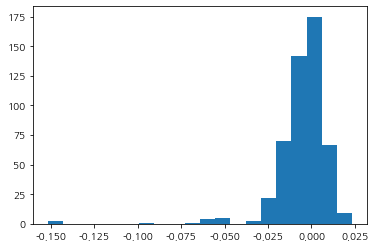

In [24]:
import matplotlib.pyplot as plt

plt.hist(merged_df_2['Weighted_Avg'], bins=20)

In [21]:
merged_df_2.to_csv("NHIS_BDC_2023/Round2/model_data/KOREA_FINAL_w_dtw.csv", index=False)

## b. XGBoost 모델 돌리기

### 나스닥(Train)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [32]:
train_cp_list = ['BKR', 'NSSC', 'GEVO', 'AAOI', 'LAZR', 'FGEN', 'TSLA', 'UFPI', 'VRSN', 'ALKS', 'AVAV', 'JBLU', 'EVRG', 'ODFL', 'HAIN', 'FFIE', 'SLAB', 'DHC', 'AHCO', 'INSE', 'CINF', 'PTVE', 'ADI', 'ACAD', 'CHX', 'BOOM', 'CRSP', 'SWKS', 'SITM', 'WIX', 'ASRT', 'BASE', 'FSTR', 'POWI', 'DDOG', 'UCTT', 'ZS', 'AVTA', 'FTAI', 'GAMB', 'CENX', 'ABCM', 'PARA', 'SPLK', 'KLIC', 'UAL', 'SEDG', 'RPD', 'PRFT', 'RMTI', 'SGEN', 'WBD', 'NDSN', 'BRZE', 'VKTX', 'FOLD', 'MRTX', 'ASUR', 'AMEH', 'SWBI', 'AVID', 'EZPW', 'QRVO', 'RGEN', 'NDAQ', 'BLFS', 'MCFT', 'LANC', 'JACK', 'SYNH', 'SSB', 'JBHT', 'QFIN', 'HDSN', 'ISRG', 'RIVN', 'DAWN', 'AMBA', 'TTGT', 'FCNCA', 'GERN', 'QDEL', 'MRNA', 'VLY', 'JD', 'BBIO', 'IONS', 'COST', 'EDIT', 'EBIX', 'HIMX', 'OLLI', 'RMBL', 'HZNP', 'GILD', 'REYN', 'CHTR', 'NCNO', 'OLED', 'KDP', 'GLPI', 'IQ', 'SHOO', 'HRMY', 'MKSI', 'CSIQ', 'PETS', 'ATVI', 'CDW', 'KROS', 'BAND', 'AMTX', 'STAA', 'EVLV', 'TIO', 'LGND', 'AFRM', 'BRKR', 'CLSK', 'SCPL', 'DNLI', 'COLM', 'MRNS', 'HALO', 'PI', 'MMYT', 'CMBM', 'ASO', 'PTLO', 'HST', 'RGLD', 'ICFI', 'NTES', 'CHRD', 'MULN', 'OPK', 'LI', 'ALEC', 'NXST', 'TW', 'RMBS', 'GO', 'RKDA', 'NKTR', 'TXRH', 'TVTX', 'IRDM', 'TARS', 'ROIV', 'MLCO', 'VRDN', 'ROST', 'ADAP', 'ALNY', 'GFS', 'TECH', 'FELE', 'DBX', 'TRUE', 'EXLS', 'URBN', 'DLTR', 'CGNX', 'URGN', 'AGEN', 'EXEL', 'CAKE', 'WDAY', 'SAVA', 'SBUX', 'ADSK', 'NBIX', 'ZYME', 'BKNG', 'EOLS', 'BPMC', 'AUR', 'CMCSA', 'VRNS', 'SIMO', 'NWL', 'PLUG', 'MBLY', 'ALHC', 'SATS', 'CG', 'SNPS', 'POOL', 'FLYW', 'SPTN', 'ADMA', 'ALGT', 'BRY', 'GNTX', 'VREX', 'ABNB', 'HBAN', 'NVAX', 'ONB', 'FWONA', 'GOEV', 'GEN', 'BZ', 'MGNI', 'RUSHA', 'TCOM', 'MYGN', 'CHK', 'ETSY', 'AAL', 'VERX', 'ATSG', 'VRA', 'ANIP', 'ODP', 'FATE', 'GSM', 'TGTX', 'BECN', 'STLD', 'OSIS', 'MNDY', 'IMMR', 'JAKK', 'CVLT', 'CHDN', 'ULTA', 'PRGS', 'NXPI', 'PANW', 'VIAV', 'CRSR', 'SP', 'KRT', 'SYNA', 'PECO', 'OTLY', 'SND', 'COMM', 'AMSC', 'LFUS', 'KYMR', 'MRVL', 'IEP', 'LULU', 'HOLX', 'CROX', 'HA', 'BNTX', 'FIVN', 'AEIS', 'IMGN', 'MAR', 'SYM', 'GPRO', 'HEES', 'EXPE', 'AMAT', 'SAGE', 'NATI', 'COIN', 'WOOF', 'HELE', 'INCY', 'SSNC', 'CFLT', 'VRTX', 'TWST', 'NSTG', 'VRSK', 'PAA', 'GRAB', 'MQ', 'DTIL', 'MU', 'UTHR', 'ARCT', 'NTRS', 'CEG', 'WWD', 'RKLB', 'HAS', 'PAGP', 'JAZZ', 'PBYI', 'COHU', 'FLNC', 'SMTC', 'HIBB', 'GDRX', 'ADPT', 'KPTI', 'LQDA', 'IOVA', 'BYND', 'CPRX', 'CSX', 'CONN', 'ADUS', 'EXTR', 'APPS', 'QCOM', 'PSNY', 'CSGP', 'GIII', 'ACHC', 'STGW', 'MIDD', 'NTLA', 'QURE', 'VIR', 'MXL', 'KFRC', 'SEAT', 'IAS', 'HON', 'ADTN', 'CDLX', 'OMGA', 'ITCI', 'INFN', 'ANDE', 'TMUS', 'MGRC', 'HURN', 'LWAY', 'STOK', 'FLEX', 'RUN', 'PDD', 'NTRA', 'ZNTL', 'LNT', 'MRSN', 'SIRI', 'CMLS', 'UPWK', 'NEXT', 'ORGO', 'HEAR', 'HPK', 'INDI', 'VERV', 'LINC', 'SCVL', 'CERT', 'CTAS', 'WW', 'CRDO', 'DOMO', 'MEDP', 'FAT', 'ARVN', 'GT', 'SNEX', 'GOOD', 'BL', 'AMSWA', 'SGRY', 'CCOI', 'AMZN', 'HUBG', 'CABA', 'DKNG', 'EYE', 'ONEW', 'FSLR', 'PLXS', 'VC', 'CRWD', 'TPG', 'DENN', 'FTNT', 'DXCM', 'RRGB', 'TTWO', 'LBTYA', 'BEAM', 'AVGO', 'WERN', 'AMRN', 'BANR', 'SAIA', 'HCCI', 'ASND', 'EEFT', 'ENSG', 'ICLR', 'FITB', 'SONO', 'WSBC', 'RNW', 'ADEA', 'PTON', 'GDS', 'CALM', 'PAYO', 'DNUT', 'LOCO', 'CCEP', 'PIRS', 'FRPT', 'ZION', 'TWNK', 'FIVE', 'AMPH', 'DUOL', 'BJRI', 'WB', 'APLS', 'SPWR', 'SCHL', 'TEAM', 'EXAS', 'RPRX', 'HTHT', 'BLUE', 'META', 'HCP', 'GH', 'PENN', 'MNKD', 'ATEC', 'RTL', 'LPLA', 'ROKU', 'MAT', 'ACLX', 'CNXC', 'ORLY', 'TER', 'NFLX', 'ILMN', 'EGHT', 'CRUS', 'REAL', 'BILI', 'ANGI', 'RXRX', 'VTNR', 'ITRI', 'ALGN', 'HSIC', 'CSWC', 'PATK', 'TROW', 'WDFC', 'TSCO', 'PEP', 'CHKP', 'BCRX', 'MATW', 'NKLA', 'ROP', 'CWST', 'TTEK', 'CAR', 'LRCX', 'VSAT', 'ICUI', 'SDGR', 'DISH', 'LITE', 'AMED', 'IPAR', 'EBAY', 'ZM', 'KLAC', 'SSYS', 'IDXX', 'PUBM', 'ZLAB', 'SNCY', 'HTZ', 'AMGN', 'TRMB', 'BSY', 'RILY', 'SDIG', 'RMR', 'AKBA', 'WYNN', 'EVER', 'BWEN', 'CRBU', 'NTNX', 'FAST', 'PTC', 'AAPL', 'RXT', 'ALDX', 'ARAY', 'VSTM', 'SNBR', 'EXC', 'MVIS', 'HCSG', 'IRBT', 'ON', 'UPBD']
test_cp_list = ['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']

In [33]:
data = pd.read_csv("NHIS_BDC_2023/Round2/model_data/NASDAQ_FINAL.csv")
train = data[data['TICKER'].isin(train_cp_list)]

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,sentiment_t,close_v,EBITDA,부채비율,매출액증가율,ROE,총자산회전율
27,ALTR,20230807,-0.001549,-0.039695,0.000000,0.000000,-0.612975,0.011376,-2.336000e+06,0.268652,-0.149807,-0.026350,0.113749
39,CDNS,20230807,-0.004678,-0.016074,0.000090,0.000056,-0.265648,0.007666,3.411820e+08,0.125807,-0.044153,0.062165,0.189136
119,TXN,20230807,-0.001112,-0.008547,0.001088,0.000000,0.500467,-0.001074,2.391000e+09,0.362617,0.034711,0.064110,0.150634
123,THRM,20230807,-0.009391,-0.053263,0.000000,0.000000,0.000000,-0.004649,1.771700e+07,0.196315,0.023920,-0.001747,0.296342
227,AMD,20230807,-0.009510,-0.003942,0.020161,0.003531,-0.575907,-0.014980,8.990000e+08,0.042079,0.001121,0.000475,0.079041


In [103]:
train['TICKER'].nunique()

497

In [104]:
train.shape

(1988, 13)

In [105]:
train.columns

Index(['TICKER', 'start_t', 'close_t', 'volume_t', 'mean_ratio_t',
       'mean_ratio_expert_t', 'sentiment_t', 'close_v', 'EBITDA', '부채비율',
       '매출액증가율', 'ROE', '총자산회전율'],
      dtype='object')

In [106]:
X = train.drop(['close_v', 'start_t', 'TICKER'], axis=1)
y = train['close_v']

In [107]:
X.columns

Index(['close_t', 'volume_t', 'mean_ratio_t', 'mean_ratio_expert_t',
       'sentiment_t', 'EBITDA', '부채비율', '매출액증가율', 'ROE', '총자산회전율'],
      dtype='object')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# df = pd.read_csv('your_data.csv')  # replace with your data file

# Display basic statistics
print(X.describe())

# Set up the matplotlib figure
n_rows, n_cols = X.select_dtypes(include=['float', 'int']).shape[1], 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Iterate over the numeric columns
for i, col in enumerate(X.select_dtypes(include=['float', 'int']).columns):
    sns.histplot(X[col], ax=axes[i, 0], kde=True)
    sns.boxplot(x=X[col], ax=axes[i, 1])

    axes[i, 0].set_title(f'Distribution of {col}')
    axes[i, 1].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

# For categorical data
for col in X.select_dtypes(include=['object', 'category']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

In [269]:
# Min-Max 스케일러 생성
# scaler = MinMaxScaler()

# Train 데이터를 스케일링합니다.
# X_train = scaler.fit_transform(X)

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
print(X_train.shape)
print(X_valid.shape)

(1590, 10)
(398, 10)


In [276]:
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 12.5 MB/s eta 0:00:00


In [278]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 7.2 MB/s eta 0:00:0000:0100:01


In [111]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    # 하이퍼파라미터 범위 설정
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    # 모델 생성 및 훈련
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    
    # 교차 검증을 사용한 모델 평가
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(np.abs(scores)))  # RMSE 계산

    return rmse

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # 100회의 시도로 최적화

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', study.best_params)

[I 2023-11-19 17:49:42,598] A new study created in memory with name: no-name-4dbf492b-718d-4b65-9caf-02186dd363d7
[I 2023-11-19 17:49:49,104] Trial 0 finished with value: 0.023560813719827878 and parameters: {'n_estimators': 315, 'max_depth': 9, 'learning_rate': 0.1537070754035316}. Best is trial 0 with value: 0.023560813719827878.
[I 2023-11-19 17:50:01,609] Trial 1 finished with value: 0.023532871936718974 and parameters: {'n_estimators': 479, 'max_depth': 7, 'learning_rate': 0.06988430434268653}. Best is trial 1 with value: 0.023532871936718974.
[I 2023-11-19 17:50:07,261] Trial 2 finished with value: 0.02393383493579538 and parameters: {'n_estimators': 336, 'max_depth': 8, 'learning_rate': 0.28698275019714276}. Best is trial 1 with value: 0.023532871936718974.
[I 2023-11-19 17:50:16,065] Trial 3 finished with value: 0.024268954417189233 and parameters: {'n_estimators': 437, 'max_depth': 4, 'learning_rate': 0.18570641353489775}. Best is trial 1 with value: 0.023532871936718974.
[I 2

최적 하이퍼파라미터: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.03331182392734434}


In [112]:
study.best_params

{'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.03331182392734434}

In [113]:
from xgboost import XGBRegressor

best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03331182392734434, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=164, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [114]:
# !pip install shap
# !pip install scikit-image
import shap
import skimage

In [115]:
explainer = shap.Explainer(best_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_train) # Shap Values 계산

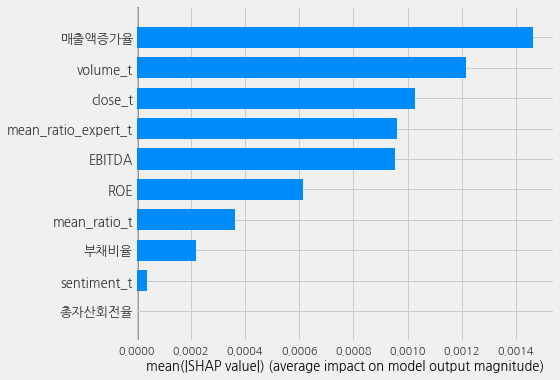

In [116]:
shap.summary_plot(shap_values, X_train, plot_type = "bar")

In [126]:
y_pred = best_model.predict(X_valid)

,TICKER,close_pred
4,AMKR,0.003865
21,CTSH,0.000816
24,NVDA,0.000816
19,RGTI,0.000816
32,TXN,0.000816
11,ALTR,0.000816
28,CD,0.000605
12,VRNT,0.000518
25,INTC,0.000414
18,NSIT,0.000414


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Validation RMSE:", rmse)

In [287]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_valid, y_pred)
print("Validation MAE:", mae)

Validation MAE: 0.01198543015611818


In [288]:
from sklearn.metrics import r2_score

r2 = r2_score(y_valid, y_pred)
print("Validation R²:", r2)

Validation R²: 0.02227983499732722


훈련 RMSE: 0.017, 테스트 RMSE: 0.020
훈련 R^2: 0.421, 테스트 R^2: 0.022


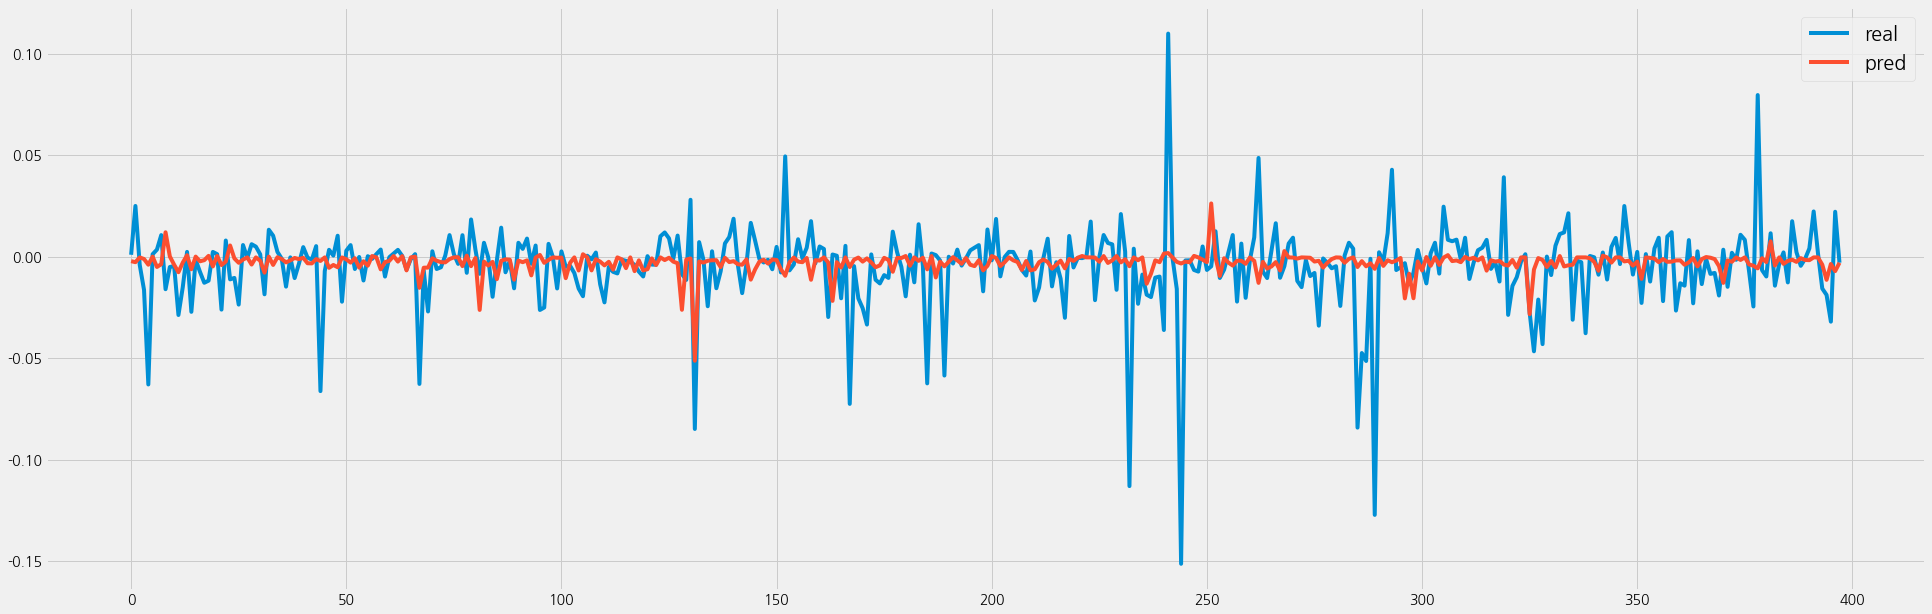

CV 정확도 점수: [-0.01961862 -0.08044883 -0.01261399 -0.03211477 -0.00561385]
CV 정확도: -0.030 +/- 0.027


In [299]:
import matplotlib.pyplot as plt

# 최적 모델로 예측 수행
y_train_pred = best_model.predict(X_train)
y_valid_pred = best_model.predict(X_valid)

# 결과 출력
print('훈련 RMSE: %.3f, 테스트 RMSE: %.3f' % (
    np.sqrt(mean_squared_error(y_train, y_train_pred)),
    np.sqrt(mean_squared_error(y_valid, y_valid_pred))))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_valid, y_valid_pred)))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 10))
plt.plot(np.array(y_valid), label='real')
plt.plot(np.array(y_valid_pred), label='pred')
plt.legend(fontsize=20)
plt.show()

#k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_val_score(estimator=best_model,
                         X=X_train,
                         y=y_train,
                         #cv=k_fold,  # k_fold로 변경
                         n_jobs=-1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

### 나스닥(Test)

In [49]:
test_cp_list = ['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']
test = data[data['TICKER'].isin(test_cp_list)]
test = test[test['start_t'] == 20230807]
# test.head()

In [50]:
X_test = test.drop(['close_v', 'start_t', 'TICKER'], axis=1)
y_test = test['close_v']

In [ ]:
y_test_pred = best_model.predict(X_test)
result_test['close_pred'] = y_test_pred
result_test = result_test.sort_values(by='close_pred', ascending=False)
result_test.reset_index(drop=True, inplace = True)
result_test.head()

### 국내 test 기업 추출

In [35]:
import pandas as pd

In [36]:
related_dict = pd.read_pickle("NHIS_BDC_2023/Round2/korea_related_nasdaq_dict.pkl")

test_cp_list = ['INTC', 'FFIV', 'CTSH', 'XRX', 'NVDA', 'ZBRA', 'DRS', 'SGH', 'LKQ', 'NSIT', 'PERI', 'VUZI', 'RGTI', 'ANSS', 'KTOS', 'VRNT', 'WDC', 'TXN', 'TTMI', 'LNTH', 'CRNC', 'AMKR', 'NNOX', 'CDNS', 'DIOD', 'CEVA', 'NTAP', 'TASK', 'AMD', 'MCHP', 'PLTK', 'THRM', 'CD', 'SCSC', 'ALTR', 'AKAM', 'LSCC', 'MSFT', 'SANM', 'SMCI', 'MPWR', 'CSCO']

In [38]:
associated_domestic_keys = [key for key, values in related_dict.items() if any(cp in test_cp_list for cp in values)]
# associated_domestic_keys

['005930',
 '005380',
 '000270',
 '222800',
 '066570',
 '011070',
 '077360',
 '064520',
 '123010',
 '005870',
 '016250',
 '396270',
 '018260',
 '348210',
 '033050',
 '038540']

### 국내(Train)

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('NHIS_BDC_2023/Round2/model_data/KOREA_FINAL_w_dtw.csv')
df.head()

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,Weighted_Avg
0,207940,20230605,-0.001717,0.031045,0.001134,0.001056,-0.008809,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.014280
1,207940,20230626,-0.002472,0.105524,0.001294,0.000913,0.013277,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.003840
2,207940,20230717,0.006188,0.176156,0.001431,0.001098,0.008207,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.020740
3,207940,20230807,-0.003886,-0.036662,0.000739,0.000560,-0.006781,4.271468e+11,0.150861,0.201495,0.019857,0.053996,-0.003859
4,125210,20230605,0.008390,0.059414,0.000992,0.001028,0.009121,NaN,NaN,NaN,NaN,NaN,-0.024546


In [39]:
# test_list_k = ['005930', '005380', '000270', '222800', '066570', '011070', '077360', '064520', '123010', '005870', '016250', '396270', '018260', '348210', '033050', '038540']
test_list_k = associated_domestic_keys
test_list = list(map(int, test_list_k))

In [5]:
train_df = df[~df['TICKER'].isin(test_list)]
train_df = train_df.dropna(subset=['close_v_x'])

,TICKER,start_t,close_t,volume_t,mean_ratio_t,mean_ratio_expert_t,close_v_x,EBITDA,부채비율,매출액증가율,ROE,총자산회전율,Weighted_Avg
23,5380,20230807,-0.002236,-0.059056,0.136461,0.016789,-0.000696,8.893386e+12,0.444756,0.118347,0.036508,0.157740,-0.001936
35,5930,20230807,-0.003949,-0.024452,0.750820,0.415238,0.003874,1.835834e+13,0.020400,-0.058668,0.004432,0.133036,-0.002858
171,270,20230807,0.000318,-0.122800,0.008068,0.003307,0.000000,6.066479e+12,0.070172,0.107787,0.065614,0.336443,-0.001632
175,222800,20230807,-0.007500,-0.113681,0.003344,0.003280,0.005025,1.745968e+10,0.530230,0.244124,-0.032201,0.204985,0.005767
211,11070,20230807,-0.003555,-0.059963,0.000797,0.000897,-0.000780,2.666788e+11,0.292258,-0.107100,0.000323,0.411758,-0.003420
215,77360,20230807,-0.007668,0.088249,0.000311,0.000308,-0.006653,NaN,0.202158,-0.039916,0.028873,0.091086,-0.003106
223,66570,20230807,-0.006113,0.001007,0.027938,0.007062,-0.000203,4.886004e+12,0.238890,-0.020446,0.008099,0.345841,-0.004109
283,64520,20230807,-0.003352,-0.048790,0.000039,0.000056,-0.001770,NaN,NaN,NaN,NaN,NaN,-0.002440
471,123010,20230807,-0.011795,-0.127728,0.000311,0.000336,0.036731,NaN,0.339774,-0.204460,-0.000470,0.076670,-0.001074
475,5870,20230807,-0.007372,0.093285,0.000389,0.000252,-0.000368,-1.786868e+09,0.005267,-0.183748,-0.010050,0.051584,0.001085


In [ ]:
X_train_k = train_df.drop(['close_v_x', 'start_t', 'TICKER'], axis=1)
y_train_k = train_df['close_v_x']
# sum(y_train_k.isna())

In [12]:
X_train_k, X_valid_k, y_train_k, y_valid_k = train_test_split(X_train_k, y_train_k, test_size=0.2, random_state=42)

In [13]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def objective2(trial):
    # 하이퍼파라미터 범위 설정
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    # 모델 생성 및 훈련
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    
    # 교차 검증을 사용한 모델 평가
    scores = cross_val_score(model, X_train_k, y_train_k, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(np.abs(scores)))  # RMSE 계산

    return rmse

# Optuna 스터디 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective2, n_trials=100)  # 100회의 시도로 최적화

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', study.best_params)

[I 2023-11-19 20:19:27,723] A new study created in memory with name: no-name-9d552bc4-2c2e-465d-a274-0b09f0cd2010
[I 2023-11-19 20:19:31,635] Trial 0 finished with value: 0.018057688856039245 and parameters: {'n_estimators': 355, 'max_depth': 4, 'learning_rate': 0.2745292278917335}. Best is trial 0 with value: 0.018057688856039245.
[I 2023-11-19 20:19:34,381] Trial 1 finished with value: 0.017815842849283593 and parameters: {'n_estimators': 224, 'max_depth': 5, 'learning_rate': 0.11083504964041237}. Best is trial 1 with value: 0.017815842849283593.
[I 2023-11-19 20:19:40,463] Trial 2 finished with value: 0.017614844679123925 and parameters: {'n_estimators': 445, 'max_depth': 6, 'learning_rate': 0.03161940708581038}. Best is trial 2 with value: 0.017614844679123925.
[I 2023-11-19 20:19:43,447] Trial 3 finished with value: 0.017563768896684154 and parameters: {'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.1424269357483981}. Best is trial 3 with value: 0.017563768896684154.
[I 2

최적 하이퍼파라미터: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.038214502750900006}


In [16]:
study.best_params

{'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.038214502750900006}

In [14]:
from xgboost import XGBRegressor

best_model_k = XGBRegressor(**study.best_params)
best_model_k.fit(X_train_k, y_train_k)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.038214502750900006, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=145, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_k = best_model_k.predict(X_valid_k)

rmse = np.sqrt(mean_squared_error(y_valid_k, y_pred_k))
print("Validation RMSE:", rmse)

Validation RMSE: 0.014679314165099539


In [17]:
import shap
import skimage
explainer = shap.Explainer(best_model_k) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_train_k) # Shap Values 계산


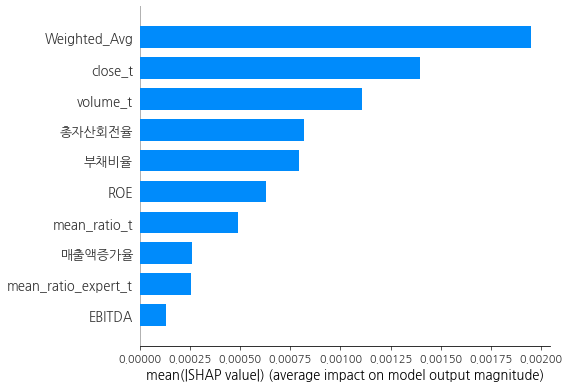

In [18]:
shap.summary_plot(shap_values, X_train_k, plot_type = "bar")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 최적 모델로 예측 수행
y_train_pred_k = best_model_k.predict(X_train_k)
y_valid_pred_k = best_model_k.predict(X_valid_k)

# 결과 출력
print('훈련 RMSE: %.3f, 테스트 RMSE: %.3f' % (
    np.sqrt(mean_squared_error(y_train_k, y_train_pred_k)),
    np.sqrt(mean_squared_error(y_valid_k, y_valid_pred_k))))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
    r2_score(y_train_k, y_train_pred_k),
    r2_score(y_valid_k, y_valid_pred_k)))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 10))
plt.plot(np.array(y_valid_k), label='real')
plt.plot(np.array(y_valid_pred_k), label='pred')
plt.legend(fontsize=20)
plt.show()

#k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_val_score(estimator=best_model_k,
                         X=X_train_k,
                         y=y_train_k,
                         #cv=k_fold,  # k_fold로 변경
                         n_jobs=-1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

### 국내(Test)

In [42]:
test_list_k = associated_domestic_keys
test_list = list(map(int, test_list_k))
test_df = df[df['TICKER'].isin(test_list)]
test_df = test_df[test_df['start_t'] == 20230807]
# test_df

In [43]:
X_test_k = test_df.drop(['close_v_x', 'start_t', 'TICKER'], axis=1)
result_test_k = test_df[['TICKER']]

In [51]:
df_ticker = pd.read_csv('NHIS_BDC_2023/Round2/bb_us_ks_stock_info.csv')
ls = []
for l in test_list_k: 
    ls.append(df_ticker[df_ticker['TICKER'] == l]['NAME'].to_list())
result_test_k['Name'] = ls
result_test_k

,TICKER,Name,close_pred
0,396270,[SAMSUNG ELECTRONICS CO LTD],0.010238
1,64520,[HYUNDAI MOTOR CO],0.008363
2,5870,[KIA CORP],0.004761
3,222800,[SIMMTECH CO LTD],0.004704
4,18260,[LG ELECTRONICS INC],0.003670
5,11070,[LG INNOTEK CO LTD],0.003633
6,77360,[DUKSAN HI-METAL CO LTD],0.003368
7,348210,[TECHL CO LTD],0.003288
8,5930,[IWIN PLUS CO LTD],0.003023
9,33050,[HUNEED TECHNOLOGIES],0.002979


In [47]:
y_test_pred_k = best_model_k.predict(X_test_k)
result_test_k['close_pred'] = y_test_pred_k
result_test_k = result_test_k.sort_values(by='close_pred', ascending=False)
result_test_k.reset_index(drop = True, inplace = True)
result_test_k[['Name', 'close_pred']]

,Name,close_pred
0,[NEXTCHIP CO LTD],0.010238
1,[TECHL CO LTD],0.008363
2,[HUNEED TECHNOLOGIES],0.004761
3,[SIMMTECH CO LTD],0.004704
4,[SAMSUNG SDS CO LTD],0.003670
5,[LG ELECTRONICS INC],0.003633
6,[LG INNOTEK CO LTD],0.003368
7,[NEXTIN INC],0.003288
8,[HYUNDAI MOTOR CO],0.003023
9,[JEONGMOON INFORMATION CO LTD],0.002979
